### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variatonal autoencoders combine neural networks with variationl inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Here's an example of what your outputs from the 3 different models you're going to train should look like... note that GANs are sometimes finicky, so your outputs might not look exactly like this... this is just meant to be a *rough* guideline of the kind of quality you can expect:

![caption](../img/gan_outputs_pytorch.png)

## Setup

In [19]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%config InlineBackend.figure_format = 'retina'

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

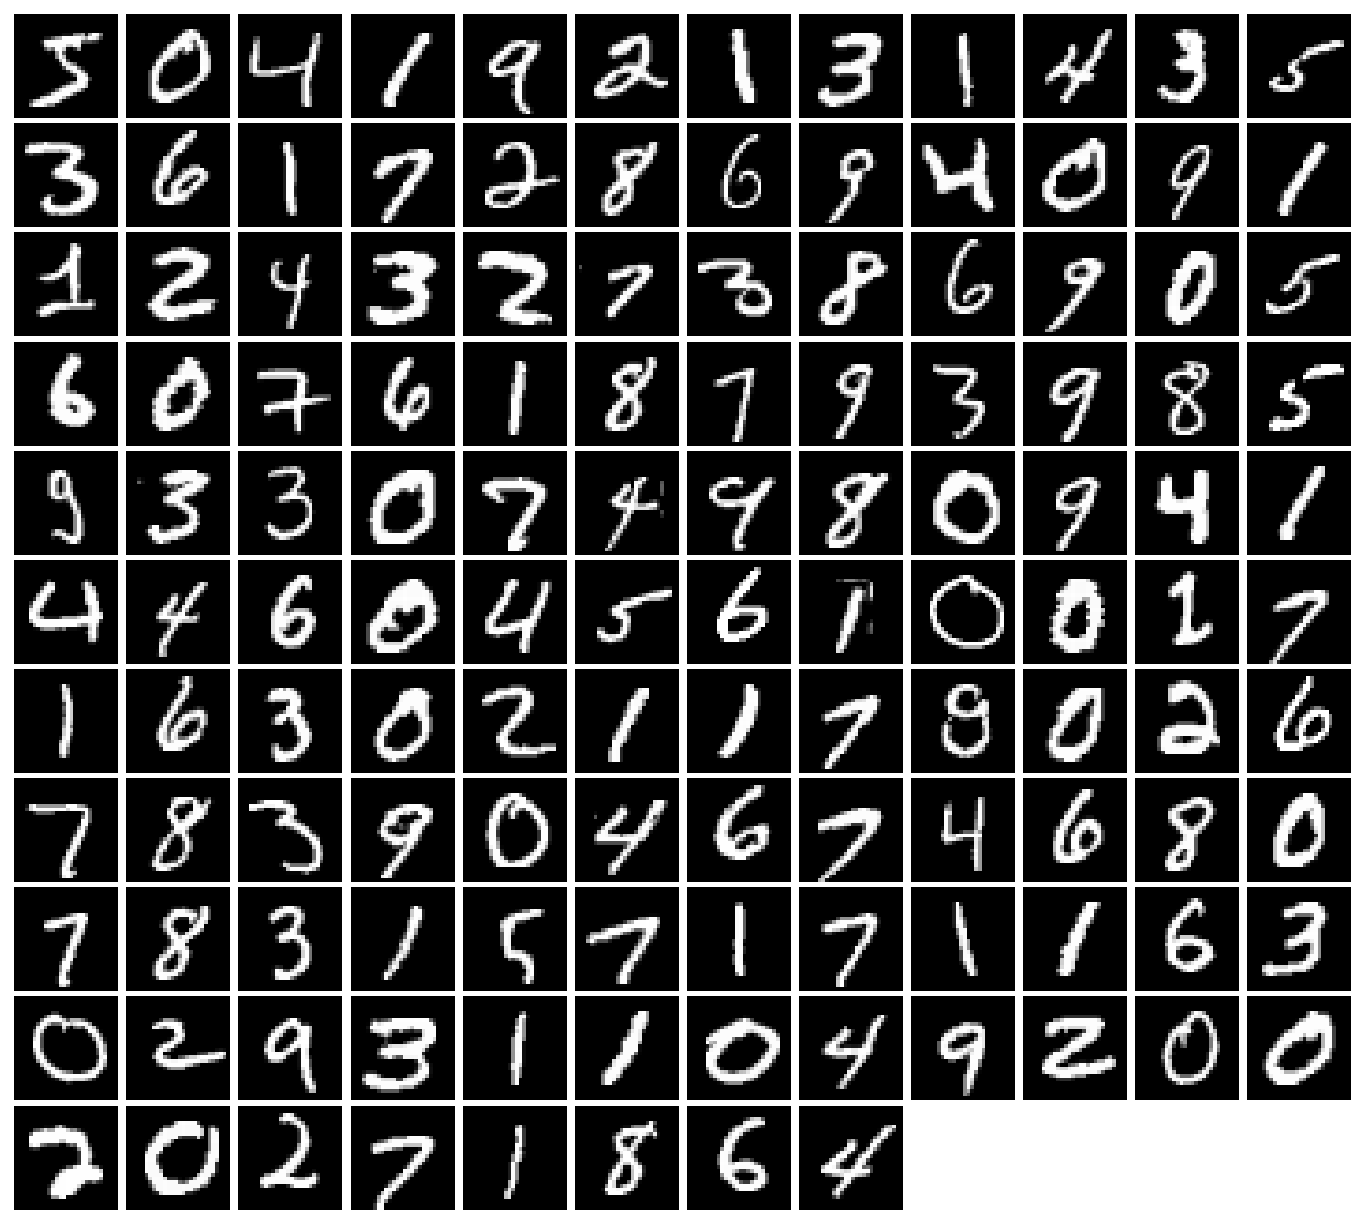

In [2]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 500

NOISE_DIM = 96
batch_size = 128
# show_every = 250
# noise_size = NOISE_DIM
# num_epochs = 1000


mnist_train = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

## Random Noise
Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`.

Hint: use `torch.rand`.

In [3]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return Variable(2 * torch.rand([batch_size, dim]) - 1, requires_grad=True)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


Make sure noise is the correct shape and type:

## Flatten

Recall our Flatten operation from previous notebooks... this time we also provide an Unflatten, which you might want to use when implementing the convolutional generator. We also provide a weight initializer (and call it for you) that uses Xavier initialization instead of PyTorch's uniform default.

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

## CPU / GPU
By default all code will run on CPU. GPUs are not needed for this assignment, but will help you to train your models faster. If you do want to run the code on a GPU, then change the `dtype` variable in the following cell.

In [5]:
# dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

# Discriminator
Our first step is to build a discriminator. Fill in the architecture as part of the `nn.Sequential` constructor in the function below. All fully connected layers should include bias terms. The architecture is:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1
 
Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; for the LeakyReLU nonlinearities in the architecture above we set $\alpha=0.01$.
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [6]:
def discriminator():
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential(
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            Flatten(),
            nn.Linear(784, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 1)

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    )
    return model

Test to make sure the number of parameters in the discriminator is correct:

# Generator
Now to build the generator network:
 * Fully connected layer from noise_dim to 1024
 * `ReLU`
 * Fully connected layer with size 1024 
 * `ReLU`
 * Fully connected layer with size 784
 * `TanH` (to clip the image to be in the range of [-1,1])

In [7]:
def generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential(
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            nn.Linear(noise_dim, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    )
    return model

Test to make sure the number of parameters in the generator is correct:

# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: You should use the `bce_loss` function defined below to compute the binary cross entropy loss which is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$

A naive implementation of this formula can be numerically unstable, so we have provided a numerically stable implementation for you below.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type using the global `dtype` variable, for example:


`true_labels = torch.ones(size).type(dtype)`

Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [8]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

In [9]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    
    loss = bce_loss(logits_real, torch.ones_like(logits_real)) +\
           bce_loss(logits_fake, torch.zeros_like(logits_fake))
#     loss = (logits_fake - logits_real).mean()
    
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    loss = bce_loss(logits_fake, torch.ones_like(logits_fake))
#     loss = -logits_fake.mean()

    return loss

Test your generator and discriminator loss. You should see errors < 1e-7.

# Optimizing our loss
Make a function that returns an `optim.Adam` optimizer for the given model with a 1e-3 learning rate, beta1=0.5, beta2=0.999. You'll use this to construct optimizers for the generators and discriminators for the rest of the notebook.

In [10]:
def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = optim.Adam(model.parameters(), 
                           lr=1e-3,
                           betas=(0.5, 0.999))
    return optimizer

# LOGAN - Latent Optimization GAN

The cell below have the implementation for the equations 4 and 12 on the paper. They both compute the new $z'$ to train the network. As can be seen, there is no change in the training flow, there is just the optimization step to be performed.

There are a few differences from this implementation. For instance, this code do not implement the possibility of computing the gradient for a subset of the vector $z$ and it does not compute the optimization step multiple times. Though, the results agree with the author's proposed improvements. Mainly, with the analysis that is done here, we can notice that the training is more stable compared with the notebook that does not have that step.

In [62]:
def lat_opt_gd(G,D,z, batch_size, alpha=1):
    x_hat = G(z)
    f_z = D(x_hat.view(batch_size, 1, 28, 28))

    fz_dz = torch.autograd.grad(outputs=f_z,
                                inputs= z,
                                grad_outputs=torch.ones_like(f_z),
                                retain_graph=True,
                                create_graph= True
                                   )[0]
    
    delta_z = torch.ones_like(fz_dz)
    delta_z = alpha * fz_dz
    
    with torch.no_grad():
        z_prime = torch.clamp(z + delta_z, min=-1, max=1) 
        
    return z_prime

def lat_opt_ngd(G,D,z, batch_size, alpha=500, beta=0.1, norm=1000):
    x_hat = G(z)
    f_z = D(x_hat.view(batch_size, 1, 28, 28))

    fz_dz = torch.autograd.grad(outputs=f_z,
                                inputs= z,
                                grad_outputs=torch.ones_like(f_z),
                                retain_graph=True,
                                create_graph= True
                                   )[0]
    
    delta_z = torch.ones_like(fz_dz)
    delta_z = (alpha * fz_dz) / (beta +  torch.norm(delta_z, p=2, dim=0) / norm)
    print(alpha * fz_dz, torch.norm(delta_z, p=2, dim=0), (beta +  torch.norm(delta_z, p=2, dim=0) / norm))
    with torch.no_grad():
        z_prime = torch.clamp(z + delta_z, min=-1, max=1) 
        
    return z_prime

# Training a GAN!

We provide you the main training loop... you won't need to change this function, but we encourage you to read through and understand it. 

In [63]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=96, num_epochs=20, lat_opt='gd'):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    discr_loss_history = []
    gen_loss_history = []
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
                
            ## latent optimization step
            
            G_solver.zero_grad(), D_solver.zero_grad()
            z = sample_noise(batch_size, noise_size).type(dtype) 
            z_prime = lat_opt_ngd(G,D,z, batch_size)
#             z_prime = lat_opt_gd(G,D,z, batch_size) 


            ## regular training
            
            D_solver.zero_grad()
            real_data = x.type(dtype)
            logits_real = D(2* (real_data - 0.5)).type(dtype)

            g_fake_seed = z_prime #sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = z_prime #sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1
            
            discr_loss_history.append(d_total_error.data.item())
            gen_loss_history.append(g_error.data.item())
            
    return discr_loss_history, gen_loss_history

tensor([[ 0.1426, -0.0631, -0.0200,  ...,  0.1836, -0.1442,  0.4220],
        [-0.3745, -0.3516,  0.2241,  ...,  0.1112, -0.3510,  0.8450],
        [-0.3949, -0.4450,  0.4028,  ...,  0.0823, -0.8100,  0.2796],
        ...,
        [-0.2627,  0.3463, -0.7664,  ...,  0.0321, -0.3218,  0.1764],
        [-0.3470,  0.6640,  0.4985,  ...,  0.3296, -0.3059, -0.0992],
        [ 0.0424, -0.7145,  0.4819,  ..., -0.1521,  0.3108,  1.2878]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([40.7646, 41.5283, 42.4057, 36.8056, 45.2661, 45.4102, 35.4282, 35.7694,
        52.3508, 43.5199, 34.6621, 46.9096, 43.6445, 42.1877, 56.6914, 42.9887,
        44.4901, 41.3243, 43.2280, 38.0693, 38.2475, 41.6747, 49.3397, 36.9829,
        49.8429, 46.8204, 38.6723, 58.1524, 42.2528, 43.5448, 39.1807, 48.4901,
        40.5579, 60.6807, 44.7513, 40.7935, 49.9997, 56.9786, 41.9838, 57.1259,
        41.5056, 44.2616, 40.8301, 43.9090, 40.0281, 48.8633, 40.3355, 42.5683,
        31.8895, 40.9455, 39.4937, 41.

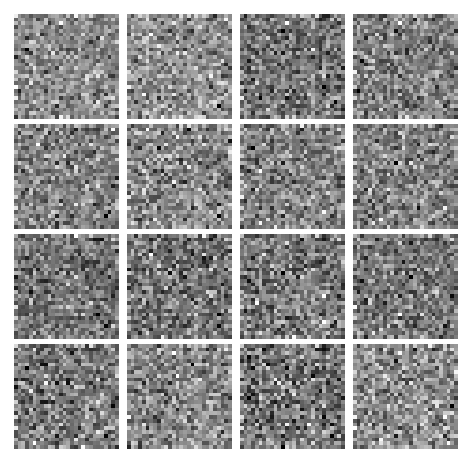


tensor([[ 1.0095, -2.4398, -1.1728,  ..., -0.5410,  2.4779,  2.2726],
        [ 1.1102,  1.4603, -1.9088,  ...,  1.9407,  3.0781,  3.0271],
        [-0.4769, -2.0752, -2.2344,  ...,  0.1253,  1.5665,  1.4919],
        ...,
        [ 0.8220,  0.0778,  0.7595,  ...,  1.6603, -0.4582,  1.2531],
        [-1.6278, -1.1679,  0.5489,  ..., -1.4603,  0.3074,  0.4268],
        [-2.6129,  1.6211, -0.3806,  ..., -0.6122,  1.5189,  1.6072]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([159.7150, 143.6506, 139.9699, 138.9296, 162.4269, 167.6005, 167.7377,
        146.0762, 152.8999, 167.1709, 181.1062, 151.5135, 180.8105, 147.9638,
        147.6280, 148.0384, 160.0957, 156.4907, 160.0590, 160.5268, 158.1459,
        145.6066, 147.0330, 167.0457, 156.6978, 162.0531, 158.9869, 188.1908,
        136.3796, 179.0471, 190.3055, 142.0859, 190.6124, 169.6422, 159.1382,
        156.6265, 155.6958, 160.2024, 137.1049, 175.1161, 152.0980, 169.6031,
        145.7601, 152.7218, 130.0982, 183.7677, 1

       device='cuda:0', grad_fn=<MulBackward0>) tensor([477.0374, 469.6744, 424.4883, 359.7846, 607.9022, 444.3255, 590.0233,
        598.2673, 496.9068, 403.3865, 455.3587, 402.9258, 409.6286, 509.6899,
        399.1578, 365.6921, 452.0624, 437.5481, 402.5361, 510.2733, 421.9762,
        447.7921, 416.7221, 566.4885, 654.7161, 405.6186, 555.7817, 423.9492,
        448.9683, 545.1380, 516.8131, 404.0616, 559.9265, 481.9848, 344.3059,
        421.1375, 514.0657, 454.3133, 569.8604, 400.4012, 682.6823, 445.4500,
        549.6800, 425.6237, 473.6382, 530.4275, 465.9362, 644.9740, 456.7305,
        628.4627, 493.2496, 442.9278, 683.9194, 467.6396, 596.9629, 415.7529,
        559.7240, 390.7583, 542.6547, 644.8196, 397.4821, 434.2059, 487.9253,
        479.1960, 500.1345, 392.0854, 569.6428, 434.3864, 546.1802, 647.7081,
        562.1837, 511.0989, 402.8305, 438.0860, 506.3218, 532.3976, 494.8452,
        527.6205, 514.7899, 372.1879, 380.8706, 464.4865, 405.8681, 564.1773,
        387.2319

       grad_fn=<NormBackward1>) tensor([0.1451, 0.1469, 0.2003, 0.1792, 0.2743, 0.1983, 0.1530, 0.1842, 0.1835,
        0.1547, 0.1670, 0.1513, 0.1553, 0.1541, 0.3248, 0.1419, 0.1549, 0.1939,
        0.1535, 0.1740, 0.1705, 0.1448, 0.1642, 0.2055, 0.2010, 0.2947, 0.1729,
        0.2999, 0.1745, 0.1568, 0.1662, 0.1597, 0.2070, 0.1582, 0.1401, 0.1971,
        0.2671, 0.1874, 0.2597, 0.2268, 0.2719, 0.1947, 0.2228, 0.1584, 0.2396,
        0.1500, 0.1500, 0.1994, 0.1644, 0.1708, 0.2854, 0.1609, 0.2233, 0.2885,
        0.2254, 0.1589, 0.2155, 0.1624, 0.1832, 0.1832, 0.1918, 0.2512, 0.1914,
        0.1487, 0.1469, 0.1465, 0.1978, 0.2594, 0.1682, 0.1851, 0.1473, 0.2037,
        0.2487, 0.1976, 0.1567, 0.2116, 0.2953, 0.1458, 0.1830, 0.2202, 0.2267,
        0.2432, 0.1512, 0.1636, 0.2548, 0.1620, 0.2275, 0.2061, 0.2244, 0.1672,
        0.2287, 0.1707, 0.1603, 0.1970, 0.1648, 0.2386], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 1.1177,  2.7863, -2.6073,  ...,  1.2056,  1.8511, -2.

       grad_fn=<AddBackward0>)
tensor([[ -2.2037,   8.9362,  -2.8122,  ...,   7.5070,   7.2380, -10.2522],
        [ -1.5844,   4.8341,  -9.7681,  ...,  12.7637,   6.3888,  -5.2863],
        [ -5.4822,   6.9247,  -8.8475,  ...,   9.6061,   7.0574,  -6.0530],
        ...,
        [  2.0691,   0.8971,  -9.4650,  ...,   7.6023,   5.3595,  -8.4253],
        [  1.2443,   2.9572, -10.0324,  ...,   3.5341,   3.1419,  -8.4610],
        [  0.6677,   8.9030,  -5.4911,  ...,   4.1617,   5.7240,  -7.6242]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 322.3422,  526.5237,  780.1777,  282.2507,  826.0928,  770.2305,
         351.8221,  486.4491,  680.2533,  565.5356, 1001.9370,  650.1241,
         706.6837,  438.9082,  862.7584,  636.8862,  476.1128,  987.7623,
         317.8667,  323.6689,  584.8707,  382.9982,  421.4549,  779.1423,
         809.2632, 1105.6044,  585.5757,  830.0975,  644.3973,  629.3277,
         572.9478,  624.1205,  589.3240,  573.2268,  329.6540,  496.7381,
       

       device='cuda:0', grad_fn=<MulBackward0>) tensor([292.2558, 598.1592, 422.0576, 198.4431, 161.2735, 433.7773, 526.2256,
        149.2243, 435.8415, 495.5735, 719.5333, 656.6752, 679.1061, 184.7122,
        273.8180, 603.8812, 512.9399, 611.9684, 204.5831, 488.5986, 364.4060,
        234.5483, 380.7377, 271.4547, 311.5071, 741.2679, 197.7028, 480.6253,
        259.8029, 599.8847, 590.7471, 577.9338, 511.0713, 526.4021, 307.6898,
        284.4983, 213.5710, 312.7798, 265.7786, 480.1151, 186.5329, 620.3716,
        210.4317, 499.7111, 245.0085, 500.5758, 700.0560, 722.3050, 244.2824,
        605.2999, 340.7973, 464.5686, 163.8518, 302.4022, 339.7346, 418.4944,
        166.6233, 519.4095, 162.7365, 158.5371, 626.9720, 341.3874, 141.1095,
        412.8934, 596.4635, 168.1838, 661.6776, 499.8358, 698.5941, 140.6477,
        454.8091, 513.8848, 449.5609, 558.7857, 284.4820, 197.5775, 368.5636,
        494.0901, 234.9071, 422.8421, 329.8063, 355.3122, 605.9783, 218.9055,
        495.0284

       device='cuda:0', grad_fn=<NormBackward1>) tensor([1.4909, 1.9732, 0.8882, 0.5114, 1.0360, 1.0328, 1.4430, 0.8414, 1.1720,
        1.5583, 1.7483, 2.1575, 1.8890, 0.8173, 0.8236, 1.5851, 1.6843, 1.2798,
        0.8276, 2.0740, 1.1338, 0.8740, 1.1745, 0.6500, 0.6165, 1.2545, 0.5533,
        0.9016, 0.5311, 1.4529, 1.8340, 1.5808, 1.2854, 1.3916, 1.5295, 0.5203,
        0.9473, 0.6165, 0.7288, 1.0835, 1.5234, 1.7401, 0.5544, 1.3249, 0.5763,
        1.2450, 1.7777, 1.7925, 0.8451, 1.1754, 0.6898, 1.3236, 1.1626, 0.7490,
        0.6788, 1.8298, 1.3864, 1.7383, 0.6752, 0.9186, 1.6320, 0.5727, 1.0655,
        1.7243, 1.4841, 0.9887, 1.5142, 1.1619, 1.5382, 1.0016, 1.4412, 1.9924,
        0.7644, 1.6058, 1.5473, 1.6562, 0.7419, 1.9077, 0.5367, 0.9273, 0.8171,
        0.6939, 1.5612, 1.1865, 1.0745, 1.5570, 1.2627, 0.5358, 1.4254, 1.3940,
        0.6234, 2.0483, 1.9604, 0.7832, 1.1765, 1.2365], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[17.7373, 18.5549, -5.1032,  ..., -6.6

       grad_fn=<AddBackward0>)
tensor([[  7.4166,  13.5332,  -6.0579,  ...,  -2.1237,   5.4706,  -3.3516],
        [ 15.5141,  13.4565,  -0.5806,  ...,  -3.2135,   2.1756, -11.2855],
        [ 12.7985,  16.6964, -11.4155,  ...,   1.3985,   8.9528, -10.8590],
        ...,
        [ 10.4822,   8.8241,  -8.2060,  ...,   2.9144,   7.5677, -12.8414],
        [  9.1587,  11.8348,   0.0886,  ...,   6.7644,   8.7051,  -3.9396],
        [  8.7855,   9.1301,  -1.6140,  ...,   1.3870,   2.5377,  -2.9359]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 945.0059, 1161.5524,  421.7596,  280.1958,  990.2286,  357.7094,
         898.7521,  728.0437,  485.1144,  927.2309,  800.5066, 1390.9481,
        1029.6052,  555.3806,  746.4017,  870.7275,  990.2287,  572.9286,
         415.0228, 1480.5537,  591.2260,  661.8106,  659.0414,  566.8225,
         395.4537,  349.7916,  359.6416,  422.9966,  510.4157,  734.2933,
        1183.3810,  918.0524,  733.6227,  673.2269,  959.5925,  553.2274,
       

       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 694.7319,  339.7456, 1055.7157,  562.9484, 1458.2386,  594.9753,
         431.1024,  765.2281,  365.0563,  315.4265,  592.7139,  458.0336,
         410.5621, 1063.2041, 1645.8842,  338.3087,  356.4215,  621.9000,
         379.7507,  679.4290,  347.3907,  468.0439,  375.4810, 1414.1228,
        1000.4188, 1097.4368,  526.6766,  793.4505, 1210.5305,  484.6298,
         319.9388,  351.1007,  356.0431,  408.1102,  653.7520, 1274.4989,
        1586.2894,  877.5798, 1575.8474, 1096.2910, 1535.6340,  504.0935,
         908.0170,  380.2126, 1123.1204,  475.2414,  318.8301,  706.8164,
         304.2704,  692.4863, 1348.9646,  366.8506,  941.0847, 1617.2350,
         742.0390,  613.5988, 1224.1083,  369.4625,  625.5172,  889.9819,
         509.5938,  906.9972, 1134.9142,  365.1877,  408.2350,  757.9070,
         678.9584,  344.0039,  389.0625, 1150.7394,  341.9947,  587.6105,
        1429.8444,  427.9865,  889.7955, 1090.1292, 1817.4457,  

       grad_fn=<NormBackward1>) tensor([0.4183, 0.4746, 0.3648, 0.3928, 0.3369, 0.4149, 0.5263, 0.3775, 0.4792,
        0.4191, 0.4037, 0.4280, 0.4570, 0.2770, 0.2382, 0.4208, 0.4485, 0.4996,
        0.2819, 0.4077, 0.4140, 0.4059, 0.4353, 0.2386, 0.2431, 0.4394, 0.2529,
        0.4071, 0.2285, 0.4721, 0.4835, 0.4559, 0.5326, 0.4394, 0.3434, 0.2546,
        0.2484, 0.2751, 0.2309, 0.3968, 0.3850, 0.5363, 0.2452, 0.4324, 0.2665,
        0.4600, 0.4852, 0.4972, 0.2701, 0.4771, 0.2332, 0.4534, 0.4223, 0.2572,
        0.2335, 0.2961, 0.3912, 0.4463, 0.3149, 0.3677, 0.4923, 0.3088, 0.2971,
        0.4224, 0.4271, 0.3029, 0.4677, 0.4822, 0.4754, 0.3333, 0.4785, 0.3100,
        0.2445, 0.5061, 0.3367, 0.2897, 0.2581, 0.3987, 0.2372, 0.4270, 0.3463,
        0.2644, 0.4859, 0.2838, 0.4860, 0.4861, 0.4679, 0.2611, 0.5432, 0.4933,
        0.2414, 0.4358, 0.5215, 0.3728, 0.4328, 0.5310], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-1.8393, -1.0509,  0.5186,  ..., -1.8690, -0.2102,  2.

       grad_fn=<AddBackward0>)
tensor([[-2.6027,  8.8953, -5.6960,  ..., -0.3611,  5.4336, -4.0937],
        [-4.3635,  5.2015, -1.4156,  ..., -3.7152,  0.6744, -3.3338],
        [-1.9451,  9.4208, -2.0327,  ...,  0.4612,  3.6976, -1.8535],
        ...,
        [ 2.1109,  9.5633, -5.7282,  ...,  0.1227,  3.9235, -4.1190],
        [-2.1953,  3.5847, -1.3927,  ..., -0.6917,  2.3304, -1.1373],
        [-4.2927,  4.0761, -1.8184,  ...,  0.2681, -0.7743, -0.4116]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 264.0249,  779.0743,  532.7461,  450.9263,  880.9413,  263.5914,
         445.5657,  520.3795,  257.4186,  791.9688,  672.3428,  859.4887,
        1074.7998,  506.5762,  863.0052,  749.6640,  681.4657,  385.4498,
         384.6982,  293.7260,  352.9825,  803.5009,  205.3339,  664.0062,
         590.2172,  715.4691,  511.2400,  272.7252,  466.2890,  349.7024,
         642.4601, 1052.4961,  234.5160,  207.5476,  275.7778,  357.0257,
         836.0319,  720.3600,  755.2820,  6

       device='cuda:0', grad_fn=<MulBackward0>) tensor([330.1425, 716.6074, 306.4155, 155.0168, 307.6711, 160.8453, 710.6567,
        245.4879, 261.7680, 689.5629, 511.9533, 879.2734, 735.6959, 189.9774,
        178.2059, 660.6326, 758.7086, 571.8376, 189.2336, 539.4780, 179.2641,
        146.8998, 284.7992, 222.1616, 164.7742, 480.7159, 155.6929, 283.6872,
        145.7469, 544.3695, 773.2411, 604.6130, 504.5649, 268.4879, 267.8974,
        161.4659, 171.5958, 304.5059, 213.4878, 418.0043, 470.0012, 664.2827,
        162.2882, 582.7816, 183.0568, 275.6064, 779.6595, 619.5398, 251.9416,
        400.2343, 193.9847, 564.1763, 295.4199, 196.7427, 135.4758, 634.6980,
        354.8068, 708.2722, 209.9146, 213.3687, 692.4594, 229.0090, 283.9240,
        686.5408, 588.6455, 152.1584, 526.8618, 599.8932, 561.1852, 269.4843,
        438.3723, 617.4053, 233.9273, 394.3084, 365.7494, 357.2515, 192.4090,
        506.0543, 304.5968, 307.4781, 189.8949, 198.9326, 592.2305, 167.3488,
        269.0883

       grad_fn=<NormBackward1>) tensor([0.3479, 0.5127, 0.2796, 0.1993, 0.4265, 0.2983, 0.5102, 0.2580, 0.2316,
        0.5020, 0.4273, 0.7138, 0.5308, 0.3077, 0.3488, 0.5296, 0.5197, 0.4937,
        0.3362, 0.5034, 0.2246, 0.2179, 0.3250, 0.3625, 0.2133, 0.3840, 0.2033,
        0.2036, 0.2099, 0.4744, 0.6158, 0.4634, 0.4456, 0.2213, 0.3744, 0.2974,
        0.2549, 0.2947, 0.3588, 0.3560, 0.5793, 0.5237, 0.2456, 0.5402, 0.2437,
        0.2195, 0.6454, 0.4554, 0.3664, 0.3353, 0.2091, 0.4210, 0.3155, 0.2505,
        0.2189, 0.5600, 0.3426, 0.6863, 0.1999, 0.2573, 0.5857, 0.2735, 0.3310,
        0.5515, 0.4714, 0.2471, 0.3428, 0.4729, 0.4781, 0.3152, 0.3884, 0.4848,
        0.2321, 0.3477, 0.3888, 0.4602, 0.2112, 0.4112, 0.3111, 0.2664, 0.2511,
        0.2316, 0.6249, 0.2409, 0.2257, 0.4976, 0.4243, 0.2167, 0.4194, 0.5108,
        0.2394, 0.4755, 0.5070, 0.2467, 0.3260, 0.2988], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 1.5655,  5.5609, -1.7828,  ..., -2.9562,  1.7946, -0.

       grad_fn=<AddBackward0>)
tensor([[ 8.8122, 12.2165,  0.9728,  ..., -6.7322,  5.6186, -4.4692],
        [12.4137, 11.6923,  4.8998,  ..., -5.8051,  4.5593, -1.4924],
        [ 7.3612, 10.1533,  3.3438,  ..., -7.7482,  9.0477, -2.1551],
        ...,
        [11.5367, 14.4671,  2.0657,  ..., -3.3090,  3.2200, -1.9594],
        [11.3559,  4.3788,  1.4303,  ..., -5.7920,  5.9893, -1.6502],
        [ 5.6201,  8.6030,  0.9030,  ..., -6.7373,  2.5867, -1.7897]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 911.2194,  981.6100,  246.3671,  516.2997,  760.0874,  366.0783,
        1040.9279,  396.2141,  247.2602, 1125.2678,  737.3282, 1259.1454,
        1060.7030,  618.6221,  614.0164,  733.7761,  724.2916,  527.5620,
         438.3496,  826.3040,  448.1069,  536.7905,  516.9696,  791.3232,
         511.3487,  303.6841,  365.0803,  539.8458,  590.0511,  652.0588,
         919.9296,  973.3431,  499.7136,  298.9790,  577.4460,  656.1105,
         614.8292,  391.9143,  871.9796,  3

       device='cuda:0', grad_fn=<MulBackward0>) tensor([451.5916, 158.9567, 224.1781, 155.3317, 211.0095, 150.9224, 239.1759,
        240.6837, 196.1952, 237.2333, 241.2011, 134.5256, 230.1954, 244.4288,
        184.0428, 126.5358, 116.2327, 204.9422, 117.9922, 102.4424, 235.4017,
        241.5819, 227.9841, 175.9525, 352.2981, 125.4071, 365.6474, 367.9169,
        234.0063, 208.6212, 120.9354, 319.5367, 161.9797, 214.3148, 166.6505,
        140.2491, 240.5950, 510.4079, 332.9191, 138.0006, 195.7840, 205.7483,
        191.4148, 185.4318, 176.9691, 231.9637, 255.8397, 134.5598, 120.8657,
        153.7363, 240.6948, 239.0728, 218.6342, 289.7555, 207.8689, 152.2967,
        199.1818, 221.6116, 302.1961, 124.0731, 195.2321, 143.9537, 140.1683,
        234.9342, 128.2806, 242.6528, 259.6863, 222.7942, 237.9030, 286.2073,
        105.2514, 109.1669, 435.6085, 176.9609, 123.9564, 258.0014, 433.8206,
        178.5704,  97.1444, 277.3924, 125.1980, 346.0973, 195.7993, 156.2132,
        212.7697

       grad_fn=<NormBackward1>) tensor([0.7249, 0.5861, 0.5071, 0.3018, 0.7171, 0.8172, 0.6762, 0.6006, 0.5493,
        0.2844, 0.2902, 0.3314, 0.3358, 0.5473, 0.3870, 0.3313, 0.3424, 0.6809,
        0.6168, 0.4128, 0.4998, 0.6733, 0.4984, 0.4123, 0.8781, 0.3949, 0.5313,
        0.2752, 0.5719, 0.6099, 0.3772, 0.3276, 0.3696, 0.4534, 0.2924, 0.5283,
        0.6407, 0.7669, 0.5848, 0.4223, 0.4400, 0.2825, 0.4495, 0.3516, 0.5296,
        0.2871, 0.3553, 0.2779, 0.6860, 0.3011, 0.6427, 0.7606, 0.8209, 0.7850,
        0.5480, 0.3643, 0.7617, 0.3447, 0.4283, 0.4497, 0.3669, 0.3943, 0.4310,
        0.5558, 0.2723, 0.6568, 0.7891, 0.6159, 0.4683, 0.6543, 0.5249, 0.3387,
        0.6685, 0.5545, 0.3171, 0.6846, 1.0120, 0.5905, 0.4409, 0.5597, 0.5558,
        0.5579, 0.3245, 0.7138, 0.3342, 0.3069, 0.4461, 0.4643, 0.3329, 0.2848,
        0.2749, 0.5546, 0.4612, 0.3978, 0.7325, 0.5069], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 6.2636,  5.8005,  6.9572,  ...,  0.4616,  6.5925,  0.

       grad_fn=<AddBackward0>)
tensor([[  4.6042,  19.3197,   5.1344,  ...,   7.1190,  12.8152, -10.4086],
        [  5.4436,  16.1687,   3.4507,  ...,   4.1959,  11.7365, -10.2378],
        [  3.8038,  16.1479,   0.1856,  ...,   4.0865,   9.3924, -11.3303],
        ...,
        [  9.4779,  15.1619,   0.7643,  ...,   5.5219,   9.4105,  -9.5458],
        [  6.4073,  21.3787,   5.7948,  ...,   3.2470,   9.7530,  -9.5756],
        [  5.2184,  15.6683,   4.2545,  ...,   5.0233,   9.8460, -13.1043]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 639.5591, 1629.1829,  366.2669,  421.0341,  476.4423,  949.3967,
        1462.6304,  330.5074,  665.5798,  699.2321,  250.5438, 1359.2723,
        1000.8501,  508.1504,  291.1728,  488.6251, 1036.5007, 1267.5629,
         430.9500,  733.9736, 1063.4685,  513.0912,  606.1320, 1215.6389,
         600.4709,  293.6483, 1022.6000,  235.8386,  328.7687, 1112.5581,
         732.2549,  474.9338,  429.4232,  757.1462,  232.1642,  891.6426,
       

       device='cuda:0', grad_fn=<MulBackward0>) tensor([210.3688, 291.2144, 331.8918, 215.4846, 275.8288, 232.9536, 296.4159,
        130.7853, 325.8430, 470.4739, 353.2249, 392.1176, 578.9184, 157.7704,
        521.1962, 617.2190, 564.6377, 287.2748, 162.0899, 224.0012, 448.5590,
        130.5710, 187.2757, 164.8624, 343.4152, 321.8146, 163.8295, 322.6614,
        343.0404, 301.5674, 574.6564, 449.0963, 419.8494, 282.1402, 137.0665,
        267.5942, 314.7444, 248.8073, 319.9293, 233.1552, 249.9814, 516.7896,
        170.1189, 419.9140, 184.0019, 140.4758, 537.4510, 579.0346, 140.7980,
        492.3770, 318.2237, 207.6082, 179.6760, 586.3232, 162.8231, 257.6924,
        176.0224, 332.8475, 211.7049, 253.8900, 571.3422, 176.1052, 260.6259,
        249.3974, 512.2217, 264.0937, 342.2475, 388.5493, 392.0116, 157.0099,
        386.8853, 198.4243, 324.9326, 198.4035, 178.9377, 176.8312, 492.2412,
        195.0256, 282.7932, 323.1172, 202.3786, 361.2119, 246.4375, 154.9981,
        411.9492

       device='cuda:0', grad_fn=<NormBackward1>) tensor([1.5152, 0.5525, 1.0511, 1.5648, 1.0736, 0.6110, 0.5503, 0.8135, 1.0166,
        1.2497, 0.7150, 1.4253, 1.6346, 0.8427, 1.5042, 1.7288, 2.2361, 0.5035,
        0.5988, 1.1141, 1.8285, 1.0047, 0.7024, 0.4780, 1.5342, 0.9707, 0.6247,
        0.8782, 1.3384, 0.6473, 1.8627, 1.6101, 1.0689, 0.7612, 1.1790, 1.0736,
        1.1467, 0.9318, 1.4148, 0.4860, 1.1433, 1.4389, 0.9017, 1.4492, 1.1290,
        0.6283, 1.3016, 1.4511, 0.8188, 1.4802, 1.2915, 0.9333, 0.5528, 2.1049,
        0.4574, 1.4072, 0.4898, 0.4809, 0.4505, 1.5480, 1.5699, 0.9006, 1.3616,
        0.5286, 1.4751, 1.7739, 0.5660, 0.7198, 1.0652, 1.2008, 1.0797, 0.8987,
        0.9371, 0.5136, 0.5084, 0.6004, 1.7632, 0.4921, 1.4379, 0.6877, 0.5617,
        1.2025, 0.5499, 0.5242, 1.5392, 1.4074, 1.4532, 0.9081, 0.4754, 1.7315,
        0.4490, 0.6168, 0.6455, 1.5657, 0.9668, 0.8114], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ -8.3724,   0.7610,  -3.7890,  ...,  

       grad_fn=<AddBackward0>)
tensor([[ 3.0947e+00,  7.1211e+00,  1.3672e+00,  ..., -7.9550e+00,
         -4.5103e-03,  1.7941e+00],
        [ 3.3850e+00,  5.0302e+00,  1.1067e+00,  ..., -1.9840e+00,
          1.5522e+00, -1.3283e+00],
        [ 5.7938e+00,  6.8674e+00,  1.7091e+00,  ..., -1.8955e+00,
          3.8238e+00, -2.6655e+00],
        ...,
        [-1.4108e+00, -2.5267e+00, -1.9178e+00,  ..., -6.7068e+00,
         -1.1289e+00,  2.7507e+00],
        [ 4.3068e+00,  4.8925e+00,  1.3870e+00,  ..., -1.4265e+00,
          6.7517e-01, -8.5278e-03],
        [ 4.6883e+00,  6.6137e+00,  1.2138e+00,  ..., -1.1352e+00,
          1.7817e+00,  3.7955e-02]], device='cuda:0', grad_fn=<MulBackward0>) tensor([458.7206, 495.8560, 192.2074, 142.3105, 348.7083, 312.0689, 503.8657,
        181.4235, 220.9427, 266.0861, 318.0643, 536.0771, 304.5619, 243.9284,
        504.4279, 163.5138, 206.8926, 275.9654, 145.8653, 330.3386, 339.7063,
        280.8237, 199.4227, 323.0806, 246.8194, 142.0325, 208.

       device='cuda:0', grad_fn=<MulBackward0>) tensor([509.3323, 573.3562, 319.2375, 172.0462, 177.0025, 168.7026, 529.4973,
        291.2414, 303.3857, 456.5676, 596.3005, 542.9723, 637.3138, 199.1904,
        224.7405, 190.9826, 316.6890, 469.2246, 190.9559, 243.5319, 519.4589,
        411.7333, 216.4079, 194.9655, 324.2711, 182.7598, 523.5638, 303.8057,
        332.1236, 420.6566, 255.3122, 688.9718, 189.9342, 121.0083, 262.5655,
        309.7632, 261.2582, 309.7897, 183.1160, 362.9870, 233.6341, 319.0449,
        171.9557, 323.5580, 156.5487, 196.3776, 595.1722, 220.4563, 447.7615,
        416.7040, 291.7528, 537.7379, 198.3312, 247.6603, 197.0631, 377.8417,
        196.3850, 612.7555, 189.6888, 249.3740, 498.4022, 293.2946, 393.7039,
        753.9082, 149.9418, 424.9372, 350.6680, 610.9136, 448.6203, 280.3433,
        253.9389, 287.3168, 244.5918, 320.6845, 214.5586, 271.5479, 199.6825,
        350.5985, 406.5090, 156.3710, 303.2114, 360.0029, 463.5087, 140.9542,
        520.4495

       device='cuda:0', grad_fn=<NormBackward1>) tensor([0.8987, 0.8936, 0.8151, 0.4001, 0.3222, 0.7446, 0.7935, 0.5181, 0.7605,
        0.5758, 0.6617, 0.6580, 0.7995, 0.4743, 0.3388, 0.4534, 0.3110, 0.7137,
        0.4628, 0.2910, 0.9412, 0.6429, 0.4056, 0.3036, 0.6911, 0.2821, 0.9704,
        0.7738, 0.6953, 0.5333, 0.3157, 0.7814, 0.7912, 0.3455, 0.5247, 0.6174,
        0.6127, 0.6917, 0.3729, 0.6090, 0.3922, 0.3729, 0.4285, 0.3652, 0.3536,
        0.3847, 0.7147, 0.2962, 0.6695, 1.0197, 0.5670, 0.8482, 0.4213, 0.4600,
        0.7159, 0.4440, 0.2599, 0.9865, 0.5760, 0.4574, 0.6467, 0.4766, 0.6252,
        0.9583, 0.5138, 0.7917, 0.6338, 0.8292, 0.4383, 0.5765, 0.2869, 0.3803,
        0.4960, 0.3621, 0.2838, 0.5120, 0.3619, 0.3867, 0.7100, 0.4263, 1.0361,
        0.7654, 0.6050, 0.3382, 0.9568, 0.3157, 0.3438, 0.3969, 0.8179, 0.2843,
        0.6008, 1.0300, 1.1950, 0.7442, 0.6766, 0.3467], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 0.2410,  2.4804,  2.1525,  ..., -3.6

       grad_fn=<AddBackward0>)
tensor([[ 2.1786e+00,  5.4007e+00, -2.5985e-01,  ...,  1.2274e+00,
          3.3623e+00, -2.7878e-01],
        [ 3.9368e+00,  5.0944e+00, -8.2949e-01,  ...,  3.7277e+00,
          3.9744e+00, -1.9778e-01],
        [ 7.7059e-01,  3.8439e+00, -6.1450e-01,  ..., -2.8993e-01,
          2.8867e-01,  4.5756e-01],
        ...,
        [ 2.2233e+00,  5.3708e+00, -1.1200e+00,  ...,  6.5863e-01,
          2.1712e+00, -4.9205e-01],
        [ 6.4002e-01,  2.2394e+00, -1.2616e+00,  ...,  4.8716e-01,
          1.2004e+00,  6.6225e-01],
        [ 1.1325e+00,  3.3242e+00, -5.9341e-01,  ..., -4.6735e-03,
          2.4633e+00, -6.0891e-01]], device='cuda:0', grad_fn=<MulBackward0>) tensor([191.0449, 365.0327, 134.4921, 110.0968, 115.2471, 155.5021, 333.3033,
        207.9739, 154.2981, 240.0535, 151.8634, 443.2132, 248.0944,  90.1236,
         70.7412, 317.8676, 201.3220, 104.1408, 182.8525, 221.8841, 244.1497,
        239.2061,  95.7048, 215.6278,  70.3726, 167.9531, 100.

       device='cuda:0', grad_fn=<MulBackward0>) tensor([543.6450, 454.7414, 179.0624, 205.9992, 410.5159, 250.2644, 493.4721,
        136.8482, 198.9743, 221.3577, 245.3154, 362.2487, 137.2161, 286.6123,
        206.7150, 246.4389, 157.8192, 172.0898, 327.3155, 256.3107, 227.1598,
        444.8140, 292.7144, 197.2938, 319.8450, 340.9787, 102.3936, 112.4622,
        176.4471, 159.6788, 238.8819, 342.6957, 239.6866, 270.7491, 273.8794,
        141.0157, 117.1984, 256.0087, 441.2446, 222.0261, 515.1270, 204.5860,
        310.7382, 154.7845, 454.9587, 126.7781, 313.3802, 196.6701, 185.4609,
        220.3812, 257.4964, 534.9944, 192.8691, 228.7584, 157.4144, 235.4648,
        142.4450, 450.4099, 172.5972, 136.4681, 151.0474, 397.9074, 370.9790,
        368.1798, 156.1185, 107.9875, 355.5127, 378.8016, 257.7745, 260.4518,
        139.1737, 348.2785, 139.4397, 145.5390, 339.2143, 298.8875, 396.6133,
        414.4407, 212.3667, 306.9950, 137.6927, 120.9067, 229.0976,  91.7577,
        120.5233

       grad_fn=<NormBackward1>) tensor([0.6224, 0.4427, 0.1930, 0.3637, 0.3416, 0.3969, 0.4555, 0.2289, 0.2717,
        0.4028, 0.3479, 0.3754, 0.3596, 0.4781, 0.2284, 0.2706, 0.3173, 0.2873,
        0.5049, 0.2491, 0.2797, 0.2522, 0.3319, 0.4032, 0.4440, 0.5560, 0.3417,
        0.2746, 0.3503, 0.2169, 0.2605, 0.3857, 0.2551, 0.4662, 0.4371, 0.2458,
        0.2088, 0.4058, 0.4108, 0.1895, 0.4674, 0.2786, 0.3882, 0.2561, 0.6599,
        0.2379, 0.3522, 0.3112, 0.1882, 0.3257, 0.5331, 0.5306, 0.4207, 0.2977,
        0.2672, 0.3368, 0.5070, 0.5458, 0.4309, 0.2483, 0.3336, 0.5982, 0.5316,
        0.4028, 0.2863, 0.2031, 0.4333, 0.4223, 0.3056, 0.3024, 0.3830, 0.3824,
        0.4084, 0.3861, 0.6056, 0.4074, 0.2616, 0.3015, 0.4886, 0.3032, 0.2122,
        0.2691, 0.4190, 0.3524, 0.3190, 0.4668, 0.4745, 0.3059, 0.4087, 0.2544,
        0.3579, 0.3860, 0.5112, 0.4867, 0.5396, 0.3967], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 4.9839,  2.1796,  2.0394,  ..., -4.5075,  4.2903,  3.

       grad_fn=<AddBackward0>)
tensor([[-0.1865,  1.2315, -0.3779,  ...,  4.4878,  0.1397, -5.2848],
        [ 0.6295,  0.3870,  1.2347,  ...,  2.9949, -0.6525, -4.1791],
        [ 1.0133,  3.1633,  0.3063,  ...,  1.6853, -0.8191, -4.2671],
        ...,
        [ 1.4485,  1.6062,  2.8510,  ...,  2.8104,  1.5156, -1.7198],
        [ 2.6417,  3.8428, -0.0661,  ...,  3.4021,  2.0829, -3.2436],
        [ 0.3585,  2.2924,  2.1966,  ...,  3.8545,  0.4021, -4.7191]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([125.9763, 198.0323, 100.4351, 131.8121, 182.6242, 199.5789, 235.0079,
        110.6593, 339.1806, 134.7859, 100.7071, 268.5781, 180.1595, 114.6203,
         76.9952, 193.8100, 367.3634, 263.4816, 247.2355, 335.6293, 498.9619,
        235.6769,  96.2725, 103.9545, 122.5000, 176.2628,  88.3280, 171.4700,
         83.0717, 306.8979, 257.4822, 179.5008, 266.9115, 133.0280, 175.5057,
        317.3507, 101.2215, 105.0609, 100.9002, 134.0740, 127.3300, 225.2916,
        151.3815, 3

       grad_fn=<NormBackward1>) tensor([0.3049, 0.2193, 0.2264, 0.2049, 0.2910, 0.6055, 0.2250, 0.4939, 0.5027,
        0.2736, 0.3595, 0.2846, 0.2009, 0.2398, 0.2258, 0.2245, 0.4877, 0.4393,
        0.6126, 0.3777, 0.5586, 0.2873, 0.2274, 0.3442, 0.1927, 0.5566, 0.2887,
        0.3753, 0.2485, 0.4757, 0.2492, 0.4137, 0.3870, 0.5133, 0.3999, 0.4579,
        0.3237, 0.5462, 0.2441, 0.2627, 0.1919, 0.4745, 0.2178, 0.4970, 0.7500,
        0.2390, 0.3655, 0.2741, 0.3571, 0.3870, 0.6566, 0.2759, 0.6484, 0.2483,
        0.4682, 0.1951, 0.7570, 0.2298, 0.2989, 0.2349, 0.2148, 0.6840, 0.3084,
        0.3227, 0.4799, 0.2100, 0.2090, 0.3554, 0.4243, 0.2235, 0.5952, 0.2970,
        0.5998, 0.6156, 0.6157, 0.2791, 0.3558, 0.2666, 0.6609, 0.4224, 0.2870,
        0.2111, 0.4260, 0.5754, 0.4460, 0.5983, 0.5856, 0.2411, 0.4332, 0.3419,
        0.4385, 0.2301, 0.2810, 0.5811, 0.3809, 0.6816], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-0.8799,  1.1184,  0.2570,  ...,  2.3565, -0.9751, -4.

       grad_fn=<AddBackward0>)
tensor([[-2.6238, -2.0576,  1.5106,  ...,  0.6085, -2.9791,  1.2185],
        [-0.7343, -0.7430,  0.7871,  ..., -0.9797, -2.9595, -0.5725],
        [-0.8452, -0.3192,  1.4806,  ..., -2.5833, -1.5012,  0.8801],
        ...,
        [-1.9799, -1.2539,  1.1129,  ..., -1.9791, -2.4428,  0.8760],
        [-1.3379, -0.8415,  1.1137,  ..., -2.7539, -0.3113,  1.2252],
        [-1.1225,  0.2140,  0.2792,  ..., -1.9752, -2.3851,  0.4399]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([160.9951, 113.4114, 126.7438, 108.3489, 117.4228,  96.3482, 101.0349,
        180.0027, 135.4334, 158.7453, 160.8739, 106.2590, 145.6479, 158.2864,
        109.0125,  87.9232, 114.8317,  74.3280, 106.7952, 108.0232, 348.4550,
        210.4377, 131.7954, 255.2761, 129.9811, 216.3461, 132.5859,  66.8069,
        164.4338,  93.2722,  86.1438, 191.3429, 107.0707, 221.4682, 100.5466,
        248.7237, 112.3182, 196.6490, 158.0666,  76.3151,  99.5652, 110.3678,
        181.0782,  

       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 59.0432, 120.6342,  71.3316, 145.4680,  63.7647,  76.0673, 106.7729,
         68.9347,  99.9112,  66.6250,  59.6496, 264.7575, 162.9920,  91.6470,
         46.0532, 140.8114, 207.1051,  48.9664,  60.0377, 116.0729, 107.8548,
         67.0104,  48.3321,  70.5567,  82.4461,  79.2677,  75.5516,  75.8152,
         83.5108,  58.6901, 143.4004, 113.3529,  73.4449,  62.6595,  99.9709,
         64.4378,  74.6043, 106.5668,  67.6898, 156.4392,  85.0730,  70.1051,
         90.9604, 122.7343, 137.1819,  44.7570, 193.3130,  62.3553,  57.2089,
        101.4397,  67.4888,  75.4347,  49.7740,  68.8331,  97.0343, 129.9900,
         77.1013,  95.7465,  56.2612,  64.7440,  51.0154, 140.5400, 121.5858,
        113.1578,  76.1859,  80.1504,  57.4476,  97.4723,  80.8349,  63.6744,
         78.5994,  82.5331,  82.0993,  80.1128, 101.5240,  47.9088,  63.6302,
        170.4211,  98.6006,  51.6552, 129.7482, 136.6331,  82.6321, 129.7372,
         88.3286

       grad_fn=<NormBackward1>) tensor([0.2130, 0.5140, 0.2448, 0.6225, 0.2701, 0.5011, 0.5303, 0.2678, 0.5271,
        0.4507, 0.2379, 0.5290, 0.2219, 0.3076, 0.3890, 0.3653, 0.6083, 0.2502,
        0.3183, 0.3613, 0.8280, 0.4750, 0.2832, 0.5725, 0.3020, 0.3619, 0.2047,
        0.3900, 0.2113, 0.2558, 0.4770, 0.2339, 0.3739, 0.4789, 0.3630, 0.6179,
        0.2471, 0.2865, 0.2208, 0.4776, 0.2270, 0.2681, 0.2756, 0.5285, 0.4221,
        0.3297, 0.4793, 0.2365, 0.2717, 0.4657, 0.3406, 0.6850, 0.3298, 0.4531,
        0.4770, 0.4051, 0.3089, 0.3979, 0.3825, 0.4424, 0.2275, 0.3045, 0.4328,
        0.2237, 0.2758, 0.4651, 0.4043, 0.3336, 0.3365, 0.2805, 0.4937, 0.6358,
        0.2524, 0.3360, 0.4994, 0.2426, 0.2568, 0.5070, 0.5951, 0.2384, 0.4789,
        0.3974, 0.3342, 0.4617, 0.5815, 0.3601, 0.4508, 0.2965, 0.2505, 0.4393,
        0.6108, 0.3318, 0.3153, 0.6267, 0.5184, 0.5446], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 0.6154,  2.7750,  1.3584,  ...,  6.1519,  3.5253, -4.

       grad_fn=<AddBackward0>)
tensor([[-0.1509,  0.2835,  1.2046,  ...,  1.2094,  0.8132, -0.2214],
        [ 0.1868,  0.1293,  1.4236,  ...,  0.8818,  0.2070, -0.7342],
        [-0.9188, -1.2117,  0.9295,  ...,  0.7595, -0.6826, -0.2861],
        ...,
        [-1.0224, -0.7963,  0.7752,  ...,  1.7586, -0.0040, -1.1181],
        [-0.4406, -0.0526,  1.2985,  ...,  1.1248,  0.1878, -0.5868],
        [ 0.2178, -0.0225,  1.3012,  ..., -0.3351,  1.1624,  0.3315]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 91.2046, 112.8997, 143.5591, 142.6436,  71.3184, 222.7012,  93.8985,
         75.1334,  63.1679, 154.0214,  60.3181, 236.0529, 303.1771, 136.6366,
         59.9325, 205.4630, 116.5782, 125.5273, 172.0866, 187.3256,  85.5968,
         91.1298,  57.5640,  62.9706,  81.0923,  71.1445,  98.0770,  60.3100,
         82.7034,  76.8712, 178.6980, 149.1140,  70.8054,  84.5265, 108.0231,
         96.4583, 120.2105, 208.2818,  61.1725, 110.0200, 130.6089, 140.9428,
         99.5947,  

       grad_fn=<NormBackward1>) tensor([0.2184, 0.2852, 0.2711, 0.2145, 0.1867, 0.2402, 0.3233, 0.2171, 0.2312,
        0.2071, 0.3787, 0.3927, 0.2324, 0.1801, 0.2105, 0.2152, 0.2623, 0.3357,
        0.1993, 0.2627, 0.2326, 0.3135, 0.2093, 0.2453, 0.2222, 0.3975, 0.2723,
        0.2625, 0.2129, 0.2610, 0.2585, 0.3069, 0.2247, 0.2719, 0.2380, 0.1969,
        0.3051, 0.2371, 0.2328, 0.4967, 0.2646, 0.3488, 0.2957, 0.2767, 0.2370,
        0.1918, 0.3009, 0.3059, 0.2180, 0.2009, 0.2006, 0.2327, 0.2099, 0.2392,
        0.2177, 0.2308, 0.2614, 0.2140, 0.1944, 0.2044, 0.3061, 0.2653, 0.1995,
        0.2232, 0.2217, 0.1887, 0.2528, 0.2268, 0.2679, 0.2372, 0.2785, 0.2567,
        0.2323, 0.2409, 0.2950, 0.2237, 0.3101, 0.4311, 0.2148, 0.2908, 0.2330,
        0.2857, 0.3151, 0.3611, 0.1804, 0.4627, 0.3650, 0.2159, 0.2551, 0.2366,
        0.1945, 0.3840, 0.2680, 0.1865, 0.2425, 0.2370], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 2.4186,  2.3082, -3.4204,  ...,  4.3285,  3.6343, -3.

       grad_fn=<AddBackward0>)
tensor([[ 3.0658,  1.1993, -6.1239,  ...,  5.6396,  5.6440, -5.8290],
        [ 5.1073,  1.5375, -3.9735,  ...,  2.3402,  0.9695, -6.2021],
        [ 5.5499,  0.0678, -5.2977,  ...,  4.8958,  3.8665, -5.1961],
        ...,
        [ 4.6390,  2.2338, -6.6001,  ...,  5.8331,  2.9246, -6.8580],
        [ 4.0914,  1.9050, -5.4568,  ...,  5.1520,  4.0574, -3.4876],
        [ 3.8152,  1.4157, -5.1835,  ...,  5.7584,  3.4506, -6.6502]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([427.3013, 244.7381, 518.8029, 377.4283, 558.2346, 329.8197, 147.8665,
        405.5363, 417.9567, 308.3937, 349.4209, 229.4485, 285.5195, 216.6437,
        262.1241, 254.0731, 368.3073, 614.1312, 197.7665, 305.7990, 506.7830,
        138.1083, 379.6229, 104.3720, 120.5699, 388.0963, 460.0698, 313.7798,
        313.0305, 511.9799, 179.7912, 419.6277, 376.2834, 286.2946, 300.7428,
        503.8902, 498.0716, 474.9572, 467.8915, 395.1587, 159.6626, 430.3831,
        708.5765, 5

       grad_fn=<NormBackward1>) tensor([0.3062, 0.1933, 0.2218, 0.3910, 0.2266, 0.2877, 0.2456, 0.1779, 0.1801,
        0.2985, 0.1809, 0.2024, 0.2440, 0.3057, 0.2457, 0.2064, 0.2409, 0.3367,
        0.2919, 0.2411, 0.2422, 0.1794, 0.2329, 0.1721, 0.2503, 0.2058, 0.2054,
        0.2056, 0.1899, 0.2725, 0.2145, 0.1897, 0.2446, 0.1741, 0.3357, 0.2582,
        0.2098, 0.3859, 0.2282, 0.3400, 0.2939, 0.2225, 0.2721, 0.2024, 0.3970,
        0.1667, 0.2037, 0.3348, 0.2035, 0.2445, 0.3144, 0.2170, 0.2436, 0.2219,
        0.2656, 0.2039, 0.2826, 0.2718, 0.2130, 0.2533, 0.3505, 0.4059, 0.3157,
        0.2500, 0.1915, 0.2313, 0.2694, 0.2288, 0.3042, 0.3021, 0.2119, 0.2136,
        0.3221, 0.1891, 0.2567, 0.2522, 0.2086, 0.2370, 0.3731, 0.3308, 0.2100,
        0.1940, 0.1983, 0.3062, 0.1933, 0.2119, 0.2082, 0.1835, 0.3873, 0.1851,
        0.1994, 0.2715, 0.3123, 0.2828, 0.2936, 0.2199], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-1.5546, -0.8865, -0.3189,  ...,  1.3192, -1.7205,  0.

       grad_fn=<AddBackward0>)
tensor([[-0.9501, -0.6731, -1.6370,  ...,  1.2338, -0.8327, -0.0633],
        [-0.9635, -0.4326, -1.6431,  ...,  1.1080, -1.0982, -0.3292],
        [-0.9424, -0.0889, -1.6618,  ...,  0.3625, -1.8548,  0.2720],
        ...,
        [-0.6613, -0.6196, -1.5748,  ...,  1.9911, -1.5155,  0.1419],
        [-0.0634, -0.9030,  0.2636,  ..., -0.9437, -1.9387,  1.3049],
        [-0.0377,  0.0945, -1.9490,  ...,  1.2453, -0.9359, -0.1602]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([106.6137,  65.9974, 142.1840,  87.0414, 118.9571,  95.9097, 122.3941,
         60.7739,  69.9738, 158.6825,  75.3652,  69.7963,  69.8598,  59.3506,
         61.2753,  70.4522, 111.7347,  99.2288,  48.4941,  72.3574, 104.0941,
         66.9554, 164.6136, 100.2928,  67.2052, 126.1537,  62.1630, 106.0781,
         63.5221, 104.2359,  78.6655,  90.1666,  97.2333, 126.8045,  90.1848,
         71.3042,  73.7870,  84.5490,  70.8763, 133.9134,  52.6456,  83.7824,
         57.4724,  

       grad_fn=<NormBackward1>) tensor([0.1793, 0.1680, 0.3982, 0.3178, 0.4415, 0.3005, 0.1910, 0.1895, 0.2359,
        0.2525, 0.3122, 0.1827, 0.2036, 0.3852, 0.2297, 0.1759, 0.2119, 0.2191,
        0.1903, 0.3306, 0.4458, 0.3133, 0.2464, 0.1630, 0.3057, 0.1919, 0.2055,
        0.1812, 0.1692, 0.1691, 0.1722, 0.2415, 0.1781, 0.2681, 0.1762, 0.2954,
        0.2085, 0.3112, 0.3223, 0.2956, 0.2425, 0.1700, 0.3477, 0.2002, 0.2156,
        0.2268, 0.1764, 0.3195, 0.3994, 0.2423, 0.1843, 0.2825, 0.1654, 0.2664,
        0.2326, 0.2774, 0.2460, 0.2107, 0.2468, 0.2177, 0.2299, 0.1944, 0.2957,
        0.2004, 0.1988, 0.1699, 0.1911, 0.2010, 0.2003, 0.1627, 0.1824, 0.2202,
        0.1815, 0.3063, 0.1948, 0.4467, 0.4450, 0.2725, 0.3021, 0.3201, 0.3427,
        0.2584, 0.2945, 0.2043, 0.3235, 0.1778, 0.2389, 0.3354, 0.1979, 0.2100,
        0.2605, 0.3132, 0.1884, 0.3131, 0.2193, 0.1757], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-0.2389, -1.2398, -3.2766,  ...,  2.4151, -1.4246,  1.

       grad_fn=<AddBackward0>)
tensor([[-0.7020, -2.5000, -3.2858,  ..., -0.5571,  0.6359,  1.5027],
        [-0.0281, -0.6190, -2.3660,  ..., -2.4925,  0.8977,  1.4295],
        [ 0.8829, -1.5074, -1.1693,  ...,  1.8419,  1.6946, -0.0569],
        ...,
        [ 0.1213, -0.0565, -1.6052,  ...,  2.5311,  1.0762,  0.0772],
        [ 1.8317,  0.4039, -1.7622,  ...,  0.4077,  2.4505, -0.1439],
        [ 0.1148, -0.7411, -1.6763,  ...,  0.9470,  1.7529, -0.5181]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([108.6237, 141.4608, 237.4306, 133.3226, 272.4648,  91.8173, 122.5363,
        170.5032, 180.9690, 292.5848, 204.3553, 101.0540, 113.9156, 100.4542,
         88.9178, 136.3981, 143.2950, 333.8049, 134.0881, 120.1763, 177.7721,
        205.0378, 115.0646, 129.0760,  95.5880, 216.0493, 180.9183, 218.3928,
         98.5029, 286.2825, 163.5614, 276.7120, 146.6147, 122.2740, 243.5780,
        120.0127, 169.8185, 295.9687, 193.4547, 511.5217, 112.6185, 359.6211,
        133.2732, 1

       grad_fn=<NormBackward1>) tensor([0.2222, 0.5175, 0.5119, 0.3433, 0.4583, 0.4255, 0.4032, 0.4650, 0.4679,
        0.4278, 0.3529, 0.4005, 0.3227, 0.2676, 0.2682, 0.4434, 0.2209, 0.4892,
        0.4958, 0.2800, 0.4280, 0.4712, 0.3002, 0.3209, 0.1930, 0.4555, 0.3490,
        0.3900, 0.2121, 0.5061, 0.3403, 0.4809, 0.2978, 0.2875, 0.4866, 0.2955,
        0.4577, 0.5390, 0.3858, 0.7400, 0.2236, 0.4421, 0.2044, 0.2249, 0.5268,
        0.3652, 0.5573, 0.4296, 0.6846, 0.6145, 0.4807, 0.2325, 0.4330, 0.3310,
        0.5123, 0.2165, 0.3908, 0.3146, 0.2601, 0.3232, 0.4982, 0.4125, 0.5376,
        0.4618, 0.2058, 0.4596, 0.3578, 0.2236, 0.3934, 0.3584, 0.4242, 0.4318,
        0.5263, 0.4056, 0.3533, 0.3345, 0.8082, 0.5995, 0.4483, 0.2430, 0.2969,
        0.2612, 0.2127, 0.6808, 0.2462, 0.5370, 0.4297, 0.2950, 0.4407, 0.5433,
        0.4039, 0.4062, 0.2828, 0.2374, 0.2763, 0.4586], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 0.9558, -2.9921, -2.3559,  ...,  0.8789,  1.7568,  2.

       grad_fn=<AddBackward0>)
tensor([[ 0.2489,  1.2304,  2.0790,  ...,  2.7740,  1.0808, -2.6171],
        [-0.1256,  1.6495,  1.6898,  ...,  2.7403,  1.2030, -2.0611],
        [-0.3543, -0.5133,  0.7969,  ...,  1.5017, -0.1577,  0.2398],
        ...,
        [ 0.5512,  2.0724,  0.6654,  ...,  1.6006,  1.5060, -1.3038],
        [-0.3180,  2.3882,  0.6300,  ...,  2.6310,  0.6952, -1.8751],
        [ 0.7306,  2.7920,  0.9809,  ...,  2.4137,  2.1202, -0.8323]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 78.8639, 200.9799, 125.0126, 252.8638,  79.5251, 169.0024, 203.4737,
         96.0726, 191.7562, 152.7536,  71.7489, 268.5186,  92.3495,  96.5340,
         54.7894, 176.9659, 286.9827,  67.0891, 113.6099, 205.6558, 295.6759,
        134.0200,  78.1771, 138.6458, 100.6001,  80.8918, 105.0557, 179.8918,
         76.5286, 103.5625, 266.6912, 107.2453, 142.5573, 145.4442, 193.1748,
        162.4604, 123.4118, 219.5318,  74.2960, 327.9903,  66.7286,  67.4418,
         64.5280, 2

       grad_fn=<NormBackward1>) tensor([0.1599, 0.3017, 0.3769, 0.2045, 0.1773, 0.3135, 0.2979, 0.2860, 0.2284,
        0.1923, 0.1500, 0.2778, 0.2292, 0.2481, 0.1597, 0.2565, 0.1462, 0.2200,
        0.2664, 0.1794, 0.1576, 0.2416, 0.2303, 0.2108, 0.1582, 0.1888, 0.2819,
        0.1593, 0.1840, 0.2101, 0.1555, 0.2165, 0.1463, 0.1761, 0.2574, 0.1676,
        0.2916, 0.3335, 0.1660, 0.3073, 0.2147, 0.1977, 0.2256, 0.1825, 0.2595,
        0.1870, 0.3271, 0.2772, 0.2548, 0.2804, 0.3139, 0.2305, 0.2718, 0.1914,
        0.2566, 0.1680, 0.1832, 0.2293, 0.1519, 0.1794, 0.2320, 0.2370, 0.2988,
        0.2446, 0.1621, 0.2129, 0.1792, 0.1816, 0.2016, 0.2972, 0.2052, 0.2035,
        0.3117, 0.1556, 0.1820, 0.1655, 0.3472, 0.4243, 0.1678, 0.1781, 0.2923,
        0.2491, 0.2027, 0.3322, 0.1887, 0.2707, 0.1771, 0.2639, 0.1994, 0.3432,
        0.2193, 0.3690, 0.1632, 0.2114, 0.1540, 0.2455], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-0.3839,  1.3084,  2.4585,  ..., -0.3250,  0.2095, -0.

       grad_fn=<AddBackward0>)
tensor([[ 0.0947, -0.9351, -0.9138,  ..., -0.5372, -0.3221, -0.8556],
        [ 0.0264, -1.0230, -0.7653,  ...,  0.2666, -0.1752, -0.5863],
        [ 0.0532, -0.7527, -0.8521,  ...,  0.8569, -0.1558, -1.1298],
        ...,
        [-0.1268, -0.2126, -0.3079,  ...,  0.2322, -0.5074, -1.1515],
        [-0.2639,  0.0133, -0.1536,  ...,  0.1387,  0.0659, -0.5984],
        [ 0.0861, -0.3762, -0.7380,  ..., -0.1899, -0.4991, -0.7598]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 34.5079,  69.3714,  62.0236, 102.6485,  59.6417,  37.3310,  83.6569,
         97.0983,  49.3953,  41.0830,  68.3352,  72.5883,  55.5384,  39.1951,
         35.4970,  44.5812,  60.8964,  79.4874,  67.0633,  45.7276,  72.2812,
         41.4105,  41.8496, 127.0726,  26.7543,  66.0536,  35.6475,  40.8947,
         39.6506,  53.3998,  53.4281,  84.6920,  52.7405, 133.3043,  44.3421,
         63.7688,  74.2730,  74.7103,  50.2089, 106.0336,  39.3898, 107.6784,
         65.7969,  

       grad_fn=<NormBackward1>) tensor([0.1667, 0.1627, 0.2227, 0.1560, 0.1479, 0.1749, 0.2153, 0.2647, 0.1714,
        0.1798, 0.2663, 0.1664, 0.2303, 0.1746, 0.1516, 0.1819, 0.1713, 0.2242,
        0.2172, 0.1652, 0.3230, 0.2624, 0.1505, 0.2408, 0.1513, 0.2017, 0.1799,
        0.2468, 0.1664, 0.1916, 0.1899, 0.3084, 0.1598, 0.2264, 0.1650, 0.2585,
        0.2071, 0.1765, 0.1556, 0.2214, 0.1564, 0.2180, 0.2338, 0.2445, 0.2345,
        0.1560, 0.1657, 0.1900, 0.2174, 0.2145, 0.2160, 0.2027, 0.2242, 0.1526,
        0.1584, 0.1787, 0.2775, 0.1923, 0.1455, 0.2086, 0.2174, 0.1992, 0.1660,
        0.1681, 0.1877, 0.1718, 0.2166, 0.1672, 0.1917, 0.1501, 0.1742, 0.1968,
        0.2027, 0.2488, 0.2183, 0.1889, 0.2139, 0.2040, 0.1629, 0.1800, 0.2121,
        0.2063, 0.2551, 0.2177, 0.2469, 0.2731, 0.2703, 0.1920, 0.2104, 0.1564,
        0.1753, 0.1686, 0.1703, 0.2083, 0.1700, 0.2002], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 0.8687, -0.4954,  2.2807,  ..., -1.6352, -0.0759,  0.

       grad_fn=<AddBackward0>)
tensor([[-0.0177,  0.3200,  0.0348,  ...,  1.4889,  0.6042,  0.8748],
        [-0.1212,  0.2040,  0.5003,  ...,  0.4642, -0.4357,  0.1976],
        [-1.0072,  0.0610,  0.0107,  ...,  1.3958, -0.3916,  0.1582],
        ...,
        [-1.1780,  0.4779,  0.5621,  ...,  0.2668, -0.7690,  0.5585],
        [ 0.1034, -0.3798, -0.6549,  ...,  1.1651, -0.0978, -0.0961],
        [-0.4714,  0.7273,  0.4496,  ...,  1.7780, -0.3578,  0.1112]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 78.2643,  66.3873,  65.3627, 233.7235,  80.7259,  67.7782,  71.4612,
        140.1993,  67.2080,  79.3190,  93.6668, 100.4729, 141.8566,  61.7336,
        109.0027,  85.3825,  63.5491, 154.1648,  58.6689, 107.1599, 131.4038,
         64.9986, 107.1428, 143.5919,  54.7070, 107.1468, 101.3292, 102.1573,
        103.6066, 110.2547, 122.8016,  74.4459, 146.6214, 196.5494,  91.7907,
        143.6667,  90.6453, 142.1458,  57.9837, 159.0417, 174.8047, 145.1401,
         66.5311, 1

       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 66.5150, 182.5345, 101.3279, 298.1477, 185.8842, 126.0694, 242.0513,
        361.6852, 104.1347,  82.8453,  95.2184, 115.0043, 221.2059, 112.2828,
        220.8882,  82.9677, 262.1230,  68.7602, 124.3096,  81.0549, 407.5414,
        165.0465,  96.8191, 419.2668,  65.8962,  66.3297, 137.1033, 196.3397,
        116.3628, 130.7630, 203.3119, 135.5414,  94.0913, 352.4921,  61.9371,
        418.2368, 190.0680, 192.0007, 191.6096, 150.1926, 214.6067, 120.5506,
        167.1211, 123.7373,  73.5950, 134.1674,  79.1863, 144.7606,  81.7446,
         68.1341, 198.5746, 346.2291, 103.6769, 187.4744,  63.3221, 227.0597,
        211.2889, 135.1118, 203.6825, 236.3934,  79.2232,  57.9602,  70.2141,
         91.5515, 221.2269,  64.1581, 412.5900,  77.0563, 168.1113, 188.6559,
        205.7442, 346.3495,  80.8713, 101.9013, 187.7897, 102.0773,  72.2767,
        185.3245, 131.6123, 101.5894, 275.9085,  92.2943, 288.6300, 206.2964,
        250.3651

       grad_fn=<NormBackward1>) tensor([0.2770, 0.3053, 0.2675, 0.3167, 0.3601, 0.1997, 0.4664, 0.4926, 0.3002,
        0.2059, 0.2460, 0.3848, 0.2999, 0.2359, 0.3990, 0.2880, 0.4358, 0.2435,
        0.3889, 0.2024, 0.4930, 0.3433, 0.1985, 0.4114, 0.2641, 0.2107, 0.2188,
        0.4504, 0.2206, 0.2390, 0.4729, 0.4442, 0.3198, 0.3862, 0.1798, 0.4153,
        0.3770, 0.2704, 0.4121, 0.2519, 0.2212, 0.2346, 0.4965, 0.3269, 0.3755,
        0.2554, 0.2257, 0.3562, 0.2076, 0.2703, 0.4286, 0.4835, 0.3182, 0.2869,
        0.1892, 0.3208, 0.4939, 0.3412, 0.2436, 0.4086, 0.2097, 0.2362, 0.2093,
        0.2468, 0.3775, 0.2187, 0.5466, 0.2959, 0.2171, 0.1943, 0.2530, 0.4613,
        0.2153, 0.2860, 0.3519, 0.2691, 0.2112, 0.4984, 0.2620, 0.3217, 0.5005,
        0.2096, 0.3243, 0.3339, 0.3716, 0.3475, 0.2422, 0.3044, 0.3914, 0.2635,
        0.3052, 0.3490, 0.2244, 0.3864, 0.3628, 0.2652], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-2.5858,  1.9977,  0.3213,  ...,  2.1494,  2.5728, -0.

       grad_fn=<AddBackward0>)
tensor([[ 1.3249,  0.8542, -0.3905,  ..., -1.8292,  1.6215, -3.9362],
        [ 1.4052,  2.6806,  2.2083,  ..., -2.1599,  1.8554, -4.0716],
        [ 1.5068,  1.9734,  0.7096,  ..., -2.0454,  2.3316, -3.9521],
        ...,
        [ 0.5983,  0.8294,  0.2292,  ..., -3.9897,  0.6641, -4.7769],
        [ 0.5971,  2.6125, -0.6244,  ..., -2.4051,  0.4323, -5.5293],
        [ 0.0067,  1.4274, -0.0908,  ..., -1.3376,  1.0922, -5.8762]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([131.2552, 195.9872, 127.6114, 414.4345, 375.3791, 101.4384, 117.5589,
        623.2863, 270.5471, 117.7005, 233.9097, 258.3192, 441.8347,  86.7998,
        104.3349, 315.1638, 116.5570, 217.3487, 248.0605, 124.4781, 249.5502,
        105.7986, 477.1098, 509.7388, 143.5491, 246.9020, 284.8380, 199.0306,
        180.7037, 192.3111,  99.8218, 149.7832, 247.8011, 436.5897, 122.0477,
        280.5968, 132.7912, 181.3846, 258.0258, 248.4804, 337.6170, 256.2606,
        214.3781, 3

       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 69.7476,  65.4019, 164.5045,  53.5273, 119.7413,  80.1060,  76.3811,
         96.5779, 123.0029,  71.0332, 108.9812,  56.8911,  92.8401,  58.2040,
         44.6384,  66.2795, 213.2416, 159.3440, 112.8624,  90.8082, 230.8851,
         47.2159,  85.1820,  64.6417,  64.7226, 129.0811, 123.5662,  82.7196,
         50.1551,  85.9752,  77.0527, 171.1392, 106.8375, 140.6132,  72.9263,
        166.7294,  61.7125,  48.7171,  68.1864,  69.1255,  48.4583, 156.5653,
         85.7073, 132.7849, 158.7862, 143.3141,  95.8753, 113.1017,  82.2222,
        149.6102,  56.1763,  83.5822,  98.2656,  52.2847,  75.5173, 115.5732,
        145.5058,  78.4484,  89.6938,  53.2373, 107.7993, 101.2347,  51.9575,
         80.4557, 172.7357,  51.6358,  97.1533, 151.5606, 105.8378,  61.2438,
        141.1162,  64.0686,  87.4293,  74.2508, 120.5975,  76.1975,  67.6299,
        136.4122, 242.3794, 164.9561,  94.0584,  91.3467, 107.6602,  46.0486,
        164.1367

       grad_fn=<NormBackward1>) tensor([0.2700, 0.1727, 0.2777, 0.1912, 0.2282, 0.2798, 0.1570, 0.2484, 0.2314,
        0.3717, 0.1708, 0.2092, 0.1855, 0.1699, 0.2668, 0.1911, 0.1600, 0.2504,
        0.2243, 0.2193, 0.2294, 0.1572, 0.1877, 0.3751, 0.2243, 0.2595, 0.2182,
        0.1973, 0.2348, 0.2182, 0.1790, 0.2935, 0.1822, 0.2671, 0.1623, 0.1860,
        0.2263, 0.1974, 0.1624, 0.1750, 0.1555, 0.1626, 0.2481, 0.2781, 0.3160,
        0.1864, 0.2214, 0.2368, 0.2091, 0.2845, 0.1669, 0.1980, 0.2074, 0.2050,
        0.1791, 0.1542, 0.1930, 0.2627, 0.3051, 0.1801, 0.2458, 0.1801, 0.1920,
        0.1752, 0.1890, 0.2473, 0.2029, 0.2704, 0.2325, 0.1924, 0.2270, 0.2791,
        0.1783, 0.3341, 0.2356, 0.3025, 0.2099, 0.2020, 0.2806, 0.2441, 0.1606,
        0.1707, 0.3143, 0.1873, 0.2009, 0.1693, 0.2567, 0.1577, 0.2754, 0.2321,
        0.2116, 0.1597, 0.2625, 0.2214, 0.2016, 0.1908], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 3.2044,  0.3748,  1.6598,  ...,  1.8202,  1.8922, -1.

       grad_fn=<AddBackward0>)
tensor([[ 1.0538e+00, -2.4576e-01,  2.2896e+00,  ..., -2.7680e-01,
          6.6687e-01,  8.6026e-01],
        [ 1.6108e+00,  1.1912e+00,  3.1470e+00,  ...,  7.4194e-02,
          5.9614e-01,  2.2167e-01],
        [ 5.3521e-01, -4.3557e-01,  8.4665e-01,  ...,  1.3838e+00,
         -4.7491e-02,  2.5648e-01],
        ...,
        [-2.3911e-01, -4.6678e-01,  1.6831e+00,  ...,  1.2211e+00,
         -7.3682e-01,  1.4592e+00],
        [ 4.1115e-01,  4.3646e-04,  1.5013e+00,  ..., -3.1789e-01,
          5.8669e-01,  4.1007e-01],
        [ 9.3344e-01, -3.7638e-01,  1.6572e+00,  ...,  4.0081e-01,
          1.8228e-01,  3.4526e-01]], device='cuda:0', grad_fn=<MulBackward0>) tensor([ 79.4512,  66.3886, 188.8422,  97.4347, 111.7848, 220.3878, 105.5446,
         98.8474, 151.4577, 104.4993,  49.0827,  89.7036,  60.6816,  87.5436,
        163.0605,  73.2852,  60.2777, 108.8353, 112.9970,  65.5485,  91.0048,
         45.4921,  85.6504, 152.8988, 186.3133, 149.0806, 105.

       device='cuda:0', grad_fn=<MulBackward0>) tensor([214.7475,  77.8668, 107.4283, 298.8366, 118.3158, 204.9327, 165.3119,
        186.3189, 105.2596, 248.2552, 118.6669,  84.8647,  69.9374, 156.3686,
         66.3786,  67.2423, 141.2552, 153.2293, 118.8132, 127.1551, 237.8181,
        117.7033, 249.6667,  83.7697, 106.7022, 171.2077,  70.6309, 198.2739,
         69.7778, 277.8270,  73.0642, 146.7931, 146.0688, 182.2938, 228.5786,
        167.4391, 193.6166, 305.5182, 142.9233, 302.2246,  69.2082,  71.9018,
        268.4355, 198.8047, 209.7503, 127.7784,  79.9258, 235.5412, 164.4646,
        137.6026, 169.8066,  84.1863,  84.0735,  89.0857, 176.0021,  97.2959,
        103.0710, 141.5423,  65.5559, 201.1395, 174.0162, 192.1072, 122.4770,
        121.5073,  68.3009,  81.8907,  74.1872, 107.7905, 260.8650, 120.5021,
        164.1607,  95.1942, 246.3032, 249.9699, 113.1246,  86.5364, 243.3451,
         93.1482, 191.4632, 126.1169, 153.0627, 154.2564, 195.7575, 156.8304,
         81.1118

       grad_fn=<NormBackward1>) tensor([0.1927, 0.1539, 0.2882, 0.2613, 0.2151, 0.1975, 0.2166, 0.3313, 0.2013,
        0.2014, 0.3800, 0.1807, 0.4689, 0.2683, 0.2703, 0.2876, 0.4237, 0.3205,
        0.3423, 0.1569, 0.2502, 0.2821, 0.1820, 0.2757, 0.1662, 0.3105, 0.3253,
        0.1738, 0.1650, 0.1712, 0.2481, 0.4870, 0.1757, 0.2976, 0.1846, 0.2254,
        0.1812, 0.2181, 0.1576, 0.2150, 0.2284, 0.4310, 0.1754, 0.3899, 0.3392,
        0.2294, 0.3602, 0.2038, 0.1638, 0.3560, 0.2020, 0.1617, 0.2621, 0.1705,
        0.1790, 0.2008, 0.3289, 0.3312, 0.2328, 0.1745, 0.3416, 0.2358, 0.1964,
        0.2999, 0.4043, 0.2078, 0.2117, 0.3804, 0.2273, 0.1876, 0.2422, 0.2003,
        0.2266, 0.1856, 0.3415, 0.1684, 0.1604, 0.2352, 0.4056, 0.3437, 0.1853,
        0.1965, 0.4441, 0.1792, 0.1999, 0.4313, 0.3570, 0.2565, 0.1912, 0.3286,
        0.1499, 0.1708, 0.1631, 0.2606, 0.2433, 0.3626], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-0.0769,  1.8696, -1.4991,  ...,  0.6445, -1.1974, -5.

       grad_fn=<AddBackward0>)
tensor([[ 2.7409,  2.4166, -0.2840,  ...,  0.6114,  0.2784, -3.2881],
        [ 3.5275,  1.2763, -1.4152,  ..., -0.2596,  1.3458, -2.4158],
        [ 2.5384,  1.1165,  0.8020,  ...,  0.1170,  0.6568, -2.7869],
        ...,
        [ 2.1307,  1.4684,  0.0967,  ..., -1.0830, -0.2034,  0.4600],
        [ 2.1553,  1.9580, -2.4649,  ...,  0.4655,  0.4832, -3.1884],
        [ 3.5014,  1.0612, -1.2442,  ..., -0.0299, -0.2861, -3.8435]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([258.1040, 148.4017, 120.6556,  98.6220, 196.2144, 113.7640, 128.7163,
        358.5237, 135.1601, 353.4399, 370.7691, 215.0179, 366.0949, 159.9056,
        229.7903, 116.9703,  94.2800, 353.3816, 300.4490, 133.9375, 174.5759,
        351.1854, 196.3517, 117.3643, 178.5907, 149.6768, 390.0624, 267.2570,
        361.0699, 136.8244, 100.1268, 445.4381, 128.9525, 103.7256,  85.4654,
         70.8847, 213.0383,  95.1907, 112.7048, 392.3975, 254.0913, 245.3214,
        305.5435, 3

       grad_fn=<NormBackward1>) tensor([0.1955, 0.1686, 0.2128, 0.1722, 0.1510, 0.2028, 0.1577, 0.2441, 0.1504,
        0.1735, 0.2211, 0.2744, 0.2791, 0.1988, 0.2608, 0.1501, 0.2241, 0.2331,
        0.2282, 0.1868, 0.1726, 0.1831, 0.2155, 0.2379, 0.1598, 0.2250, 0.1586,
        0.1606, 0.2076, 0.1799, 0.1548, 0.3441, 0.1860, 0.3395, 0.2036, 0.1785,
        0.1520, 0.2152, 0.1528, 0.2023, 0.2538, 0.3002, 0.1696, 0.2539, 0.2993,
        0.2116, 0.2371, 0.1752, 0.1786, 0.1588, 0.3375, 0.2536, 0.2477, 0.1783,
        0.1865, 0.1587, 0.2683, 0.1847, 0.1521, 0.1600, 0.1695, 0.3109, 0.1501,
        0.1875, 0.2919, 0.1564, 0.2496, 0.2748, 0.1582, 0.1621, 0.1612, 0.2175,
        0.2530, 0.1842, 0.2251, 0.1649, 0.1909, 0.1625, 0.1814, 0.1732, 0.1420,
        0.1978, 0.2828, 0.1561, 0.1647, 0.3629, 0.2204, 0.1537, 0.3362, 0.1852,
        0.2499, 0.1717, 0.1526, 0.1760, 0.2372, 0.2132], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-0.3749,  1.4117,  0.0031,  ...,  0.4743,  0.9319,  0.

       grad_fn=<AddBackward0>)
tensor([[ 1.5107,  1.1648, -0.9114,  ...,  2.8032,  1.5186, -0.0806],
        [ 1.1293,  2.3678,  0.1576,  ...,  1.8175,  1.1599, -1.7835],
        [ 1.7500,  3.2011,  0.7955,  ...,  1.7736,  2.5967, -2.9987],
        ...,
        [ 0.7630,  2.5033, -0.8146,  ...,  3.5531,  1.8572, -1.9950],
        [ 1.2652,  1.5054, -2.4848,  ...,  2.4752,  1.0632, -2.3435],
        [ 0.6390,  2.3239, -1.3883,  ...,  3.7845,  2.2909, -1.3393]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([136.4651, 202.2175, 133.7371, 115.5390, 145.4287, 228.3305,  63.8549,
        121.3274, 291.5313, 202.4741, 142.9999, 289.1679, 240.3178, 265.1771,
         74.6678, 161.3639,  83.8999, 121.9235, 188.9913, 231.3607, 225.9482,
        155.5502, 181.8047,  85.5034, 269.2122,  88.4870, 309.4038, 119.2350,
        112.5261, 255.9505,  98.0200, 166.5067, 249.2549, 119.0788, 138.8736,
        165.5677,  86.0496, 253.9641, 151.6136, 130.2939,  99.8216, 270.6502,
        187.5069, 1

       grad_fn=<NormBackward1>) tensor([0.2098, 0.2150, 0.1668, 0.1967, 0.3561, 0.2449, 0.2272, 0.2404, 0.3585,
        0.2581, 0.2096, 0.3830, 0.2499, 0.1831, 0.2223, 0.2890, 0.1725, 0.2656,
        0.1721, 0.2407, 0.2340, 0.1729, 0.2814, 0.3057, 0.3589, 0.1758, 0.4073,
        0.3239, 0.2985, 0.2736, 0.1659, 0.1917, 0.2517, 0.1785, 0.1627, 0.2030,
        0.1858, 0.2505, 0.3120, 0.3254, 0.1571, 0.2883, 0.3086, 0.4072, 0.1813,
        0.3273, 0.1903, 0.2104, 0.1671, 0.1887, 0.1766, 0.2329, 0.1903, 0.2712,
        0.2260, 0.3419, 0.2496, 0.2136, 0.1580, 0.2837, 0.2552, 0.1825, 0.2998,
        0.3577, 0.1790, 0.3261, 0.2880, 0.2930, 0.3169, 0.2668, 0.2527, 0.1687,
        0.1725, 0.2454, 0.1766, 0.3311, 0.2009, 0.3212, 0.1796, 0.1723, 0.2113,
        0.3382, 0.2451, 0.3101, 0.2394, 0.1969, 0.3214, 0.2243, 0.1686, 0.3753,
        0.4148, 0.1841, 0.1760, 0.2224, 0.1817, 0.3959], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 0.9528, -0.1561,  0.0975,  ..., -0.3047, -2.0303, -3.

       grad_fn=<AddBackward0>)
tensor([[ 0.6025,  0.4862,  0.7410,  ..., -0.3442,  0.9695, -0.3546],
        [-0.9540, -0.8973, -0.1085,  ..., -1.4415, -1.3894, -0.0479],
        [-0.4640, -1.5956,  0.9358,  ..., -1.3072, -0.4264, -0.1115],
        ...,
        [ 0.1742, -0.7906,  0.2716,  ..., -0.8905, -0.8146,  0.1819],
        [-0.1049, -1.2895,  0.7712,  ...,  0.0811,  0.2096, -0.1763],
        [-0.2608, -0.6894,  0.2570,  ..., -0.5261, -0.9590, -0.5791]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 57.6141, 102.2642,  65.6967, 113.8473,  57.7352, 101.6980, 128.8282,
        127.2533,  56.1825,  94.4281,  59.1570, 180.7502, 207.5388,  62.5154,
        162.0627, 205.9845, 146.5842, 119.3223,  64.1022,  64.6101, 105.6413,
         54.1440,  88.6382,  57.7330, 107.6357, 104.7958,  94.0159,  92.8562,
         52.1435, 121.3263, 174.3563,  81.2614,  58.6178, 121.5847,  54.9871,
         83.2019,  78.0790,  69.1815,  51.5213,  55.7964,  49.2869,  97.3709,
         90.1698,  

       grad_fn=<NormBackward1>) tensor([0.1894, 0.1783, 0.2689, 0.1831, 0.3040, 0.1931, 0.2212, 0.2125, 0.1824,
        0.1787, 0.2917, 0.2622, 0.2356, 0.2727, 0.1879, 0.1918, 0.2943, 0.4158,
        0.2765, 0.2760, 0.1931, 0.1993, 0.2125, 0.2546, 0.1941, 0.4334, 0.2057,
        0.3664, 0.2270, 0.3444, 0.3643, 0.2659, 0.3125, 0.3080, 0.2566, 0.1907,
        0.1711, 0.1872, 0.3329, 0.3738, 0.2328, 0.3275, 0.2757, 0.1874, 0.3846,
        0.2659, 0.1779, 0.4038, 0.1810, 0.1918, 0.2101, 0.2139, 0.2543, 0.1841,
        0.2171, 0.1859, 0.2545, 0.1946, 0.1995, 0.2755, 0.3088, 0.2393, 0.3018,
        0.2175, 0.1857, 0.2469, 0.2687, 0.1819, 0.2298, 0.1751, 0.2397, 0.3118,
        0.3045, 0.2237, 0.2724, 0.1708, 0.2221, 0.2639, 0.3732, 0.1862, 0.1947,
        0.2707, 0.1949, 0.2064, 0.2336, 0.4248, 0.2325, 0.2236, 0.2748, 0.1814,
        0.2136, 0.3160, 0.2663, 0.1888, 0.2619, 0.2086], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-1.0050, -0.3209, -0.6823,  ..., -0.1443,  1.3477,  2.

       grad_fn=<AddBackward0>)
tensor([[ 1.2558,  1.9196,  0.6094,  ..., -0.6613,  2.2096, -0.6685],
        [-0.8603,  2.2624,  1.4786,  ..., -2.4237,  1.3887,  0.6323],
        [ 0.1943,  2.5817, -0.1413,  ..., -2.0862,  1.8084, -0.9802],
        ...,
        [ 0.2888,  1.2701,  2.9452,  ..., -1.7370,  2.5386,  0.1747],
        [-0.2587,  2.7383,  0.4024,  ..., -2.6402,  1.1810, -0.6809],
        [ 0.8141,  2.2283,  1.9028,  ..., -1.8767,  1.0205, -1.9288]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 88.3582, 235.3690, 149.6084,  90.2684, 146.9337, 139.8132, 263.0355,
        121.2669,  71.0183, 160.3495, 226.2656, 387.2045, 385.4406,  73.1224,
         71.5939, 299.3289, 162.6135,  94.6374, 122.4556, 119.9118, 240.8837,
         65.0800,  94.9780,  88.2958, 280.0787, 199.5196, 274.6306, 204.8193,
        187.4544, 115.3022, 319.0082, 155.8613, 214.6171, 115.4641,  61.9258,
        320.6646, 238.0950, 187.3461, 204.0763, 174.2478, 326.0305, 214.3802,
        274.0654, 1

       grad_fn=<NormBackward1>) tensor([0.1696, 0.1663, 0.2128, 0.1716, 0.1524, 0.1665, 0.1824, 0.1663, 0.1673,
        0.2618, 0.1958, 0.2093, 0.1946, 0.1458, 0.1569, 0.2043, 0.2251, 0.2266,
        0.1534, 0.2053, 0.2260, 0.1502, 0.1610, 0.1837, 0.1664, 0.1825, 0.1725,
        0.2012, 0.1529, 0.2577, 0.2707, 0.2121, 0.2311, 0.1451, 0.1682, 0.1828,
        0.1940, 0.2091, 0.1640, 0.2247, 0.1676, 0.2092, 0.1677, 0.2421, 0.1609,
        0.1805, 0.1790, 0.2899, 0.1630, 0.1763, 0.2088, 0.2079, 0.1528, 0.1869,
        0.1767, 0.1845, 0.1563, 0.1901, 0.1732, 0.1511, 0.2418, 0.1689, 0.1465,
        0.1703, 0.2079, 0.1606, 0.2660, 0.1724, 0.2720, 0.1529, 0.2659, 0.2269,
        0.1932, 0.2164, 0.1504, 0.1467, 0.2380, 0.1729, 0.1619, 0.2197, 0.1687,
        0.1584, 0.1664, 0.1675, 0.2189, 0.2072, 0.2777, 0.1557, 0.2250, 0.2019,
        0.1560, 0.1878, 0.2531, 0.2329, 0.2223, 0.2084], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-0.7100, -0.3196, -0.0970,  ..., -0.1344, -1.2971,  0.

       grad_fn=<AddBackward0>)
tensor([[ 0.4464,  0.8229, -1.4321,  ...,  0.9535, -0.1518, -0.4414],
        [ 0.8710,  0.8476, -1.4733,  ...,  0.9094, -0.3104, -0.2069],
        [ 0.7074, -0.0357, -0.8885,  ...,  0.8663,  0.3756,  0.5578],
        ...,
        [ 1.0497,  0.2218, -1.8537,  ...,  1.0851, -0.2992, -0.4361],
        [ 0.3443,  0.5037, -1.0129,  ...,  0.9619,  0.2646, -0.5552],
        [ 1.7684,  0.4445, -0.8750,  ...,  0.0514,  0.0515, -0.3878]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 80.8768,  56.5901, 117.8312,  48.3461, 115.4267,  93.0457,  51.9823,
         44.4892,  60.1434, 115.9121,  60.5430,  60.3582, 152.8678,  43.7105,
        134.3329, 108.3518,  84.7220,  69.0511,  50.2768,  61.4695, 148.6863,
         94.2180,  39.2427,  42.4023,  73.8269, 141.2568, 183.2264,  89.2770,
         97.5543, 113.6267,  60.5421, 140.9225,  67.3073,  64.3285,  51.9728,
         59.8411,  95.5699,  97.1590, 127.4155,  60.3257, 114.4176, 109.5686,
        126.6742, 1

       grad_fn=<NormBackward1>) tensor([0.1839, 0.1982, 0.3034, 0.1833, 0.1810, 0.2488, 0.2951, 0.1661, 0.1713,
        0.2627, 0.2761, 0.2014, 0.5061, 0.3130, 0.4457, 0.3439, 0.2915, 0.2242,
        0.1730, 0.1788, 0.2134, 0.3644, 0.1954, 0.2626, 0.2137, 0.3352, 0.3622,
        0.2397, 0.2737, 0.4644, 0.3103, 0.2970, 0.1667, 0.2241, 0.1615, 0.2788,
        0.2434, 0.2335, 0.1927, 0.3907, 0.2523, 0.4397, 0.2068, 0.2239, 0.1941,
        0.1756, 0.3721, 0.2315, 0.3683, 0.4306, 0.4002, 0.1964, 0.2767, 0.1786,
        0.3253, 0.1780, 0.1980, 0.3424, 0.4322, 0.1808, 0.5581, 0.3180, 0.2305,
        0.1993, 0.2933, 0.3045, 0.2682, 0.3713, 0.2020, 0.2566, 0.2394, 0.1969,
        0.3264, 0.2651, 0.3494, 0.2500, 0.3259, 0.3833, 0.3070, 0.2971, 0.1919,
        0.2557, 0.2025, 0.4042, 0.1976, 0.2475, 0.2319, 0.3453, 0.3895, 0.2778,
        0.4496, 0.2149, 0.2890, 0.2131, 0.1943, 0.1970], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 0.2834, -0.6613, -0.5575,  ..., -2.2654,  0.6099,  1.

       grad_fn=<AddBackward0>)
tensor([[-0.3574, -0.8391,  1.1898,  ...,  0.2747, -0.0862,  0.9113],
        [ 0.4482, -1.1007,  2.0413,  ..., -1.3924,  0.2967,  0.6438],
        [-1.4863, -1.6641,  1.4218,  ...,  0.0979,  0.1811,  1.0792],
        ...,
        [ 0.6640, -1.1441,  0.7080,  ..., -0.8022,  1.7319, -0.0649],
        [ 0.1160, -0.8358,  1.2507,  ...,  0.5074, -0.4391,  0.4229],
        [-0.4593, -0.9406,  0.8924,  ..., -0.6858,  0.1849,  1.2162]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 58.2846, 141.5755, 118.7140, 146.2257,  74.0198,  59.2852, 110.5590,
         67.9618,  86.3559, 151.1438,  93.5677, 163.3730, 249.8874,  86.7849,
        182.4285, 201.9710, 190.1917,  57.4926,  53.7148,  53.8620,  95.6758,
        174.8286,  79.3055,  55.7927, 100.9551,  65.9753, 148.8649, 109.3636,
         59.2042, 100.4190, 123.2157, 195.4234,  65.3378,  56.8718,  54.0035,
         71.2996,  70.8521,  61.9390,  58.5905,  70.2594, 110.7342, 109.9728,
         59.3377, 1

       grad_fn=<NormBackward1>) tensor([0.1701, 0.1466, 0.2705, 0.1530, 0.2221, 0.1934, 0.1757, 0.2265, 0.1586,
        0.1653, 0.1783, 0.2160, 0.2255, 0.1774, 0.2558, 0.1651, 0.1968, 0.1615,
        0.1473, 0.1760, 0.1535, 0.2552, 0.1624, 0.1922, 0.1770, 0.1790, 0.3808,
        0.2717, 0.1995, 0.2655, 0.1757, 0.2234, 0.1486, 0.1574, 0.1436, 0.1781,
        0.2073, 0.1515, 0.2199, 0.1699, 0.2418, 0.2036, 0.1970, 0.1746, 0.1527,
        0.1543, 0.1762, 0.1671, 0.1531, 0.2108, 0.1727, 0.1466, 0.1773, 0.1484,
        0.1783, 0.1494, 0.1401, 0.2380, 0.2494, 0.1466, 0.2403, 0.2470, 0.1675,
        0.2303, 0.2176, 0.1972, 0.1625, 0.2585, 0.1529, 0.1646, 0.1806, 0.1783,
        0.1615, 0.2191, 0.1416, 0.2021, 0.1571, 0.2862, 0.2454, 0.2795, 0.2946,
        0.2483, 0.2282, 0.1811, 0.1587, 0.1650, 0.1584, 0.3424, 0.1698, 0.1715,
        0.2487, 0.2320, 0.1602, 0.1515, 0.1513, 0.1487], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-0.3491,  1.9559,  3.1537,  ...,  0.7470,  0.2455, -2.

       grad_fn=<AddBackward0>)
tensor([[-0.2416,  1.9906,  1.3418,  ...,  2.1717,  0.5146, -3.2488],
        [-0.7402,  1.5700,  0.6780,  ...,  1.9666,  0.1128, -4.3667],
        [ 0.7493,  1.3467,  1.4605,  ...,  1.4112, -0.0105, -4.3150],
        ...,
        [ 1.5572,  2.0897,  1.5509,  ...,  1.9128,  1.2244, -3.9764],
        [ 0.4009,  1.5158,  1.0595,  ...,  1.4549,  1.5332, -3.3844],
        [-0.4263,  2.2638,  1.3273,  ...,  0.7556, -0.5111, -2.6425]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 68.0514, 209.1389, 157.3671,  60.8794, 146.4879, 335.2749, 127.4314,
        192.5644, 130.5090, 302.1087, 114.5712, 125.9022, 166.6045, 137.4220,
         65.0418, 177.9058,  81.5749,  69.0997, 345.2569,  85.5064, 188.0256,
         91.5266, 285.7611,  66.6455, 124.8508, 144.5981, 118.8945,  61.5094,
         58.8754, 307.4691, 156.8684, 193.4395, 132.0540,  69.1989, 121.1026,
         83.4899,  69.2715,  71.2595,  60.1568, 117.8089,  79.1420,  85.9187,
        116.6169, 3

       grad_fn=<NormBackward1>) tensor([0.1981, 0.2543, 0.1708, 0.1681, 0.4153, 0.3266, 0.2602, 0.3922, 0.2195,
        0.2773, 0.2259, 0.2948, 0.2947, 0.3708, 0.3035, 0.1987, 0.1640, 0.1720,
        0.4285, 0.1731, 0.2706, 0.1709, 0.3353, 0.2340, 0.2551, 0.1659, 0.3219,
        0.3274, 0.3254, 0.1791, 0.1939, 0.2650, 0.1632, 0.1548, 0.2290, 0.2189,
        0.1884, 0.2079, 0.2445, 0.2216, 0.2238, 0.1687, 0.3466, 0.3135, 0.4178,
        0.1639, 0.2622, 0.1702, 0.1959, 0.2825, 0.2760, 0.2778, 0.3263, 0.1845,
        0.1794, 0.1764, 0.3554, 0.3595, 0.1749, 0.2613, 0.2004, 0.2225, 0.1993,
        0.3771, 0.3004, 0.1897, 0.2381, 0.3859, 0.2154, 0.1753, 0.2164, 0.2316,
        0.3170, 0.1877, 0.2373, 0.2141, 0.2315, 0.2282, 0.4150, 0.3517, 0.1911,
        0.3046, 0.3183, 0.1774, 0.1832, 0.2585, 0.2230, 0.3483, 0.1727, 0.2100,
        0.3404, 0.1888, 0.1785, 0.2183, 0.1650, 0.3055], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-0.0246,  0.5605, -1.3071,  ..., -1.5046, -1.8664,  0.

       grad_fn=<AddBackward0>)
tensor([[-0.1489,  0.8105, -2.0117,  ..., -0.2531, -0.6089,  0.6773],
        [-0.2111,  1.1335, -1.7229,  ...,  0.2171,  0.0191,  0.7216],
        [ 0.0047,  0.5163, -1.6105,  ...,  0.4317, -0.0295,  1.2227],
        ...,
        [ 0.9387,  1.3126, -0.5726,  ...,  0.2536,  0.7408,  0.4531],
        [ 0.7872,  1.0890, -1.7216,  ..., -0.6895,  0.1409,  0.7722],
        [-0.4146,  0.7081, -2.1768,  ..., -0.0099, -0.1054,  0.9010]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 40.6431, 130.1201, 189.2829, 170.3582,  62.0505,  86.1518, 201.5662,
         68.2231,  87.6052,  73.9778, 138.4310,  49.8431, 259.7984, 108.4488,
        268.1829,  94.6206, 152.4975,  68.3425,  64.7341,  97.9466,  53.5299,
        145.8598,  44.6117,  56.5696,  85.2867,  59.8122, 285.1429, 181.2607,
         81.8429, 216.7157,  53.8775, 103.5898,  64.8512,  56.6526,  77.0182,
        114.4036,  53.5602,  56.8537,  73.6924,  66.5518, 135.2961, 115.9669,
         69.0277,  

       grad_fn=<NormBackward1>) tensor([0.2167, 0.3077, 0.2571, 0.1972, 0.3960, 0.2984, 0.2459, 0.3525, 0.3346,
        0.2450, 0.2296, 0.6643, 0.2999, 0.3780, 0.2703, 0.4421, 0.3817, 0.2054,
        0.4606, 0.3121, 0.2153, 0.2299, 0.2030, 0.3148, 0.5600, 0.3906, 0.4848,
        0.3793, 0.5885, 0.4811, 0.5706, 0.2536, 0.4544, 0.2582, 0.2290, 0.2240,
        0.3047, 0.2515, 0.3167, 0.2097, 0.4216, 0.2818, 0.4574, 0.3178, 0.5021,
        0.1915, 0.2693, 0.4450, 0.2093, 0.2411, 0.3431, 0.3521, 0.2735, 0.3508,
        0.1969, 0.2981, 0.3557, 0.2055, 0.3504, 0.2238, 0.2903, 0.3181, 0.2030,
        0.2073, 0.1964, 0.2396, 0.2375, 0.3037, 0.3539, 0.2155, 0.3924, 0.4455,
        0.2991, 0.4311, 0.2037, 0.2649, 0.3037, 0.6335, 0.4951, 0.2445, 0.3207,
        0.4545, 0.2029, 0.1982, 0.4270, 0.3664, 0.3298, 0.5503, 0.3810, 0.4918,
        0.3473, 0.5357, 0.3550, 0.2994, 0.3639, 0.3000], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 0.0135,  2.9577,  0.6874,  ...,  2.4532,  0.3288, -1.

       grad_fn=<AddBackward0>)
tensor([[ 0.6164,  1.2439,  2.3244,  ..., -0.7002,  2.2169, -0.6971],
        [ 1.5245,  0.4973,  0.7741,  ..., -1.7076,  2.6669, -2.0009],
        [-0.1303,  1.6300,  1.7752,  ..., -1.7063,  1.0770, -1.4101],
        ...,
        [ 1.2177,  2.8601,  1.8328,  ..., -0.8349,  1.6815, -2.6653],
        [-0.0271,  1.6946,  3.0371,  ...,  0.2226,  1.6668, -1.0584],
        [-0.2224,  3.2120,  1.8136,  ..., -0.1521,  0.6869, -3.4913]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([143.6697, 212.5039, 249.6328, 106.4224, 143.9235, 134.8089, 111.9871,
        183.5554, 110.0210, 222.7718, 179.0805, 120.2155, 136.1900,  97.1627,
        232.3758, 129.9231, 209.4493, 119.3350,  96.3810,  81.1309, 272.8226,
         76.8342, 374.3608, 101.4035, 290.9088, 200.8672, 471.8911, 108.9973,
        266.6100, 377.1515, 118.7984, 121.3769, 207.2152, 156.5348,  89.0339,
        221.0440, 205.5611, 169.1632, 143.0101, 113.5773, 317.3422, 160.6687,
        129.6707, 2

       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 82.8361, 128.9440, 149.6019,  96.7607, 122.1261, 144.0883,  58.1150,
        119.6817, 117.4090,  73.7441,  60.5687, 347.1200, 249.2547, 152.0875,
         76.6392, 150.6647, 316.2482, 123.3760,  83.5775, 274.6209, 241.5075,
        142.7053, 184.1586,  69.7798,  88.8939, 136.3402, 107.0377, 103.9438,
        133.0678, 122.4156, 239.3263, 112.5724,  76.3040,  95.6412,  97.4066,
        167.9586,  67.8087, 106.5541,  95.4647, 181.7242, 164.5519, 214.6896,
         81.7523,  99.1188,  73.9256, 160.2239, 236.3588, 185.6647, 129.4402,
        185.2950, 121.5925,  66.1179,  72.1916,  73.1549,  98.3337, 298.9061,
        129.7157,  88.5404,  66.4543,  64.2988,  64.7549, 167.9470,  80.9166,
        199.3273, 126.0739,  81.9572,  68.0653, 196.9449, 123.5119,  85.4555,
        124.2908,  68.3378,  62.1794,  97.3461, 115.9878, 194.1524, 148.7633,
        108.1843, 136.7157, 125.9046,  81.7145,  84.8186,  87.0659, 127.8981,
        145.7575

       grad_fn=<NormBackward1>) tensor([0.1907, 0.3701, 0.2330, 0.2729, 0.2512, 0.2044, 0.2576, 0.1937, 0.2685,
        0.1987, 0.2201, 0.2694, 0.3865, 0.2030, 0.1938, 0.1885, 0.3077, 0.2439,
        0.2034, 0.2982, 0.2537, 0.2363, 0.1861, 0.2045, 0.1776, 0.2517, 0.2941,
        0.2315, 0.2059, 0.2276, 0.2599, 0.3138, 0.1699, 0.2126, 0.2330, 0.3662,
        0.2143, 0.1849, 0.2434, 0.3334, 0.2678, 0.2699, 0.1972, 0.2075, 0.2399,
        0.2826, 0.3626, 0.1795, 0.2343, 0.2758, 0.3611, 0.2790, 0.2009, 0.2203,
        0.2158, 0.3022, 0.2784, 0.2814, 0.2183, 0.1780, 0.1861, 0.2975, 0.2259,
        0.3996, 0.2557, 0.1833, 0.2390, 0.3644, 0.2312, 0.1861, 0.2378, 0.2175,
        0.2959, 0.1955, 0.3484, 0.2732, 0.4037, 0.1925, 0.2628, 0.3057, 0.2303,
        0.2405, 0.1882, 0.2816, 0.2136, 0.1912, 0.1924, 0.2436, 0.2331, 0.2327,
        0.1681, 0.2536, 0.2862, 0.2772, 0.1666, 0.1742], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-1.3270, -2.3690,  0.3847,  ..., -0.2500, -0.0828, -1.

       grad_fn=<AddBackward0>)
tensor([[-2.3529, -2.0328, -0.9424,  ...,  2.0616, -1.7545, -1.2091],
        [-4.7486,  1.0129, -5.3346,  ...,  4.0102, -2.7838, -4.2936],
        [-1.9647,  1.1276, -1.3051,  ...,  2.5088, -2.3499, -3.8456],
        ...,
        [-2.2089, -1.2696, -1.7314,  ...,  1.4506, -1.6661, -0.8421],
        [-2.6346,  0.5424, -2.4041,  ...,  3.1278, -2.1361, -1.9547],
        [-1.9596,  2.0857, -2.5839,  ...,  2.8857, -1.5647, -4.1717]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([292.0054, 148.9900, 292.7430, 111.3458, 110.8056, 138.6471, 186.6942,
        220.6586, 146.2442, 200.4611, 242.4816, 598.8887, 192.7534, 151.2385,
        220.4671, 410.0397, 617.6089, 130.8812, 226.9129, 237.6101, 506.5309,
         94.0931, 277.9482, 196.2968, 332.6551, 170.5677, 162.5367, 228.3831,
        111.7025, 140.1679, 461.2558, 177.0400, 303.0022, 133.7259, 109.3947,
        117.8461, 180.8879, 104.4120, 116.6985, 123.2229, 222.5930, 327.5682,
        109.9755, 2

       grad_fn=<NormBackward1>) tensor([0.2815, 0.2429, 0.2825, 0.2740, 0.4127, 0.2544, 0.3799, 0.2326, 0.2862,
        0.4356, 0.4537, 0.5104, 0.3267, 0.2649, 0.2851, 0.4621, 0.5564, 0.2202,
        0.6905, 0.3935, 0.4724, 0.2445, 0.2718, 0.5249, 0.2752, 0.2440, 0.3010,
        0.2444, 0.3719, 0.2578, 0.4384, 0.3330, 0.3553, 0.3584, 0.1931, 0.3624,
        0.3543, 0.2835, 0.2466, 0.4118, 0.3511, 0.3638, 0.4631, 0.5302, 0.2765,
        0.3419, 0.4468, 0.3400, 0.2383, 0.3937, 0.2697, 0.4194, 0.4953, 0.2603,
        0.3184, 0.4356, 0.4819, 0.2223, 0.4149, 0.2514, 0.2466, 0.3471, 0.3504,
        0.3366, 0.4238, 0.2556, 0.2565, 0.5445, 0.3993, 0.2295, 0.3753, 0.3380,
        0.2432, 0.2709, 0.3513, 0.3303, 0.3583, 0.3573, 0.5382, 0.2660, 0.5090,
        0.2718, 0.1955, 0.4134, 0.2567, 0.3314, 0.4984, 0.3418, 0.2657, 0.4213,
        0.3199, 0.2487, 0.2544, 0.3092, 0.4224, 0.6225], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-0.4540,  1.0902,  2.1433,  ..., -1.2115, -1.9946, -1.

       grad_fn=<AddBackward0>)
tensor([[-0.6877,  0.8406,  2.0900,  ..., -0.8141, -1.4432,  0.4211],
        [ 0.2786,  0.3871,  1.6553,  ..., -1.0946, -1.2058,  1.0513],
        [-0.0456,  0.9166,  0.2901,  ..., -0.5279, -0.7227, -0.0162],
        ...,
        [-0.2574,  0.3403, -0.5358,  ..., -1.4778, -1.4724,  0.5281],
        [-0.1497,  1.0342,  1.2429,  ..., -0.6151, -1.1222,  0.1480],
        [ 0.8307,  0.4146,  1.5940,  ..., -0.8825, -1.3984,  0.2830]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 54.1181, 112.2438, 120.4981,  49.7501, 106.0261,  62.3301,  87.6545,
         54.5485, 121.7341,  59.9542,  97.0113,  58.9071, 155.4915,  55.7781,
        120.8561, 104.1233, 127.2365, 101.6144, 182.7240, 140.2810,  60.7532,
        132.2082, 159.9094,  84.2438, 217.0285,  62.1726, 188.1097,  96.7546,
        206.3062,  86.7542,  65.2355,  73.2076,  74.3653, 105.4932,  91.4000,
         88.6222,  72.2812,  75.4057,  74.2013, 197.4344,  67.5990, 170.1976,
         93.4194,  

       grad_fn=<NormBackward1>) tensor([0.3664, 0.3536, 0.2735, 0.2270, 0.3446, 0.3020, 0.2563, 0.3321, 0.2147,
        0.2231, 0.4057, 0.2288, 0.7000, 0.2353, 0.2312, 0.2366, 0.2048, 0.4225,
        0.3881, 0.4009, 0.3723, 0.2708, 0.2246, 0.1956, 0.3242, 0.2601, 0.2553,
        0.3515, 0.3965, 0.2317, 0.3349, 0.6103, 0.2450, 0.6044, 0.2631, 0.3858,
        0.2744, 0.3481, 0.3469, 0.1965, 0.8264, 0.5456, 0.2233, 0.2398, 0.1977,
        0.5820, 0.4291, 0.2830, 0.2182, 0.3492, 0.3612, 0.2738, 0.2078, 0.4173,
        0.2820, 0.1991, 0.3043, 0.4877, 0.2440, 0.3922, 0.3159, 0.2521, 0.5000,
        0.4153, 0.3484, 0.2131, 0.2117, 0.3287, 0.2366, 0.2177, 0.2308, 0.4563,
        0.2358, 0.3792, 0.3982, 0.3235, 0.4076, 0.2685, 0.3741, 0.4921, 0.3914,
        0.4807, 0.3126, 0.3188, 0.2442, 0.2897, 0.3233, 0.1994, 0.2873, 0.2493,
        0.3024, 0.4504, 0.4309, 0.3972, 0.2811, 0.3782], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 3.8369,  1.8344,  0.1321,  ..., -2.1806,  3.3432,  2.

       grad_fn=<AddBackward0>)
tensor([[ 1.5814,  0.0525, -3.7756,  ..., -0.0227,  1.1545,  1.7928],
        [ 2.0403, -0.2702, -4.5225,  ..., -2.0467,  2.0055,  2.6739],
        [ 1.2195,  0.1258, -4.0917,  ...,  0.7873,  1.2873,  2.8423],
        ...,
        [ 1.8864,  1.4386, -5.3782,  ...,  2.4726, -1.0069,  1.4442],
        [ 0.8567,  0.4387, -3.0409,  ...,  1.1393,  1.0645,  0.4191],
        [ 1.9835,  0.9640, -2.1306,  ..., -1.8602, -0.3900,  1.0585]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([190.3392, 103.8895, 376.0944, 193.3888, 220.9132, 416.5318, 239.8731,
        164.5071, 196.2717,  81.6516, 209.7937, 128.9393, 144.5578, 153.8593,
        121.3813, 170.7320, 123.2578, 102.3674, 420.4847,  86.3721, 161.7593,
        159.4722,  78.7994, 117.1286, 138.6629, 104.9668, 128.5681, 218.1536,
        385.6692, 239.8496, 116.1507, 349.9174, 110.4264, 315.3900, 115.8596,
        175.2290, 102.0073, 308.1517, 291.3701, 175.1928, 233.7910,  93.9476,
        147.0527, 1

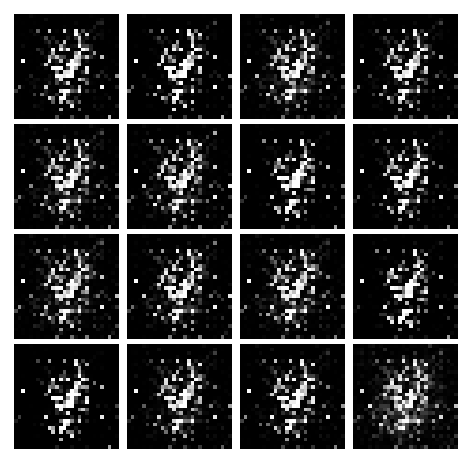


tensor([[-2.3435e-02, -4.6170e-04, -2.9110e+00,  ...,  2.2006e-01,
         -1.0364e+00,  5.6480e-01],
        [ 1.5024e+00,  4.4294e-01, -2.1024e+00,  ...,  2.6647e-01,
          1.4290e+00,  1.4250e+00],
        [ 1.0647e+00,  1.9252e-01, -5.5120e-01,  ...,  4.7670e-01,
          5.8635e-01,  1.6048e-01],
        ...,
        [ 1.0282e+00, -5.6570e-01, -1.3272e+00,  ...,  4.7985e-01,
          4.4493e-01,  1.4121e-01],
        [ 1.7307e+00,  1.5331e-01, -1.6661e+00,  ..., -7.0352e-01,
          1.2482e+00,  1.2209e+00],
        [ 1.0773e+00,  2.5075e-01, -9.6503e-01,  ...,  2.1687e-01,
          2.4457e-02, -6.3506e-01]], device='cuda:0', grad_fn=<MulBackward0>) tensor([119.1497,  64.1902, 221.8876, 140.0566, 150.0594, 254.5717,  87.2140,
        135.7929, 128.5195,  74.6212, 101.3917,  75.2848,  93.6244, 128.1173,
        113.8246, 116.5104,  73.1651,  87.2635, 227.0255,  96.1530, 116.2086,
        167.4926,  62.1182,  69.8928, 129.6269,  93.1146,  78.8246, 204.3078,
        214.57

       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 61.2173, 146.7811, 124.7866,  77.5091,  63.1768, 126.3510, 191.4724,
        109.9442,  59.4408, 147.8280,  96.2287, 175.9209, 353.4256,  55.0980,
        151.6997,  67.6651, 220.9164,  72.0437, 152.3088, 112.4162,  59.4753,
         96.2841, 144.5447,  50.7410, 113.3193,  79.1956, 169.2324, 143.5172,
        146.6186, 139.9938, 206.7124, 132.4197,  54.5181, 151.9549, 104.8728,
         73.7373, 120.1358,  54.2566,  56.4504,  54.2743, 203.7663, 247.9062,
        251.6133, 156.3318,  78.5298, 198.6395, 229.5982,  82.3760, 108.5682,
        260.0455, 115.0202, 157.6572,  99.3065, 146.6415, 138.5012,  92.3298,
         74.3431, 106.4734, 103.3351,  67.1796,  64.9942,  56.4872, 169.0424,
        107.4077, 120.1123,  45.0783, 107.4462, 200.7620,  76.8537, 105.4693,
         75.7456,  84.4922,  49.7784, 152.4630,  78.8250,  53.3879, 182.0091,
         66.3241,  67.5056, 122.2861,  66.2948, 172.2246,  41.7822,  49.5332,
         60.2640

       device='cuda:0', grad_fn=<NormBackward1>) tensor([0.1421, 0.1326, 0.1314, 0.1426, 0.1485, 0.1660, 0.1326, 0.1328, 0.1371,
        0.1390, 0.1606, 0.1455, 0.1594, 0.1261, 0.1335, 0.1490, 0.1295, 0.1858,
        0.1308, 0.1381, 0.1284, 0.1393, 0.1586, 0.1547, 0.1542, 0.1623, 0.1654,
        0.1825, 0.1395, 0.1524, 0.1429, 0.1737, 0.1308, 0.1426, 0.1261, 0.1482,
        0.1467, 0.1510, 0.1481, 0.1309, 0.1444, 0.1833, 0.1546, 0.1456, 0.1662,
        0.1885, 0.1360, 0.1372, 0.1376, 0.1370, 0.1715, 0.1544, 0.1361, 0.1520,
        0.1448, 0.1362, 0.1423, 0.1365, 0.1516, 0.1393, 0.1281, 0.1606, 0.1436,
        0.1425, 0.1459, 0.1699, 0.1643, 0.1784, 0.1348, 0.1269, 0.1493, 0.1367,
        0.1635, 0.1555, 0.1565, 0.1448, 0.1472, 0.1320, 0.1424, 0.1301, 0.1448,
        0.1465, 0.1261, 0.1299, 0.1312, 0.1513, 0.1305, 0.1419, 0.1869, 0.1556,
        0.1392, 0.1449, 0.1350, 0.1478, 0.1314, 0.1449], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-0.5479,  0.1593, -0.2632,  ...,  0.5

       grad_fn=<AddBackward0>)
tensor([[-1.9278, -0.9573,  0.4196,  ...,  1.2180, -0.5812,  0.3779],
        [-2.0534, -0.5757,  0.8510,  ...,  0.8126,  0.0380,  0.7474],
        [-2.2421,  0.2740,  0.7087,  ...,  0.1401, -0.4681, -0.2933],
        ...,
        [-1.8473, -0.8692, -0.1454,  ...,  1.3501,  0.0967,  0.4241],
        [-1.3017, -0.7857,  0.1491,  ...,  0.7113, -1.4398,  0.4063],
        [-1.1147,  0.1819,  0.8174,  ...,  0.3147,  1.0299, -0.2570]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([173.8975,  93.2918,  58.6880,  94.3133, 193.2993, 104.4976,  73.3700,
        171.4445, 105.1781, 123.3913,  87.1304, 102.3723, 153.9822, 159.1694,
         71.5127,  59.7333, 109.4612, 115.6307,  80.8362,  68.1146,  56.3487,
         58.6836, 132.1192, 109.2586,  46.4824, 136.0590,  75.4297, 169.5972,
         63.5077,  79.2514, 142.7943,  59.7397,  77.4040,  50.3754,  61.2389,
         74.6505, 164.7158, 219.2284, 238.6404,  96.7904,  82.5033, 161.6260,
        171.9155, 1

       grad_fn=<NormBackward1>) tensor([0.1562, 0.2142, 0.1447, 0.1553, 0.1724, 0.1726, 0.1727, 0.1355, 0.1572,
        0.2427, 0.1632, 0.1854, 0.1786, 0.1840, 0.1673, 0.1661, 0.2236, 0.1565,
        0.1732, 0.1778, 0.1639, 0.1462, 0.1444, 0.1665, 0.1420, 0.1696, 0.2323,
        0.1743, 0.1438, 0.2010, 0.2039, 0.2178, 0.1756, 0.1558, 0.1606, 0.1550,
        0.1949, 0.1528, 0.1445, 0.1452, 0.2393, 0.1780, 0.1435, 0.2029, 0.1976,
        0.1461, 0.1802, 0.1885, 0.1695, 0.1685, 0.1412, 0.1543, 0.1539, 0.2157,
        0.1521, 0.1815, 0.1483, 0.1911, 0.1644, 0.1649, 0.1594, 0.1433, 0.1612,
        0.1765, 0.1861, 0.1343, 0.1772, 0.1644, 0.1976, 0.1617, 0.1888, 0.1641,
        0.1572, 0.1936, 0.1557, 0.1409, 0.1610, 0.1637, 0.1525, 0.1689, 0.1617,
        0.1836, 0.1689, 0.1352, 0.1488, 0.1629, 0.1809, 0.1518, 0.1736, 0.1938,
        0.1413, 0.1850, 0.2161, 0.1511, 0.2057, 0.1565], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-0.0898, -0.9205, -0.1022,  ...,  0.2695, -0.7591,  0.

       grad_fn=<AddBackward0>)
tensor([[ 0.3329,  0.5177, -0.2482,  ..., -0.4984, -0.0742, -0.4357],
        [ 0.1400,  0.5775,  0.4661,  ..., -1.2866, -0.3282, -0.5159],
        [ 0.1461,  0.8600, -0.0501,  ..., -1.1194, -0.4775, -0.8833],
        ...,
        [ 0.3053,  0.6823, -0.5191,  ..., -0.6546, -0.3551, -0.2627],
        [ 0.3901,  0.5344, -0.5014,  ..., -0.8010, -0.9327, -0.7354],
        [ 0.2123,  0.7402,  0.3615,  ..., -0.8398, -0.4889, -0.5210]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 28.8790,  69.7693,  42.6843,  26.0545,  78.1913, 105.9281,  57.8465,
         52.8724,  83.2398,  45.4637,  54.5799, 112.4800,  61.1155,  27.6104,
         84.5289,  81.4451,  58.8216,  78.1482,  30.9794,  35.1875,  56.1687,
         40.6087,  36.0453, 119.6977,  71.0067,  35.7579,  33.3234, 108.0138,
         36.9969,  75.5704,  37.6143,  28.9893,  28.1158,  35.0328,  21.1897,
         32.7745,  40.8887,  56.4595,  67.0552,  85.9141,  80.9738,  34.3532,
         43.3143,  

       grad_fn=<NormBackward1>) tensor([0.1376, 0.1732, 0.1487, 0.1480, 0.1450, 0.1839, 0.2117, 0.1464, 0.1592,
        0.1716, 0.2081, 0.2020, 0.2171, 0.1338, 0.2407, 0.1870, 0.1599, 0.2399,
        0.1383, 0.1464, 0.2287, 0.1603, 0.1377, 0.2164, 0.2199, 0.1750, 0.1481,
        0.1803, 0.1432, 0.2506, 0.1661, 0.1466, 0.1531, 0.1405, 0.1316, 0.2105,
        0.1427, 0.2211, 0.1377, 0.2064, 0.1940, 0.1583, 0.1408, 0.1487, 0.1363,
        0.2119, 0.1994, 0.1608, 0.1548, 0.1883, 0.1727, 0.1982, 0.1524, 0.1424,
        0.1924, 0.1692, 0.1408, 0.1486, 0.2097, 0.1729, 0.2041, 0.1415, 0.1985,
        0.1773, 0.1389, 0.1667, 0.2079, 0.1552, 0.1594, 0.1380, 0.2252, 0.1827,
        0.1617, 0.2242, 0.2061, 0.1590, 0.1631, 0.1882, 0.1555, 0.1940, 0.1436,
        0.1672, 0.1709, 0.1874, 0.2766, 0.1605, 0.2001, 0.1591, 0.1845, 0.2224,
        0.1739, 0.1659, 0.1607, 0.2645, 0.1904, 0.1486], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 0.1946,  0.6787, -0.0436,  ..., -0.4881, -0.1685, -0.

       grad_fn=<AddBackward0>)
tensor([[ 0.3676,  0.0834,  0.2267,  ...,  0.1242,  1.9604,  0.7475],
        [ 1.0107,  0.0719,  0.6436,  ...,  0.2184,  1.2809, -0.1402],
        [ 0.3751,  0.4751, -0.3971,  ...,  0.8096,  1.9729,  0.0799],
        ...,
        [ 0.4233, -0.1797,  0.3644,  ...,  0.4896,  0.6167,  0.8715],
        [ 0.8873, -0.0850,  0.4930,  ...,  0.4687,  1.7916, -0.0958],
        [ 0.3787, -0.3896,  0.0744,  ..., -0.6992,  0.5923, -0.0897]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 71.8922,  45.6331,  43.5447,  35.1324,  58.1902,  41.9242,  55.7311,
         42.9887, 103.7987,  77.0014,  57.7083, 109.9226,  93.2886,  79.6652,
         53.2720,  51.2118,  74.5118,  67.0201,  60.3208,  48.4144,  58.2368,
         55.8508,  58.8316, 120.2043,  40.6519, 117.2847, 170.3362,  73.5015,
         80.2284,  81.6707,  92.8901, 137.9144, 103.4917,  44.5038,  58.7883,
         62.5188,  64.7468,  73.6121,  60.1023,  56.3897,  97.6204,  93.1600,
         50.9126,  

       grad_fn=<NormBackward1>) tensor([0.2323, 0.1660, 0.2100, 0.2036, 0.1714, 0.1772, 0.1827, 0.1765, 0.1604,
        0.2392, 0.1720, 0.2199, 0.1752, 0.1966, 0.1398, 0.1510, 0.1984, 0.2231,
        0.1795, 0.2092, 0.1787, 0.1621, 0.1927, 0.2415, 0.1600, 0.1824, 0.2699,
        0.1413, 0.1836, 0.1983, 0.1656, 0.3306, 0.1985, 0.1758, 0.1483, 0.1559,
        0.2062, 0.2432, 0.1735, 0.1752, 0.1507, 0.1648, 0.2050, 0.2113, 0.1679,
        0.1715, 0.1744, 0.1710, 0.1600, 0.1913, 0.1841, 0.1817, 0.1631, 0.2059,
        0.1846, 0.1790, 0.1550, 0.2643, 0.2525, 0.1414, 0.1907, 0.1784, 0.1497,
        0.1556, 0.1925, 0.1477, 0.1716, 0.2207, 0.1733, 0.1571, 0.1757, 0.1857,
        0.2062, 0.2721, 0.1853, 0.1427, 0.1646, 0.1874, 0.1614, 0.2551, 0.2154,
        0.1490, 0.2047, 0.2769, 0.1660, 0.1597, 0.1758, 0.1639, 0.1701, 0.1513,
        0.1455, 0.1432, 0.2152, 0.2271, 0.2813, 0.1513], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 1.3296,  0.0883,  2.3904,  ..., -2.5308,  0.4713,  0.

       grad_fn=<AddBackward0>)
tensor([[ 0.0635,  0.0023,  1.0447,  ...,  0.6960, -0.8891,  0.3804],
        [ 0.2621,  0.5729,  1.2984,  ..., -0.1327, -0.7772,  0.2153],
        [ 0.0812,  0.9815,  0.7924,  ...,  0.0045, -0.1618,  0.0252],
        ...,
        [ 0.4142,  0.0034,  0.1520,  ...,  0.4193,  0.1131, -0.3929],
        [ 0.6519,  0.5304,  1.0382,  ...,  0.1038,  0.2046,  0.6244],
        [ 0.4545,  0.0501,  0.2763,  ..., -0.1684, -0.3653,  0.4884]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 41.4535,  48.9698,  72.8246,  56.5814,  38.0669,  60.0040,  72.7071,
         40.0159,  70.8722,  46.0055,  41.8447,  89.9243,  72.6388,  44.8607,
         68.0957,  87.7241,  87.1674,  56.2614,  52.1939,  61.4134,  47.6019,
         44.5725,  46.8918,  82.6749,  79.9574,  49.5232,  51.5887,  46.5817,
         44.7591,  79.0303,  69.3305,  64.1077,  98.8599,  31.7912,  78.5523,
         63.3146,  55.8421,  51.6234,  60.4872, 107.6306,  80.0013,  76.3312,
         69.1388,  

       grad_fn=<NormBackward1>) tensor([0.2821, 0.1698, 0.1595, 0.2898, 0.1937, 0.1985, 0.1945, 0.1906, 0.2254,
        0.2385, 0.1502, 0.1792, 0.1858, 0.1706, 0.1781, 0.2021, 0.2168, 0.1583,
        0.2331, 0.1653, 0.2782, 0.2062, 0.2391, 0.2112, 0.2022, 0.2372, 0.2095,
        0.1715, 0.2308, 0.1621, 0.1788, 0.2469, 0.1912, 0.1618, 0.2670, 0.2433,
        0.2470, 0.1894, 0.1642, 0.3313, 0.1754, 0.1926, 0.2005, 0.1929, 0.2784,
        0.2044, 0.1663, 0.2159, 0.1526, 0.1848, 0.3353, 0.1683, 0.2150, 0.2409,
        0.1675, 0.1770, 0.2628, 0.2439, 0.1730, 0.2309, 0.2618, 0.3445, 0.1570,
        0.1748, 0.1577, 0.1560, 0.1669, 0.2525, 0.1809, 0.1493, 0.1854, 0.1729,
        0.3986, 0.2591, 0.3537, 0.1674, 0.2959, 0.1941, 0.2318, 0.1756, 0.1762,
        0.1822, 0.2229, 0.3166, 0.1977, 0.2494, 0.1826, 0.2371, 0.2719, 0.2021,
        0.1900, 0.1709, 0.2282, 0.3396, 0.3503, 0.1992], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-2.4566, -2.3156,  0.4297,  ...,  1.2048, -2.5199,  0.

       grad_fn=<AddBackward0>)
tensor([[-1.3987, -0.7938, -0.7334,  ...,  0.8192, -1.1950,  0.3684],
        [-1.5221, -0.4779, -1.0254,  ...,  0.8413, -1.8073, -0.9735],
        [-1.3669, -0.8662, -0.1763,  ..., -0.1809, -1.1362, -0.6081],
        ...,
        [-1.3303,  0.0870, -1.5996,  ...,  1.0349,  0.4273, -0.5062],
        [-1.5957, -1.5149, -0.5373,  ...,  0.4743, -1.4759, -0.1518],
        [-1.9075, -1.4420, -0.8281,  ...,  1.2676, -1.7290,  0.0688]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([114.7721, 104.5978,  72.5776,  41.7095,  42.9376,  55.6889,  62.0754,
        122.6586, 113.9661,  47.4130,  47.5320, 196.6613,  60.5738,  91.5441,
         75.4497,  64.2506, 124.7619,  80.4615, 131.0208,  50.0337,  56.6329,
         41.7073,  59.0454, 179.8141, 119.8469,  98.3459, 202.2425,  91.4533,
         93.8570,  62.4459, 102.2181, 139.4884, 102.0509,  43.8275,  77.6773,
        143.9825,  41.6755,  41.1010, 122.2808,  69.0946,  63.6055,  42.9177,
        111.8871,  

       grad_fn=<NormBackward1>) tensor([0.1511, 0.2189, 0.1975, 0.2508, 0.2086, 0.2785, 0.1590, 0.1624, 0.1936,
        0.1765, 0.1688, 0.2766, 0.1780, 0.2746, 0.2585, 0.1671, 0.1857, 0.1712,
        0.1507, 0.1903, 0.2636, 0.1719, 0.1504, 0.2663, 0.2294, 0.2173, 0.2330,
        0.1673, 0.1692, 0.2418, 0.1705, 0.1928, 0.2059, 0.1800, 0.2699, 0.2919,
        0.1580, 0.2019, 0.1521, 0.2715, 0.2099, 0.1800, 0.1630, 0.1936, 0.2793,
        0.1795, 0.1883, 0.2265, 0.1944, 0.1897, 0.2136, 0.2888, 0.1559, 0.2247,
        0.2131, 0.2160, 0.1596, 0.1715, 0.2459, 0.2406, 0.2524, 0.2136, 0.2610,
        0.1621, 0.2328, 0.2344, 0.2304, 0.1716, 0.1861, 0.2470, 0.1689, 0.2539,
        0.2439, 0.1824, 0.1845, 0.1516, 0.3165, 0.1701, 0.2425, 0.2127, 0.2091,
        0.1499, 0.1880, 0.2116, 0.1623, 0.2791, 0.2356, 0.1545, 0.1781, 0.2004,
        0.2248, 0.1828, 0.1692, 0.1779, 0.1710, 0.1752], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 0.9856, -2.0108, -0.4429,  ..., -1.5469, -0.3396,  2.

       grad_fn=<AddBackward0>)
tensor([[ 1.8306,  1.5969,  0.2741,  ..., -0.2924,  0.8210,  0.3184],
        [ 1.1818,  1.6611, -0.1201,  ..., -0.9003,  0.0079,  0.6166],
        [ 1.8148,  1.5939,  0.3485,  ..., -0.3748,  0.4043, -0.5128],
        ...,
        [ 1.0518,  0.9410,  0.4489,  ..., -0.6566,  0.1865, -0.7988],
        [ 1.4316,  1.8033, -0.6879,  ..., -0.6810,  1.0198,  0.1294],
        [ 1.2389,  1.9005,  0.0547,  ..., -0.2126,  0.4863, -0.7449]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([158.9957, 170.3207,  51.2128,  90.3491, 124.2730,  57.0897, 113.6983,
        141.5979,  51.0877,  99.2656, 124.4388,  89.9775, 165.1071,  54.9451,
         61.6800,  65.6560,  64.2326,  61.7420,  59.3991, 109.6636, 200.0063,
        110.0306, 131.2971,  72.2531,  77.9525, 119.6969, 135.5245, 179.4722,
         89.4578, 125.0461,  95.2770, 171.1934,  87.3106,  74.2349,  64.7678,
        101.0136,  54.0713,  66.1109,  93.1890,  67.1188,  97.3698, 113.8033,
         82.5209,  

       device='cuda:0', grad_fn=<MulBackward0>) tensor([117.1788, 278.5157, 222.8659, 191.6195, 127.5580, 101.4973,  96.4539,
        188.9446, 139.9405, 177.3619, 129.0634, 241.1783, 443.1473, 163.6717,
        178.9413, 223.7261,  82.5071, 113.3861, 135.6065, 137.9306, 391.2239,
        101.2249, 183.8831, 201.4672, 287.8294, 210.3806, 224.6526, 138.2653,
        180.8204, 186.4157, 191.9059, 222.3760, 224.2841, 183.8027, 185.5380,
        373.6668, 211.6246, 295.0089, 150.9034, 133.2450, 307.6438, 327.8204,
        103.2774,  99.4941, 156.4420, 165.2866, 376.3473, 114.2206,  83.2060,
        156.9324, 198.8794, 193.0350, 176.7496, 176.5462, 189.7715,  86.9173,
        127.2607, 242.3427, 123.9375, 193.9837, 143.7763,  76.5923, 157.0645,
        183.8203, 117.3826, 163.2104,  84.3943, 200.3432, 192.7621, 219.1806,
        209.9478, 107.7934, 160.0782, 227.8459, 142.3762, 129.4533, 191.8388,
        432.3076, 251.5056, 188.8772, 345.9789, 268.4594, 216.9355, 134.8892,
        198.6421

       grad_fn=<NormBackward1>) tensor([0.1914, 0.2146, 0.2191, 0.3775, 0.3234, 0.2412, 0.2044, 0.2142, 0.2855,
        0.2233, 0.1750, 0.3452, 0.2894, 0.3173, 0.3069, 0.2522, 0.1729, 0.1859,
        0.2363, 0.3022, 0.5146, 0.1672, 0.2152, 0.3845, 0.2446, 0.2306, 0.2511,
        0.3083, 0.2229, 0.3093, 0.2761, 0.1778, 0.2150, 0.2967, 0.3132, 0.4433,
        0.2307, 0.2890, 0.2044, 0.2470, 0.2969, 0.2473, 0.2056, 0.2390, 0.3138,
        0.1853, 0.2911, 0.2026, 0.1895, 0.3362, 0.2226, 0.3839, 0.2166, 0.3362,
        0.3029, 0.2401, 0.2123, 0.2030, 0.2912, 0.2834, 0.1997, 0.1703, 0.2713,
        0.2660, 0.2357, 0.3484, 0.3055, 0.2804, 0.2134, 0.3794, 0.2436, 0.1838,
        0.3045, 0.2700, 0.1788, 0.2099, 0.3064, 0.2863, 0.3334, 0.3125, 0.3038,
        0.2708, 0.2095, 0.1884, 0.3714, 0.3149, 0.2320, 0.1946, 0.2439, 0.2813,
        0.3205, 0.3269, 0.1989, 0.3634, 0.2231, 0.2372], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-1.6145, -1.7491,  1.2905,  ...,  0.5160, -1.0006,  0.

       grad_fn=<AddBackward0>)
tensor([[-1.7800, -2.1380, -1.3229,  ...,  3.1563, -0.3345,  1.4882],
        [ 0.0762, -1.4886,  0.9782,  ...,  1.3393, -0.7730, -2.3259],
        [-1.2266, -2.2174,  1.5788,  ..., -1.2334, -3.1357, -0.4759],
        ...,
        [-1.9378, -0.2906,  1.5921,  ...,  0.5290, -1.8908, -1.7912],
        [-0.1160, -0.7200,  0.9548,  ..., -1.4795, -0.3940, -2.1778],
        [-1.1460, -1.1061, -0.0079,  ...,  1.5880, -0.6858,  0.0258]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([177.1673, 202.2604, 117.3028, 181.5825, 102.7380, 153.9556,  73.8517,
        105.6670, 184.9639,  96.2508, 104.5430,  92.9275, 143.9323, 160.4313,
         88.7775, 117.7358,  75.9129, 195.5164,  84.1510, 136.3336, 156.1997,
        151.5137,  90.2338, 136.2435,  82.1063, 136.8316, 411.7468, 288.9543,
         79.4030,  97.4160, 243.2977, 250.4889, 271.1092,  88.4252, 114.6768,
        222.9211, 197.6407, 171.3754, 258.3637, 122.2094, 317.6660, 190.2059,
         71.2993,  

       grad_fn=<NormBackward1>) tensor([0.2306, 0.4383, 0.3307, 0.3048, 0.2265, 0.2281, 0.1920, 0.2900, 0.2862,
        0.1789, 0.2171, 0.2825, 0.3190, 0.2899, 0.3907, 0.1785, 0.2457, 0.3468,
        0.1897, 0.1796, 0.3674, 0.2292, 0.2857, 0.2895, 0.2636, 0.2366, 0.2585,
        0.2050, 0.2197, 0.2510, 0.3108, 0.2780, 0.2713, 0.2527, 0.2262, 0.2555,
        0.1940, 0.3932, 0.1694, 0.2750, 0.3645, 0.2361, 0.2026, 0.1757, 0.2841,
        0.2670, 0.3221, 0.3309, 0.1876, 0.1882, 0.2707, 0.2719, 0.2039, 0.2998,
        0.2662, 0.2083, 0.2051, 0.2554, 0.2580, 0.2138, 0.2935, 0.2083, 0.3846,
        0.2570, 0.1766, 0.1922, 0.2132, 0.2068, 0.2127, 0.2922, 0.1923, 0.2818,
        0.2204, 0.1836, 0.3076, 0.2229, 0.3019, 0.2979, 0.2396, 0.3081, 0.2572,
        0.2255, 0.3008, 0.2936, 0.3761, 0.3093, 0.3137, 0.2120, 0.3790, 0.2423,
        0.3214, 0.3440, 0.2332, 0.3784, 0.2881, 0.2368], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-2.3278, -9.7566, -3.0637,  ..., 10.5188, -4.9376,  6.

       grad_fn=<AddBackward0>)
tensor([[ 0.2253, -0.3190, -0.3089,  ...,  0.8416, -0.9972,  1.2336],
        [-0.0936, -0.5600, -0.8106,  ...,  0.0480, -1.0447,  0.0894],
        [ 0.5889, -0.1340, -1.0956,  ...,  0.6538, -1.0401,  0.5923],
        ...,
        [ 0.1575,  0.5208, -0.3421,  ...,  0.6985, -0.6794,  0.1040],
        [ 0.2143,  0.1364, -1.1531,  ...,  0.6359, -0.8384, -0.0466],
        [ 0.8324, -0.3695, -0.7345,  ...,  1.2031, -0.9435,  0.5649]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 65.9222,  48.4450,  76.6636,  43.2676, 225.4236, 117.6532,  70.2437,
         67.2754,  36.6272,  64.5642,  44.9834, 110.9260,  56.8747,  66.4261,
        175.0480,  50.9425,  45.5350,  61.0934,  53.5911,  79.9102,  51.3105,
         43.1466,  41.5680, 134.5550,  39.8790,  38.7461,  53.2695, 205.7644,
         40.7240,  88.0180,  99.5259, 111.9429,  73.0237, 118.8278,  42.8503,
         45.1619,  72.1340, 169.9031, 164.2849,  90.6888,  89.3858,  94.2300,
         48.4453,  

       grad_fn=<NormBackward1>) tensor([0.2101, 0.2803, 0.2985, 0.1674, 0.1767, 0.1825, 0.1705, 0.2296, 0.2005,
        0.1688, 0.2051, 0.1966, 0.1726, 0.1905, 0.1690, 0.1541, 0.2039, 0.3159,
        0.2459, 0.1763, 0.2445, 0.1457, 0.2811, 0.1738, 0.2263, 0.1942, 0.1557,
        0.2261, 0.1648, 0.1796, 0.2664, 0.1939, 0.1911, 0.1771, 0.1397, 0.1851,
        0.1646, 0.1894, 0.1750, 0.2312, 0.2245, 0.2222, 0.1593, 0.1962, 0.2377,
        0.2410, 0.2221, 0.2219, 0.1451, 0.1688, 0.2268, 0.1698, 0.2356, 0.2337,
        0.1687, 0.1899, 0.1709, 0.2049, 0.2027, 0.1517, 0.1901, 0.2078, 0.2809,
        0.2120, 0.1632, 0.1386, 0.2710, 0.1605, 0.1608, 0.1522, 0.1677, 0.1658,
        0.1568, 0.1596, 0.2059, 0.1724, 0.1580, 0.2305, 0.1668, 0.2567, 0.2283,
        0.2056, 0.1717, 0.1894, 0.2468, 0.1973, 0.1698, 0.2061, 0.2909, 0.1828,
        0.1757, 0.1995, 0.1659, 0.2325, 0.1990, 0.2456], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 1.8724,  2.6612,  3.2476,  ..., -3.6338,  2.7646, -0.

       grad_fn=<AddBackward0>)
tensor([[ 0.8590,  0.9984, -0.4974,  ..., -0.1475,  1.3846,  1.0299],
        [ 0.4765,  0.7841,  0.6070,  ..., -0.4951,  1.6590, -0.2857],
        [ 0.5593,  0.4391, -0.2560,  ...,  0.8864,  0.5543,  0.8980],
        ...,
        [ 0.4298,  0.7264, -0.3368,  ...,  1.0875,  1.0640,  1.3251],
        [ 0.2547,  1.2808,  0.0096,  ...,  0.6780,  1.6891,  0.6993],
        [ 0.5745,  0.8033, -0.4952,  ...,  0.4604,  0.8932,  1.4782]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 68.7170,  86.4052,  58.1783,  48.5023,  70.4091,  44.1081,  40.7975,
        144.2435,  56.6632,  65.4833,  51.8582,  77.1763,  78.6498, 104.2462,
         59.6357, 141.6063,  44.9633,  57.9749,  55.3682,  53.3799,  89.8200,
         84.3249,  56.2717, 172.3016, 126.0900,  53.9283, 147.9272,  44.2229,
         63.0449,  90.5845,  53.8961,  62.7204,  81.1661,  69.4357,  35.2722,
        129.5363,  65.6385,  86.3096,  49.5936,  43.9513,  74.6407,  50.6867,
         50.8455,  

       grad_fn=<NormBackward1>) tensor([0.2004, 0.2223, 0.1928, 0.1478, 0.1679, 0.1564, 0.1972, 0.1745, 0.1919,
        0.1521, 0.1456, 0.1811, 0.1818, 0.1903, 0.1536, 0.1876, 0.1785, 0.1490,
        0.1778, 0.1929, 0.2354, 0.1541, 0.2179, 0.2109, 0.1722, 0.1816, 0.1575,
        0.1620, 0.2046, 0.2421, 0.1869, 0.1921, 0.1603, 0.2416, 0.1704, 0.1759,
        0.1707, 0.1929, 0.1464, 0.1485, 0.1715, 0.1600, 0.1465, 0.1610, 0.1596,
        0.1563, 0.1726, 0.1828, 0.2070, 0.1624, 0.2018, 0.1650, 0.1790, 0.1566,
        0.1705, 0.1533, 0.1531, 0.1702, 0.2153, 0.2081, 0.1762, 0.1650, 0.1614,
        0.1528, 0.1656, 0.2048, 0.1525, 0.1914, 0.1822, 0.1702, 0.1913, 0.1673,
        0.1736, 0.2127, 0.1446, 0.2103, 0.1980, 0.2737, 0.2132, 0.1890, 0.2067,
        0.1494, 0.2022, 0.2290, 0.2372, 0.2102, 0.1626, 0.1949, 0.1829, 0.1692,
        0.1788, 0.2310, 0.2213, 0.2213, 0.2722, 0.1999], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 1.2663,  2.3844,  1.0304,  ..., -1.2095,  1.2485, -1.

       grad_fn=<AddBackward0>)
tensor([[ 0.0486, -0.2610,  0.4918,  ..., -0.9151,  0.0080,  0.4755],
        [ 0.1340,  0.4651,  0.4194,  ..., -1.0677,  0.6989,  0.4137],
        [-1.3785, -0.2223, -0.1910,  ..., -0.1276, -0.8126,  5.3026],
        ...,
        [-1.1731, -1.3474,  0.0443,  ..., -0.7786,  0.8406,  2.7894],
        [-0.9560, -0.4860,  1.3737,  ..., -1.4301,  0.5869,  1.8186],
        [ 0.1533, -0.9769,  0.3524,  ..., -0.9893, -0.3474,  0.9119]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 58.1998,  89.0057,  62.1062, 135.1231, 117.5278, 125.3446, 133.0088,
         66.9294,  65.7134, 143.4703,  70.5916,  99.8160, 119.1092,  65.7424,
         79.3366, 107.7777,  95.4907,  80.8570, 173.4388,  81.0882, 148.5320,
        105.5124,  81.6215,  74.7976,  70.7947,  95.8793,  85.0620,  86.4448,
        168.4222, 120.8925, 132.6535, 145.8535, 189.9824, 173.2382,  56.3172,
        114.0786,  98.1137,  77.2268,  62.6847,  79.4447, 124.3777,  82.9545,
        116.1123, 1

       grad_fn=<NormBackward1>) tensor([0.2174, 0.2374, 0.1707, 0.1646, 0.1589, 0.1933, 0.1581, 0.1921, 0.2722,
        0.1789, 0.1731, 0.1887, 0.1893, 0.2074, 0.1838, 0.2223, 0.1689, 0.1769,
        0.1731, 0.2107, 0.2778, 0.2732, 0.1638, 0.2833, 0.2258, 0.1710, 0.2768,
        0.1512, 0.1783, 0.2588, 0.1893, 0.1737, 0.1845, 0.1760, 0.1459, 0.3367,
        0.1842, 0.1657, 0.1864, 0.2066, 0.2759, 0.1717, 0.2088, 0.1775, 0.1753,
        0.1449, 0.1974, 0.2051, 0.2796, 0.1690, 0.1602, 0.2176, 0.2094, 0.1530,
        0.1968, 0.1908, 0.1870, 0.1790, 0.2233, 0.1840, 0.2045, 0.1567, 0.1528,
        0.1761, 0.1516, 0.2385, 0.2348, 0.1730, 0.2420, 0.2140, 0.2456, 0.1636,
        0.1575, 0.1565, 0.1921, 0.2425, 0.2760, 0.1659, 0.2708, 0.2042, 0.1520,
        0.2398, 0.2167, 0.2758, 0.1816, 0.1627, 0.1798, 0.1644, 0.2111, 0.1992,
        0.1658, 0.1806, 0.1975, 0.2582, 0.2136, 0.2011], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-0.6192, -0.9726,  0.3085,  ..., -0.6740, -0.9957,  0.

       grad_fn=<AddBackward0>)
tensor([[ 0.2016,  0.0948, -0.8029,  ...,  1.2719, -0.2710, -0.2401],
        [-0.0166,  0.3159, -1.0619,  ...,  1.5889, -0.3580, -0.0602],
        [ 0.8792, -0.1435, -0.7562,  ...,  1.1600,  0.0857, -0.3377],
        ...,
        [-0.4808, -0.0768, -1.0054,  ...,  1.6026, -0.5698, -0.4962],
        [ 0.4694,  0.0545, -0.1669,  ...,  1.3153, -0.5848, -0.3240],
        [ 0.4221,  0.0891, -0.7137,  ...,  1.8396, -0.0239, -0.2347]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 29.8120,  37.5361,  79.9278,  29.6037, 102.9216,  34.1403,  80.6977,
         32.9263,  75.0498,  34.0124,  28.3309,  34.3713,  62.7580,  25.0085,
         39.8006,  26.0404,  70.7487,  63.6255,  66.1686,  49.8040, 115.7307,
         47.6642,  28.5071,  30.1216,  28.3148,  43.2800,  59.7041, 108.0639,
         59.7065,  35.3503,  25.9419,  43.8180,  27.9792,  73.8116,  43.6060,
        135.8940,  52.9718,  46.4332,  64.4525,  97.3242,  98.0411,  63.0237,
         27.6831,  

       device='cuda:0', grad_fn=<NormBackward1>) tensor([0.1315, 0.1422, 0.1864, 0.1267, 0.1630, 0.1749, 0.1760, 0.1506, 0.1869,
        0.1576, 0.1425, 0.1766, 0.1645, 0.1369, 0.1380, 0.1563, 0.1889, 0.1983,
        0.1411, 0.1626, 0.1704, 0.1344, 0.1407, 0.1531, 0.1751, 0.1681, 0.1636,
        0.1687, 0.1363, 0.1464, 0.1818, 0.1416, 0.1480, 0.1650, 0.1379, 0.1874,
        0.1784, 0.1520, 0.1398, 0.1682, 0.1873, 0.1361, 0.1590, 0.1483, 0.1345,
        0.1613, 0.1645, 0.1393, 0.1350, 0.1785, 0.1452, 0.1396, 0.1464, 0.1333,
        0.1312, 0.1560, 0.1390, 0.1431, 0.1585, 0.1424, 0.1324, 0.1573, 0.1334,
        0.1523, 0.1327, 0.1526, 0.1621, 0.1501, 0.1422, 0.1471, 0.1545, 0.1789,
        0.1391, 0.1809, 0.1363, 0.1573, 0.1313, 0.1444, 0.1719, 0.1299, 0.1502,
        0.1451, 0.1890, 0.1326, 0.1749, 0.1412, 0.1463, 0.1272, 0.1445, 0.1618,
        0.1504, 0.1350, 0.1436, 0.1771, 0.1410, 0.1470], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 0.8764,  0.6967, -0.5309,  ...,  0.3

       grad_fn=<AddBackward0>)
tensor([[-0.0444, -0.0597,  0.6586,  ..., -1.3755, -0.3767, -0.2754],
        [ 0.4752, -0.4542,  0.2966,  ..., -1.0557, -0.2595,  0.5432],
        [ 0.6240,  0.4865,  0.0839,  ..., -0.5672,  0.2390,  0.2028],
        ...,
        [ 0.8425,  2.5314,  2.1384,  ..., -5.1265, -0.4014, -2.4180],
        [ 0.4218,  1.0335,  0.1042,  ..., -1.9197,  0.1990, -0.4486],
        [ 0.3213,  0.0414,  0.1492,  ..., -0.6460, -0.3921,  0.4696]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 79.1700,  79.4847,  58.3494,  92.6348,  69.1444,  85.2058,  55.6895,
        105.0631,  56.3611,  93.3381,  84.6308,  69.4466,  88.6127,  89.9408,
         55.2824,  82.2713,  68.9336, 143.8904,  65.2868, 125.5105, 203.1497,
        107.0598,  68.9324,  80.8471, 113.1785, 110.3631,  59.8070, 115.5595,
         65.6089,  90.4152,  69.1332,  57.9169,  72.4076,  54.9263,  41.2470,
        112.9057,  94.5961,  56.4274,  53.7577,  56.1375,  63.7127,  59.3347,
         53.9187, 1

       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 52.0453,  99.6135,  40.5447,  56.0319,  44.9733,  37.8164,  37.5000,
         45.5348,  50.4555, 101.1158,  37.7401,  93.5981, 110.3424,  53.5734,
         83.2982,  74.5697,  71.5096,  66.2209,  65.2945, 103.5138, 101.6593,
         61.3531,  68.7158,  59.6833,  51.2714,  52.4021,  50.3168,  66.5464,
         36.2048,  66.1910,  54.7820,  59.7184,  45.1464,  36.0389,  38.0850,
         60.3714,  41.0812,  54.0245,  47.1154,  37.4787,  45.4998,  52.2964,
         55.4352, 107.5431,  46.9142,  55.1791, 109.1671, 105.5856,  40.8381,
         64.8946,  42.8961,  66.7174,  67.1208,  60.5718,  58.3360, 113.3994,
         41.7870,  69.7467,  46.8834,  33.9922,  38.3904,  54.2654,  48.9851,
         69.2826,  41.6205,  45.8075,  84.6383,  87.9781, 105.8032,  82.3622,
        108.6538,  49.6984,  63.8243,  53.9878,  58.0991,  61.7717,  59.7366,
        109.2719,  60.5950,  39.8181,  93.7697,  46.9045,  56.9490,  72.3037,
         37.9474

       grad_fn=<NormBackward1>) tensor([0.1917, 0.2128, 0.1466, 0.1919, 0.1582, 0.1627, 0.1490, 0.1618, 0.1597,
        0.2073, 0.1525, 0.1773, 0.1894, 0.2202, 0.1935, 0.1716, 0.1470, 0.2080,
        0.1754, 0.1931, 0.1577, 0.1741, 0.2273, 0.1897, 0.1544, 0.1548, 0.1604,
        0.1652, 0.1763, 0.2097, 0.1608, 0.1703, 0.1991, 0.1702, 0.2042, 0.1719,
        0.1449, 0.1781, 0.1491, 0.1615, 0.1607, 0.1956, 0.2018, 0.1921, 0.1667,
        0.1770, 0.2141, 0.2267, 0.1944, 0.1510, 0.1535, 0.2023, 0.2178, 0.1574,
        0.1801, 0.1701, 0.1546, 0.1658, 0.1487, 0.1849, 0.1597, 0.1691, 0.1454,
        0.1804, 0.1473, 0.1687, 0.2456, 0.2229, 0.2382, 0.1529, 0.2358, 0.1926,
        0.2188, 0.1830, 0.2240, 0.2048, 0.1752, 0.2708, 0.1626, 0.1511, 0.2529,
        0.1652, 0.1693, 0.2241, 0.1439, 0.1693, 0.2273, 0.1508, 0.1837, 0.1934,
        0.2181, 0.2250, 0.2232, 0.1613, 0.2326, 0.2449], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-4.4839e-01, -3.0769e-01,  1.7867e-01,  ...,  1.3447e-

       grad_fn=<AddBackward0>)
tensor([[-0.5760, -0.8483, -0.4812,  ...,  1.1940, -0.3850,  1.2453],
        [-1.1740, -0.8634,  0.1745,  ...,  1.1111, -0.3074,  1.1915],
        [-0.7940, -0.9853, -0.8448,  ...,  0.7443, -0.5442,  1.1645],
        ...,
        [-0.4535, -0.6791,  0.4587,  ...,  0.1191, -0.5150,  0.4667],
        [-0.7318, -1.0812,  0.1899,  ..., -0.1094, -0.3711,  0.6911],
        [-0.3880, -0.4577,  0.5136,  ..., -0.2669, -0.6334,  0.2089]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 72.7895,  88.3232,  57.7874,  81.8867,  58.6863,  53.8551,  46.9101,
         61.1748,  61.8898,  43.9629,  39.4398,  65.9526,  58.1140,  93.3664,
         40.9150,  77.3075,  40.6217,  84.2445,  69.0144,  63.1085,  69.8926,
         57.1785,  65.5353,  68.3888,  67.3205,  55.2610,  54.9408,  52.4620,
         51.3750,  89.6014,  66.9950,  50.5954, 100.2033,  32.0707,  67.7240,
         83.9445,  35.7421,  47.1959,  38.8009,  46.8957,  47.2313,  55.6511,
         64.1978,  

       grad_fn=<NormBackward1>) tensor([0.1655, 0.2025, 0.1838, 0.1529, 0.1707, 0.2027, 0.1969, 0.1931, 0.2202,
        0.1690, 0.1419, 0.1741, 0.2583, 0.1668, 0.2211, 0.1884, 0.1462, 0.1817,
        0.2625, 0.1567, 0.2037, 0.1784, 0.1581, 0.1919, 0.2026, 0.1509, 0.1765,
        0.2338, 0.2501, 0.1597, 0.1755, 0.1698, 0.1634, 0.1576, 0.1447, 0.2650,
        0.1827, 0.2198, 0.1799, 0.1924, 0.1579, 0.2108, 0.1532, 0.1576, 0.1790,
        0.1840, 0.2123, 0.2060, 0.1501, 0.1705, 0.1799, 0.1600, 0.2165, 0.1928,
        0.1932, 0.1541, 0.1558, 0.1940, 0.1538, 0.1806, 0.1519, 0.1983, 0.1759,
        0.2054, 0.1483, 0.2210, 0.1971, 0.2613, 0.1527, 0.2126, 0.1436, 0.1466,
        0.2067, 0.1821, 0.1962, 0.1853, 0.1944, 0.1988, 0.1861, 0.2117, 0.2786,
        0.1920, 0.1807, 0.1530, 0.2395, 0.1836, 0.1803, 0.1803, 0.1431, 0.2218,
        0.1941, 0.2006, 0.1527, 0.1991, 0.1499, 0.1823], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-0.4820, -0.5991,  0.1386,  ...,  0.1812,  0.0090,  0.

       grad_fn=<AddBackward0>)
tensor([[-6.6725e-01, -1.7887e+00, -2.9679e-01,  ...,  1.0356e-01,
         -8.9391e-01, -5.2653e-02],
        [-4.5957e-01, -7.6591e-04,  9.0314e-02,  ..., -8.4038e-01,
         -9.7904e-01, -3.7343e-01],
        [-6.6354e-01, -9.2110e-01, -7.5848e-01,  ..., -6.8712e-01,
         -1.9600e+00,  6.5357e-01],
        ...,
        [ 9.3345e-02, -1.6065e+00,  3.7323e-01,  ..., -2.1169e+00,
         -2.4406e-01,  1.3194e+00],
        [-1.6865e+00, -2.3733e+00, -1.9423e-01,  ..., -4.6446e-01,
         -2.2020e+00,  1.8692e+00],
        [-8.3136e-01, -1.7640e+00,  1.1778e+00,  ..., -1.6963e+00,
         -1.7577e+00,  1.2415e+00]], device='cuda:0', grad_fn=<MulBackward0>) tensor([ 87.4072, 138.0662,  54.6961,  82.2755, 100.8267, 143.7635, 132.5055,
         65.8162, 169.1058,  59.8967,  68.4257, 127.7907, 103.1209, 113.2256,
         61.8357,  66.2287,  71.5101,  79.5136,  92.1195,  79.0092, 115.1301,
        103.8647,  67.2488, 170.1896,  88.6386,  63.7261,  59.

       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 48.8279,  53.5449,  39.5610,  41.1007,  67.5231,  77.9916,  41.8052,
         52.8604,  41.3278,  55.7181,  40.3007,  66.0640, 149.5348,  45.6571,
         72.9145,  45.1057,  95.0152,  71.7134,  69.1025, 101.5203,  46.8045,
         78.0515,  44.8252,  61.8913,  87.8880,  83.0340,  54.1114, 163.1292,
         47.6856,  65.4103,  85.8942,  44.3438,  55.7296,  68.0166,  35.8141,
         41.8757,  50.4862,  43.0665,  91.8362,  73.3845,  35.1064, 154.4048,
         39.3578,  78.4860,  61.3595, 130.8239, 113.2099,  72.0033,  75.7804,
         94.0180, 143.7352,  41.4426,  83.3739,  57.2736, 100.8074,  49.9538,
         57.1680,  84.9341,  57.0686,  58.3894,  66.0220,  87.1083,  43.8020,
         42.5508, 116.7902, 101.5633,  73.7398, 159.9089,  49.2771,  56.8711,
         57.9677,  38.5164,  42.1786,  48.3734,  33.0892,  31.8689,  65.7956,
         66.5438,  61.6120,  43.0964,  83.5052,  60.4208,  35.4613, 148.9828,
         61.7415

       device='cuda:0', grad_fn=<NormBackward1>) tensor([0.1202, 0.1171, 0.1303, 0.1285, 0.1260, 0.1277, 0.1248, 0.1176, 0.1423,
        0.1562, 0.1265, 0.1472, 0.1547, 0.1243, 0.1175, 0.1400, 0.1294, 0.1169,
        0.1289, 0.1360, 0.1393, 0.1264, 0.1197, 0.1584, 0.1339, 0.1317, 0.1317,
        0.1384, 0.1186, 0.1201, 0.1427, 0.1351, 0.1287, 0.1196, 0.1239, 0.1916,
        0.1206, 0.1293, 0.1220, 0.1218, 0.1476, 0.1308, 0.1209, 0.1324, 0.1224,
        0.1206, 0.1381, 0.1270, 0.1523, 0.1254, 0.1265, 0.1414, 0.1191, 0.1269,
        0.1203, 0.1227, 0.1153, 0.1395, 0.1443, 0.1133, 0.1463, 0.1244, 0.1168,
        0.1188, 0.1361, 0.1199, 0.1255, 0.1429, 0.1232, 0.1291, 0.1160, 0.1431,
        0.1502, 0.1231, 0.1350, 0.1410, 0.1762, 0.1305, 0.1215, 0.1293, 0.1448,
        0.1470, 0.1225, 0.1319, 0.1404, 0.1243, 0.1347, 0.1133, 0.1407, 0.1339,
        0.1214, 0.1317, 0.1332, 0.1510, 0.1191, 0.1217], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[-0.4969, -0.0194, -0.5408,  ...,  0.6

       grad_fn=<AddBackward0>)
tensor([[-1.0395,  0.2586,  0.3030,  ...,  0.6965, -0.2293,  0.1987],
        [-0.4252,  0.0664, -0.1332,  ...,  0.9667, -0.0759,  0.3248],
        [-0.5842,  0.1744, -0.8744,  ...,  1.1119, -0.0243,  0.3235],
        ...,
        [-1.1350, -1.1483,  0.0708,  ...,  0.6247, -0.3280,  1.1303],
        [-0.9016,  0.1775, -0.0729,  ...,  0.5421, -0.1624, -0.4111],
        [-0.8998,  0.0037, -0.5011,  ...,  0.8838, -0.2829,  0.3998]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 80.8692,  38.0353,  39.4268,  33.8931,  98.8861,  88.8563,  24.3584,
         59.4133,  39.6376,  83.3279,  39.0365,  42.4307,  49.0220,  32.4277,
         33.0839,  48.8277,  34.9163,  46.4287,  48.6700,  34.3472,  46.1962,
         59.2013,  62.8360,  63.3021,  39.4781,  97.3506,  47.7054,  86.7011,
         47.7460,  71.7427,  79.5249,  53.8906,  52.2362,  47.1763,  39.0785,
         86.9054,  41.6457,  70.5838, 111.2131,  57.8754,  53.2035,  48.6900,
         49.6967,  

       device='cuda:0', grad_fn=<MulBackward0>) tensor([ 36.8968,  64.4246,  45.8308,  44.8232,  79.5701,  45.5422,  35.6800,
         61.1675,  29.6244,  55.7710,  29.2214,  45.2102,  76.0377,  31.2111,
         80.0593,  59.8169,  41.1829,  36.6332,  64.5501,  53.8736,  89.1698,
         45.2329,  60.5684,  48.5760,  43.5579,  42.7495,  37.4232,  43.3330,
         33.9244,  68.6682,  65.1222,  40.3387,  45.2282,  28.9495,  28.6926,
         43.4041, 123.6981,  37.5591,  80.9476,  48.4240,  71.2451,  40.1900,
         28.4083,  78.7786,  30.1937,  40.3119,  64.0563,  72.3198,  34.0648,
         95.9569,  47.7536,  37.6003,  38.4385,  36.6543,  45.2240,  60.8666,
         38.9339,  68.7431,  57.2804,  31.6272,  49.7416,  34.0944,  32.0361,
         67.9078,  36.2892,  62.7286,  53.8321,  56.2718,  44.8242,  60.1196,
         40.7150,  66.1008,  52.1085,  40.7385,  45.8142,  41.4249,  52.5131,
         49.9640,  40.1163,  47.0343,  56.8138,  37.0795,  45.5963,  48.4493,
         37.0357

In [ ]:
# Make the discriminator
D = discriminator().type(dtype)

# Make the generator
G = generator().type(dtype)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
# Run it!
discr_losses, gen_losses = run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)

In [ ]:
plt.plot(range(len(discr_losses)), discr_losses, label='discr loss')
plt.plot(range(len(gen_losses)), gen_losses, label='gen loss')
plt.ylim([0,4])
plt.legend();

Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000.

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

In [15]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.
    
    Inputs:
    - scores_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    loss = 0.5 * (scores_real - torch.ones_like(scores_real)) ** 2 + 0.5 * scores_fake ** 2

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss.mean()

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
    
    Inputs:
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    loss = 0.5 * (scores_fake - torch.ones_like(scores_fake)) ** 2
    return loss.mean()

Before running a GAN with our new loss function, let's check it:

Run the following cell to train your model!

Iter: 0, D: 0.5766, G:0.5276


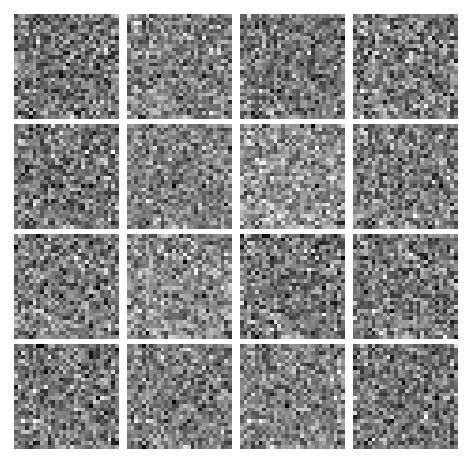


Iter: 250, D: 0.2345, G:0.3951


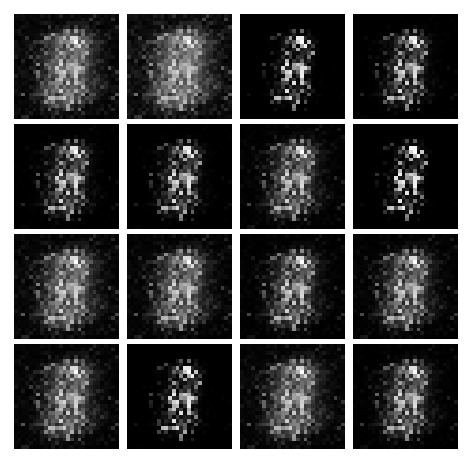


Iter: 500, D: 0.1475, G:0.3004


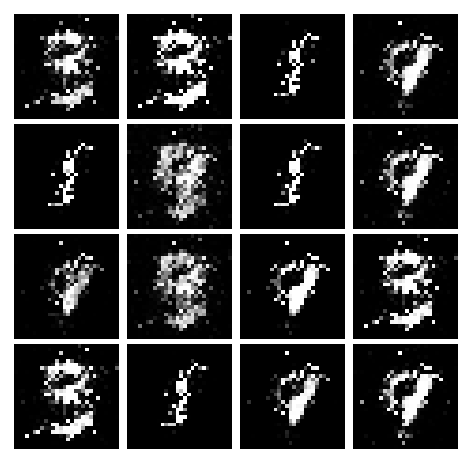


Iter: 750, D: 0.1536, G:0.2518


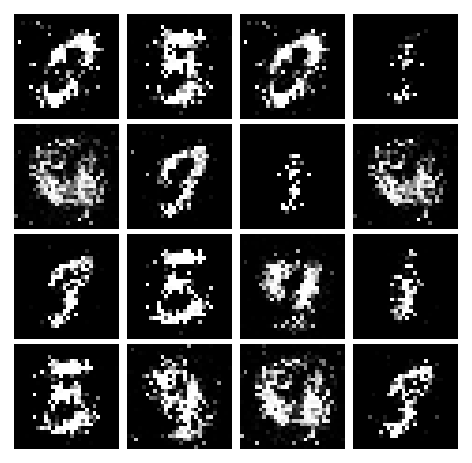


Iter: 1000, D: 0.3054, G:0.4546


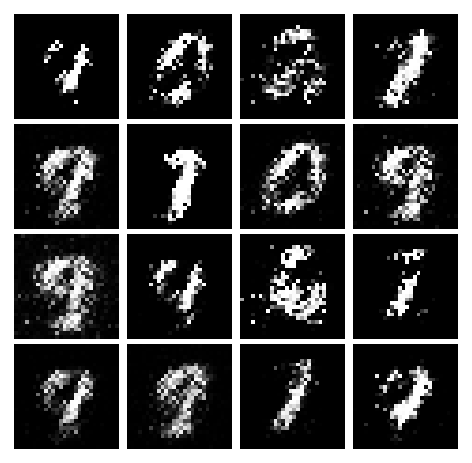


Iter: 1250, D: 0.2695, G:0.1616


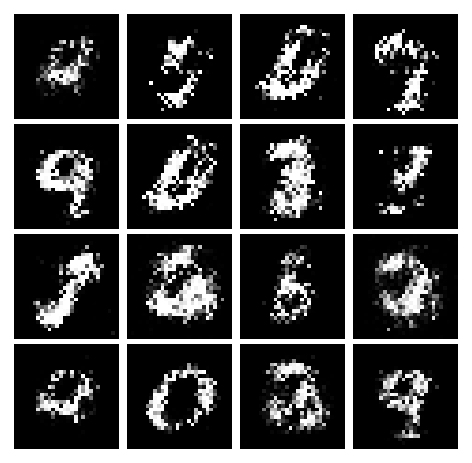


Iter: 1500, D: 0.2574, G:0.1052


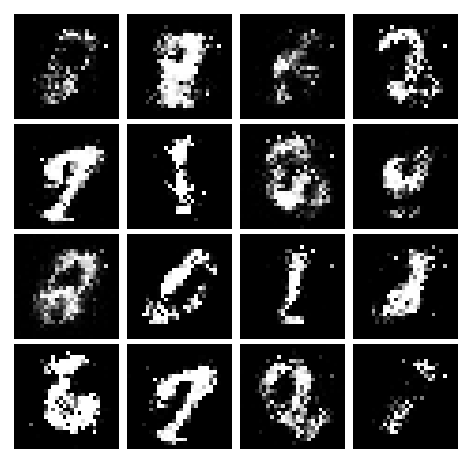


Iter: 1750, D: 0.246, G:0.1352


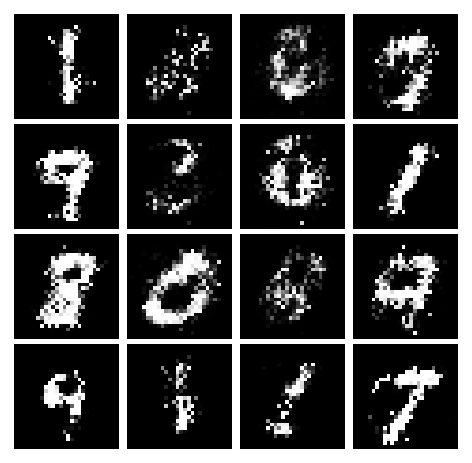


Iter: 2000, D: 0.2438, G:0.1451


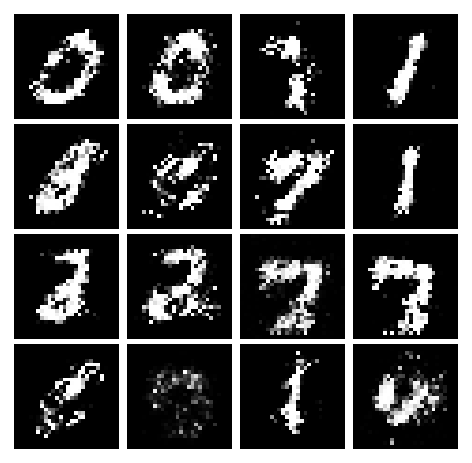


Iter: 2250, D: 0.2511, G:0.156


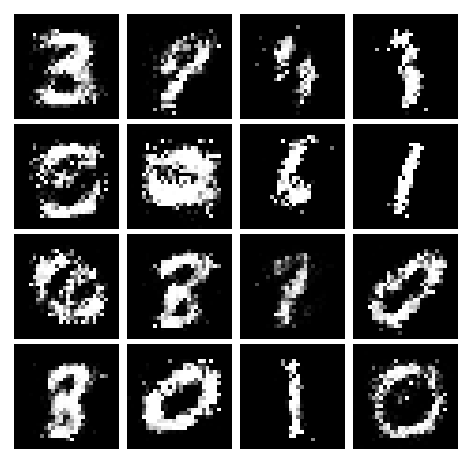


Iter: 2500, D: 0.2611, G:0.1345


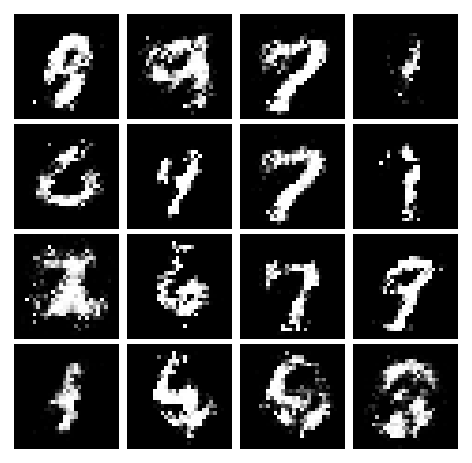


Iter: 2750, D: 0.2461, G:0.1381


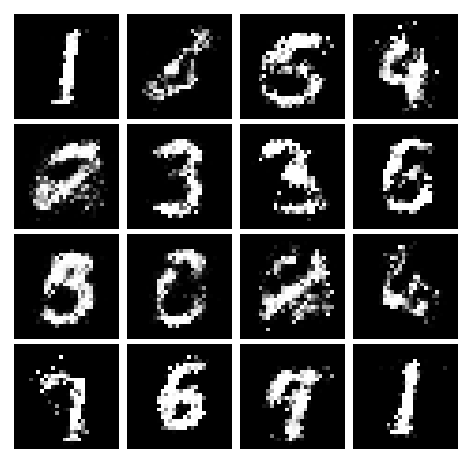


Iter: 3000, D: 0.2543, G:0.136


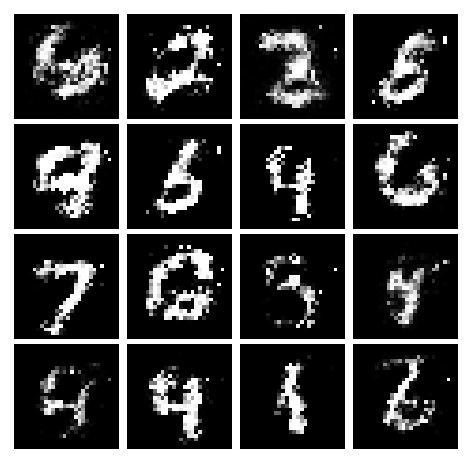


Iter: 3250, D: 0.2485, G:0.1307


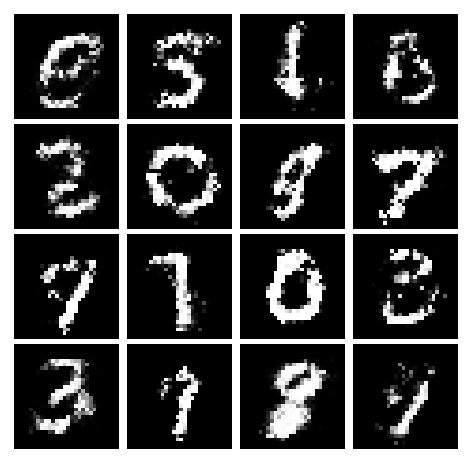


Iter: 3500, D: 0.2497, G:0.1312


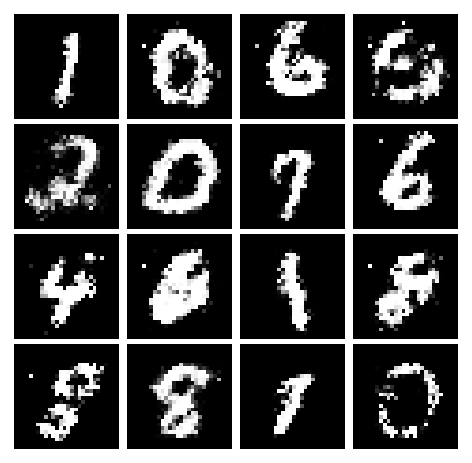


Iter: 3750, D: 0.2499, G:0.1312


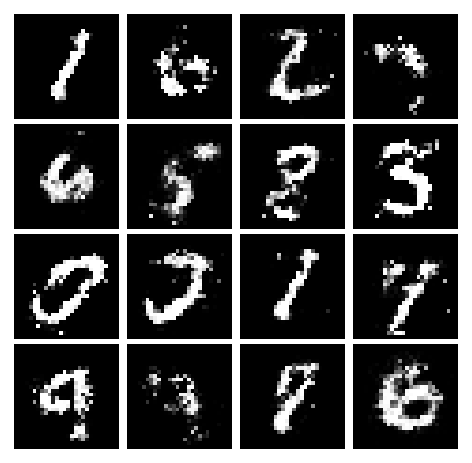


Iter: 4000, D: 0.2539, G:0.1281


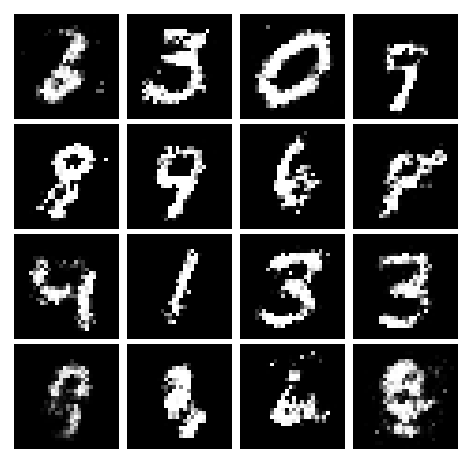


Iter: 4250, D: 0.2516, G:0.1382


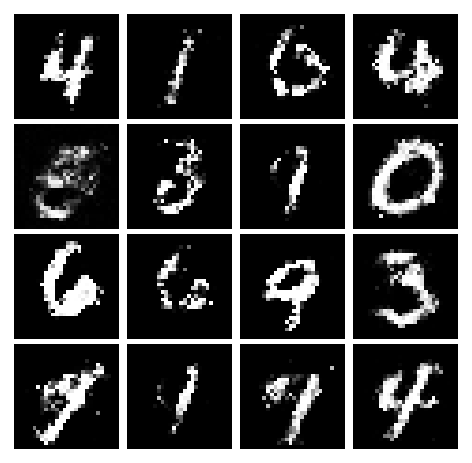


Iter: 4500, D: 0.2536, G:0.1313


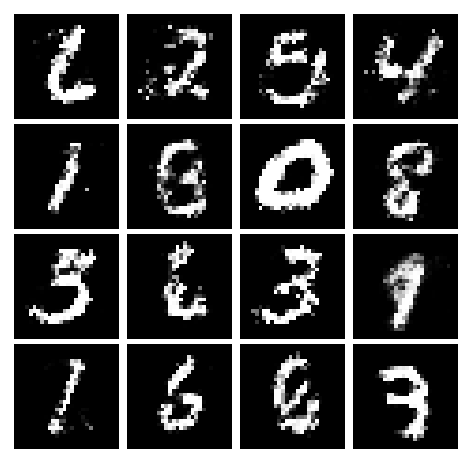


Iter: 4750, D: 0.2619, G:0.1464


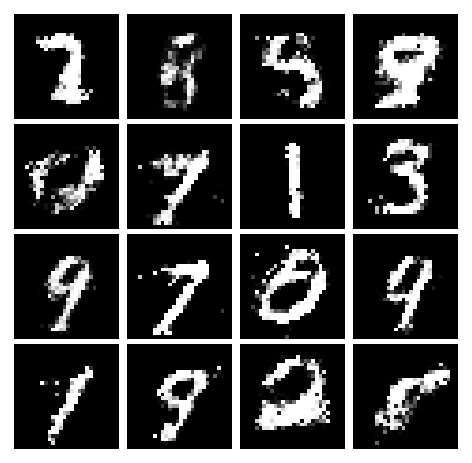


Iter: 5000, D: 0.2496, G:0.1294


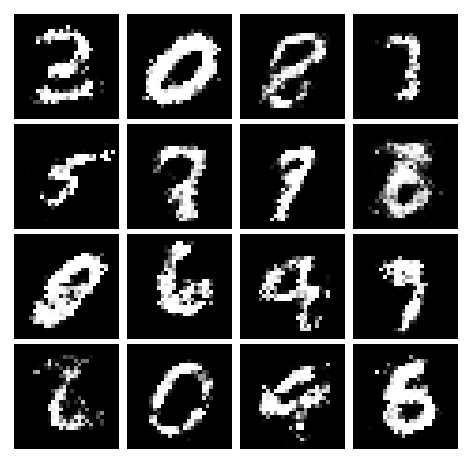


Iter: 5250, D: 0.2517, G:0.1275


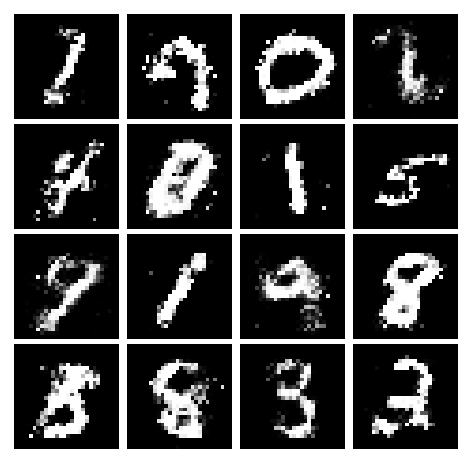


Iter: 5500, D: 0.2654, G:0.126


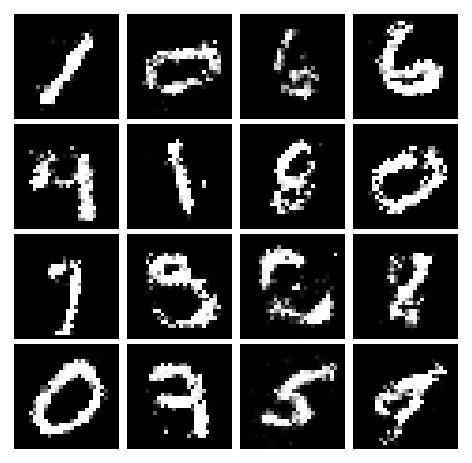


Iter: 5750, D: 0.2536, G:0.1265


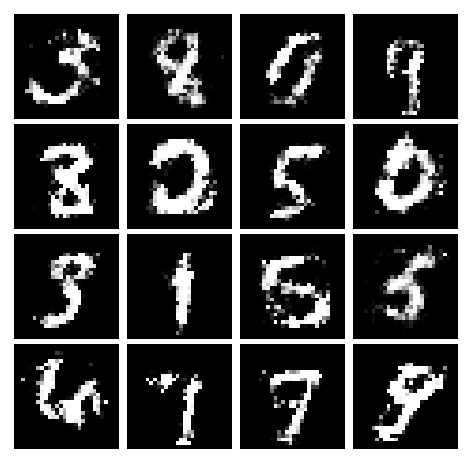


Iter: 6000, D: 0.2547, G:0.1289


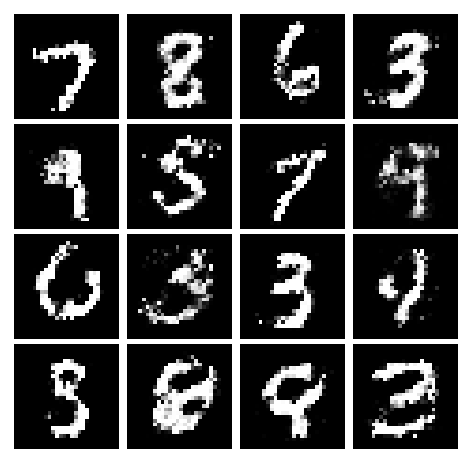


Iter: 6250, D: 0.2572, G:0.1318


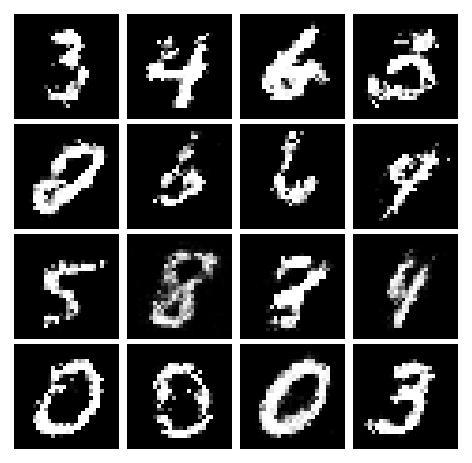


Iter: 6500, D: 0.2512, G:0.1265


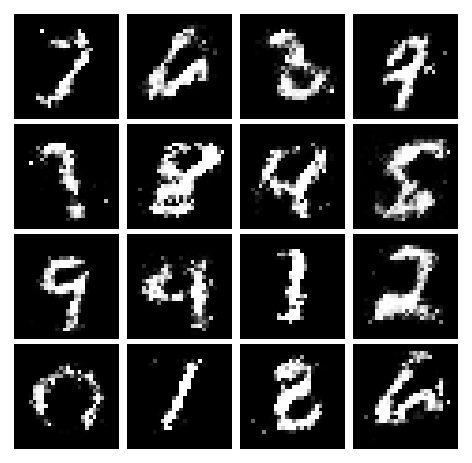


Iter: 6750, D: 0.2477, G:0.1292


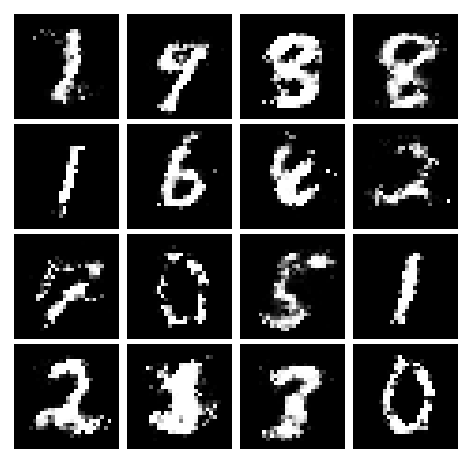


Iter: 7000, D: 0.2576, G:0.1556


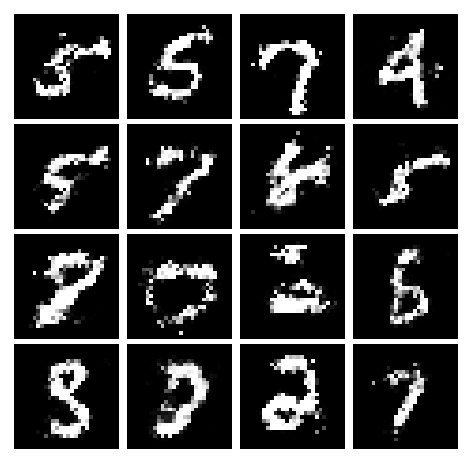


Iter: 7250, D: 0.2549, G:0.1281


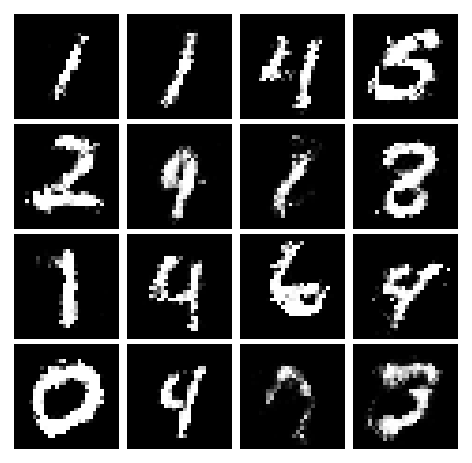


Iter: 7500, D: 0.2516, G:0.1276


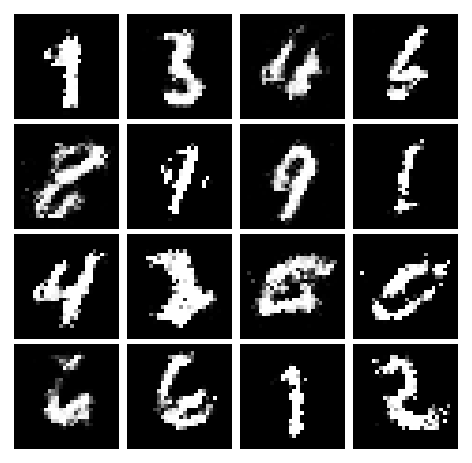


Iter: 7750, D: 0.2504, G:0.1225


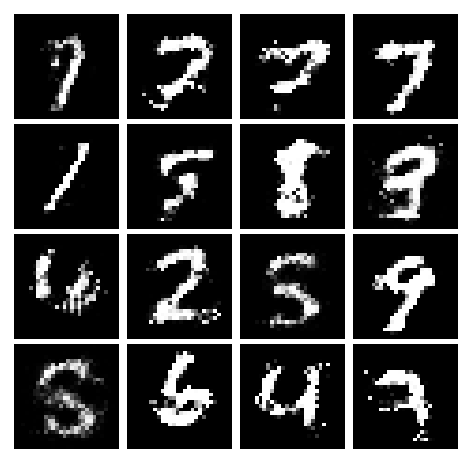

In [16]:
D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

discr_losses, gen_losses = run_a_gan(D_LS, G_LS, D_LS_solver, G_LS_solver, ls_discriminator_loss, ls_generator_loss)

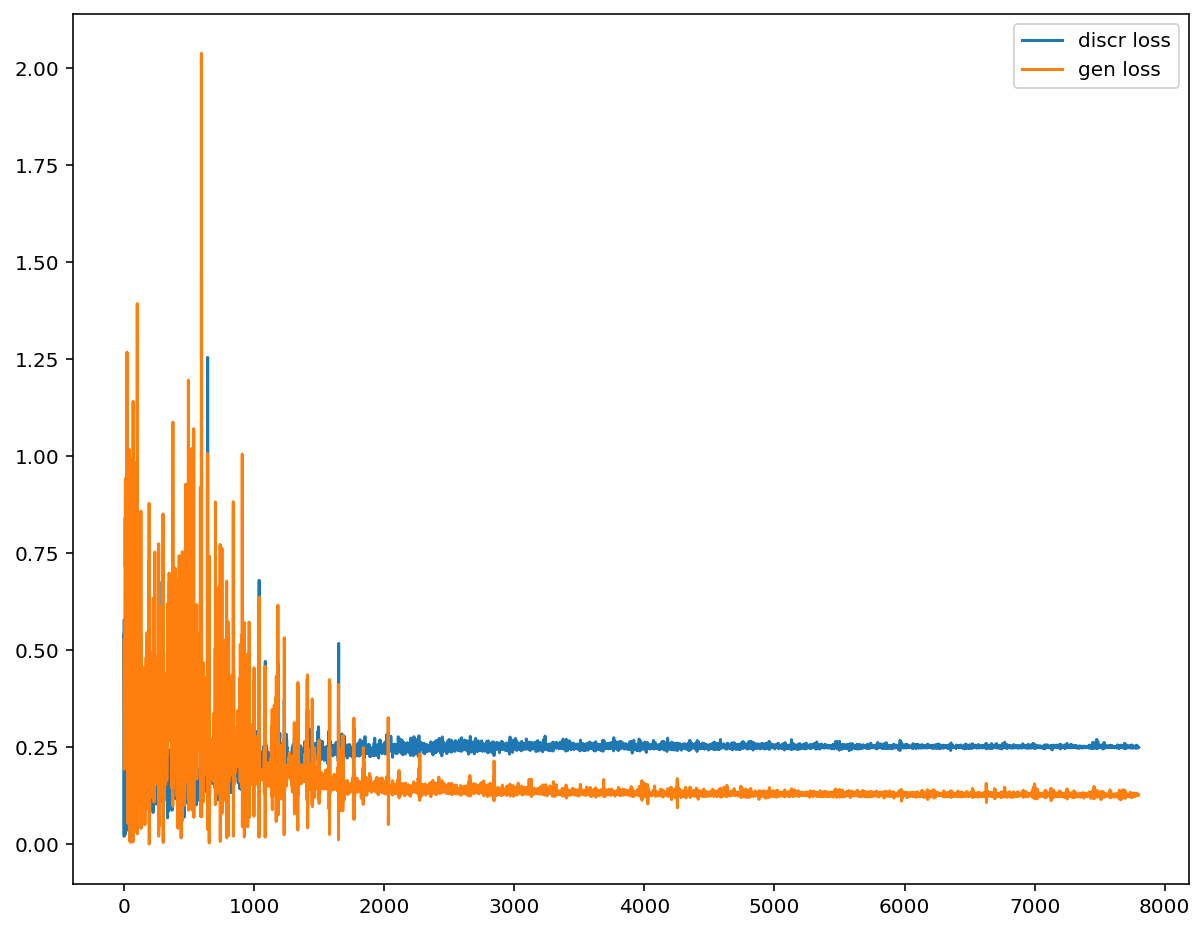

In [17]:
plt.plot(range(len(discr_losses)), discr_losses, label='discr loss')
plt.plot(range(len(gen_losses)), gen_losses, label='gen loss')
plt.legend();

# Deeply Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks 

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification tutorial, which is able to get above 99% accuracy on the MNIST dataset fairly quickly. 
* Reshape into image tensor (Use Unflatten!)
* Conv2D: 32 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

In [18]:
def build_dc_classifier():
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    """
    return nn.Sequential(
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
        nn.LeakyReLU(negative_slope=0.01),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
        nn.LeakyReLU(negative_slope=0.01),
        nn.MaxPool2d(kernel_size=2, stride=2),
        Flatten(),
        nn.Linear(in_features=4*4*64, out_features=4*4*64),
        nn.LeakyReLU(negative_slope=0.01),
        nn.Linear(in_features=4*4*64, out_features=1),

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    )

data = next(enumerate(loader_train))[-1][0].type(dtype)
b = build_dc_classifier().type(dtype)
out = b(data)
print(out.size())

torch.Size([128, 1])


Check the number of parameters in your classifier as a sanity check:

#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode. 
* Fully connected with output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* ReLU
* BatchNorm
* Reshape into Image Tensor of shape 7, 7, 128
* Conv2D^T (Transpose): 64 filters of 4x4, stride 2, 'same' padding (use `padding=1`)
* `ReLU`
* BatchNorm
* Conv2D^T (Transpose): 1 filter of 4x4, stride 2, 'same' padding (use `padding=1`)
* `TanH`
* Should have a 28x28x1 image, reshape back into 784 vector

In [19]:
def build_dc_generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the DCGAN generator using
    the architecture described above.
    """
    return nn.Sequential(
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        nn.Linear(in_features=noise_dim, out_features=1024),
        nn.LeakyReLU(),
        nn.BatchNorm1d(num_features=1024),
        nn.Linear(in_features=1024, out_features=7*7*128),
        nn.LeakyReLU(),
        nn.BatchNorm1d(num_features=7*7*128),
        Unflatten(),
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(),
        nn.BatchNorm2d(num_features=64),
        nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1),
        nn.Tanh(),
        Flatten()

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    )

test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 784])

Check the number of parameters in your generator as a sanity check:

Iter: 0, D: 1.426, G:0.7976


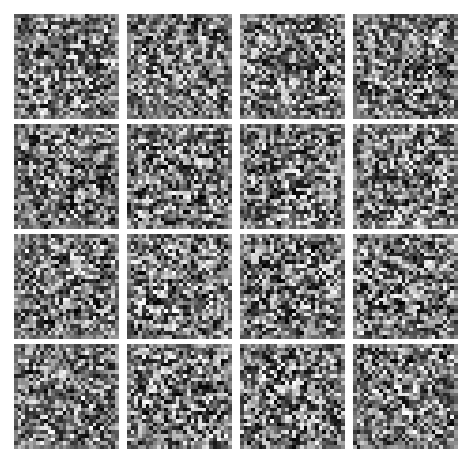


Iter: 250, D: 1.345, G:0.7838


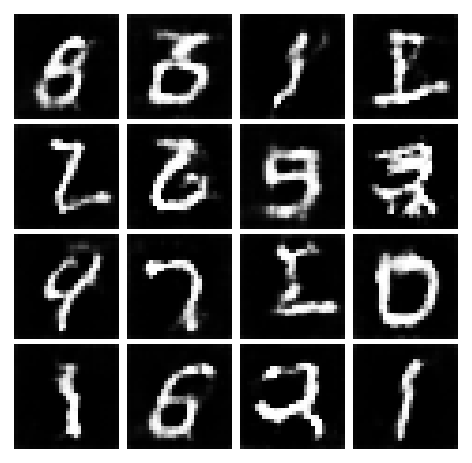


Iter: 500, D: 1.395, G:0.8222


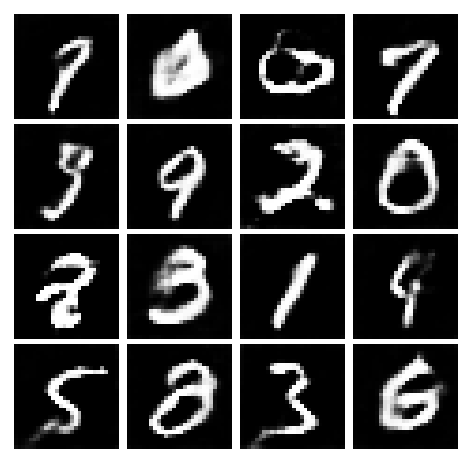


Iter: 750, D: 1.296, G:0.8446


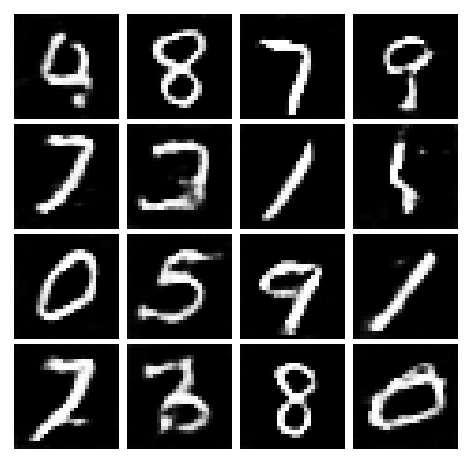


Iter: 1000, D: 1.319, G:0.8399


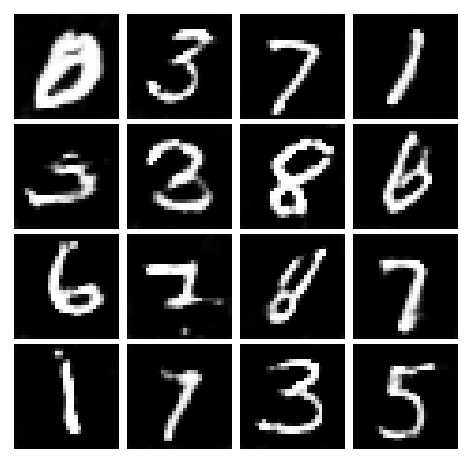


Iter: 1250, D: 1.395, G:0.6881


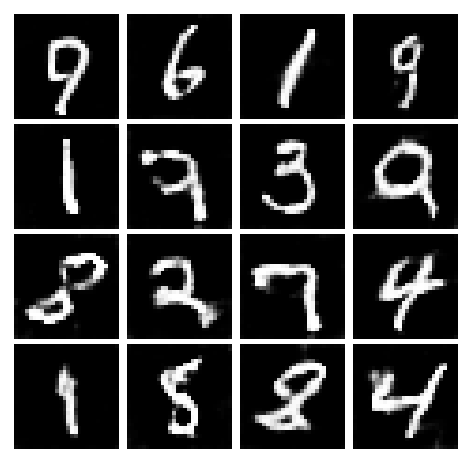


Iter: 1500, D: 1.302, G:0.7494


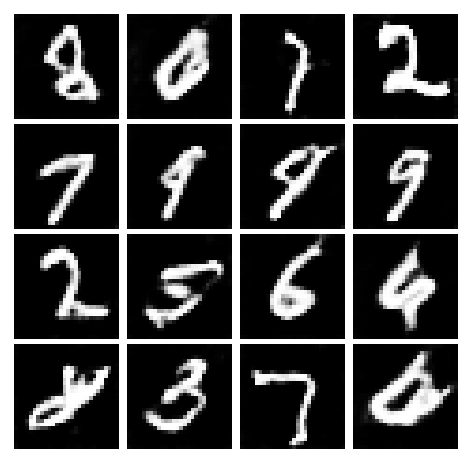


Iter: 1750, D: 1.305, G:0.7216


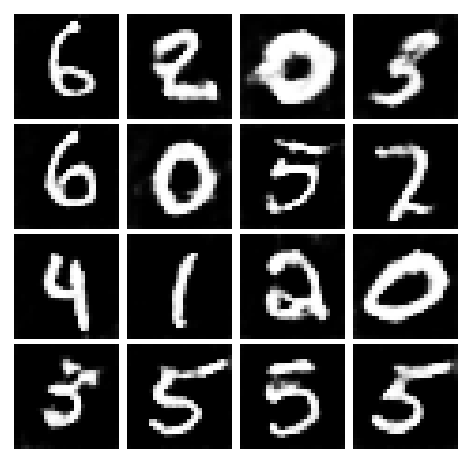

In [20]:
D_DC = build_dc_classifier().type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

discr_losses, gen_losses = run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, num_epochs=5,
                                     lat_opt='ngd')

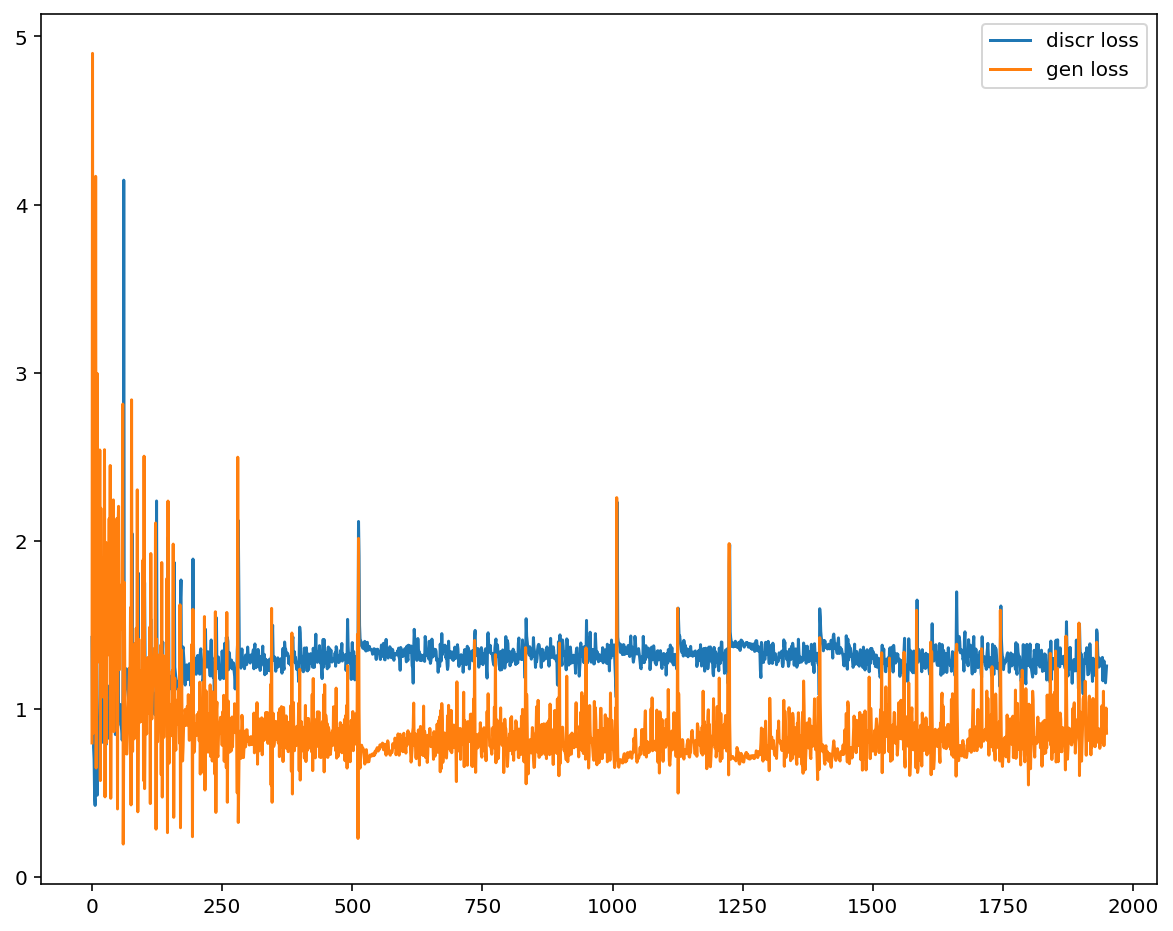

In [21]:
plt.plot(range(len(discr_losses)), discr_losses, label='discr loss')
plt.plot(range(len(gen_losses)), gen_losses, label='gen loss')
plt.ylim([0,5])
plt.legend();